# **Imports**

In [ ]:
from pathlib import Path
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from numpy import mean
import matplotlib as mp
import matplotlib.pyplot as plt
import os
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score, mean_absolute_error, mean_squared_error, roc_auc_score, ConfusionMatrixDisplay # Changed plot_confusion_matrix to ConfusionMatrixDisplayx``
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, cross_validate, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn import tree
from sklearn.tree import export_graphviz, DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.pipeline import Pipeline

# **Models**

In [ ]:
# Default Regression Neural Network seen in Tutorial Pytorch_2
class BasicMLP(nn.Module):
    """
    A simple feedforward neural network with one hidden layer.
    """
    def __init__(self, input_size, hidden_size, output_size):
        super(BasicMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Different combinations of activation functions

class SigmoidReLUNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SigmoidReLUNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.fc(x)

class AllThreeNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(AllThreeNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.fc(x)

class TanhReLUNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TanhReLUNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.fc(x)

In [ ]:
# Drouput Neural Network
class DropoutNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob):
        super(DropoutNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, hidden_size),
            nn.Sigmoid(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.fc(x)

class OneDropoutNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob):
        super(OneDropoutNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, hidden_size),
            nn.Sigmoid(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.fc(x)

In [ ]:
# This nn is the combination of hyperparameters found throughout the assignment
# I put it earlier in the code to reuse things like preprocessing. This is not accurate to chronological order written
class CombinedNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CombinedNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, hidden_size),
            nn.Sigmoid(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.fc(x)

# **Regression Neural Network**

## Preprocessing

### Loading Dataset

In [ ]:
# Reading in data
# data = Path(r'./Cell viability and extrusion dataset V1.csv')
data = Path(r'/content/Cell viability and extrusion dataset V1.csv')
bioprint_df = pd.read_csv(data)

#Setting references column in bioprint_df as the row indices
bioprint_df = bioprint_df.set_index(bioprint_df['Reference'])
bioprint_df = bioprint_df.drop(['Reference', 'DOI'], axis = 1)

# Removing comment from numeric column
col_fix = "Fiber_Diameter_(µm)"
bioprint_df[col_fix] = bioprint_df[col_fix].str.replace(r' \(.*\)', "", regex=True).astype('float64')

### Imputing mode temperatures

In [ ]:
imputer_mode = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent') #imputing mode value into missing values for temperatures
bioprint_df.loc[:,['Syringe_Temperature_(°C)','Substrate_Temperature_(°C)']] = imputer_mode.fit_transform(bioprint_df.loc[:,['Syringe_Temperature_(°C)','Substrate_Temperature_(°C)']])

### Dropping Numerical Data

In [ ]:
#Variables where more than 50% of all instances have null values are dropped
#This amounts to variables with 309 or more null instances for the cell viability dataset with 617 instances
bioprint_df = bioprint_df.dropna(axis = 1, thresh=309)

#Drop instances without cell viability values
bioprint_df = bioprint_df[bioprint_df['Viability_at_time_of_observation_(%)'].notna()]

#Drop nonprinting instances (instances were extrusion pressure is zero)
bioprint_df = bioprint_df.drop(bioprint_df[bioprint_df['Extrusion_Pressure (kPa)'] == 0 ].index)
bioprint_df = bioprint_df[bioprint_df['Extrusion_Pressure (kPa)'].notna()]

### Feature Selection w/ Correlation

In [ ]:
# corr = bioprint_df.corr()
# display(corr)
# fig, ax = plt.subplots(figsize = (20, 16))
# sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, linewidths=0.1)
# abs(bioprint_df.corr()["Viability_at_time_of_observation_(%)"])

#Drop for cell viability, extrusion pressure, and Intrastudy dataset creation
bioprint_df = bioprint_df.drop(['Final_PEGTA_Conc_(%w/v)','Final_PEGMA_Conc_(%w/v)'], axis = 1)

### Imputation of Numerical and Categorical Data

In [ ]:
# Imputation of numerical data
imputer_knn = KNNImputer(n_neighbors = 30, weights = "uniform") #imputing mode value into missing values
bioprint_df.iloc[:,0:28] = imputer_knn.fit_transform(bioprint_df.iloc[:,0:28]) #used for cell viability dataset preprocessing 170

# Imputation of categorical data
bioprint_df = bioprint_df.fillna(bioprint_df['Conical_or_Straight_Nozzle'].value_counts().index[0])

#Drop categorical or numerical cell viability column depending on which type of prediction model is desired (regression versus classification)
bioprint_df = bioprint_df.drop(['Acceptable_Viability_(Yes/No)'], axis = 1)
bioprint_df = bioprint_df.drop(['Acceptable_Pressure_(Yes/No)'], axis = 1)

### Normalizing and Encoding

In [ ]:
x = bioprint_df.drop("Viability_at_time_of_observation_(%)", axis = 1)
y = bioprint_df["Viability_at_time_of_observation_(%)"].values

#Use MinMaxScaler() function to normalize input values for performance metric evaluation. DO NOT USE for value prediction for cell viability and extrusion pressure
x.iloc[:,0:28] = MinMaxScaler().fit_transform(x.iloc[:,0:28]) # Used for cell viability generalized dataset 171
y = y.reshape(-1,1) #used for extracting mean squared error
y = MinMaxScaler().fit_transform(y) #used for extracting mean squared error

x_ohencoded = pd.get_dummies(x, columns=['Cell_Culture_Medium_Used?','DI_Water_Used?','Precrosslinking_Solution_Used?','Saline_Solution_Used?','EtOH_Solution_Used?','Photoinitiator_Used?','Enzymatic_Crosslinker_Used?','Matrigel_Used?','Conical_or_Straight_Nozzle','Primary/Not_Primary'], dtype=float) #one-hot encoding is used to encode binary/categorical data in datasets

## Set up

In [ ]:
# Training function
def trainRegression(model, optimiser, loss_fn, epochs, X_train, y_train):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    loss_fn = loss_fn.to(device)
    loss_lst = []

    for epoch in range(epochs):
        # Transfer data to `device`
        inputs, labels = X_train.to(device), y_train.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = loss_fn(outputs, labels)
        loss_lst.append(loss.item())

        loss.backward() # Compute gradients
        optimiser.step() # Update weights
        optimiser.zero_grad(set_to_none=True) # Reset gradients for next iteration

    return loss_lst

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x_ohencoded.values, y, test_size=0.15, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

## Default NN

### Whole Training Set

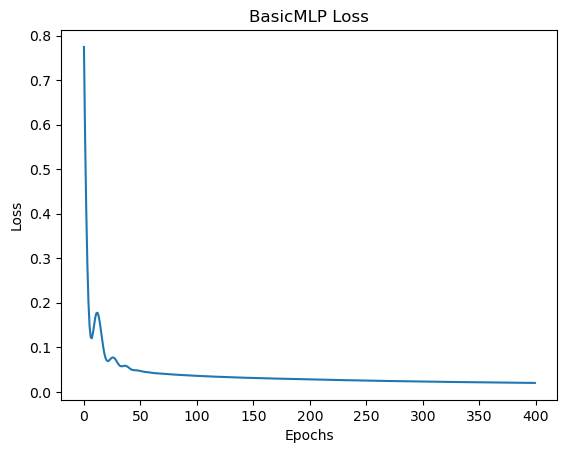

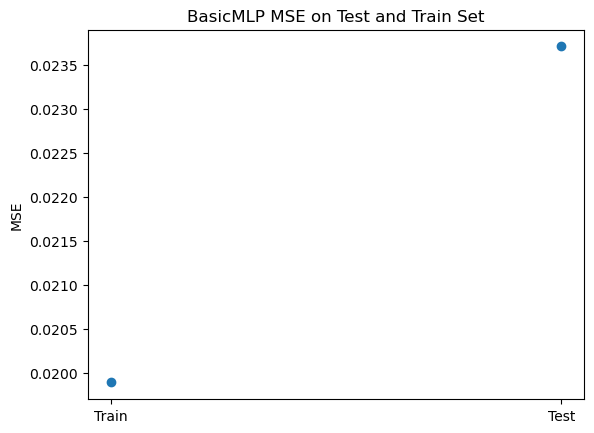

In [ ]:
loss_fn = nn.MSELoss()
epochs = 400

# Training w/ default parameters or Optimizer
model = BasicMLP(X_train.shape[1], 64, 1)
optimiser = optim.Adam(model.parameters())
mse_lst = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)

plt.plot(range(epochs), mse_lst)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('BasicMLP Loss')
plt.show()

train_pred = model(X_train_tensor)
mse_train = mean_squared_error(y_train_tensor.detach().numpy(), train_pred.detach().numpy())

test_pred = model(X_test_tensor)
mse_test = mean_squared_error(y_test_tensor.detach().numpy(), test_pred.detach().numpy())

plt.scatter(['Train', 'Test'], [mse_train, mse_test])
plt.ylabel('MSE')
plt.title('BasicMLP MSE on Test and Train Set')
plt.show()


### K-fold

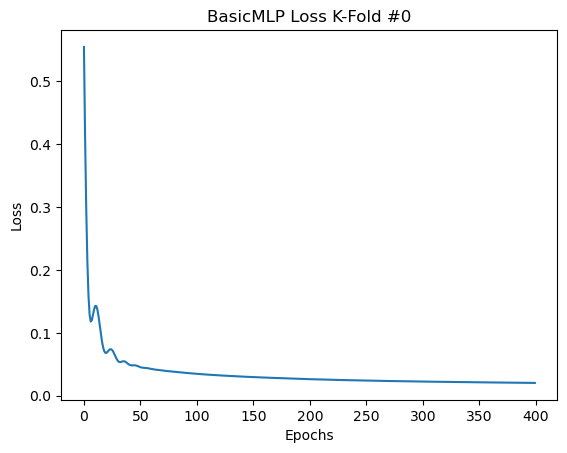

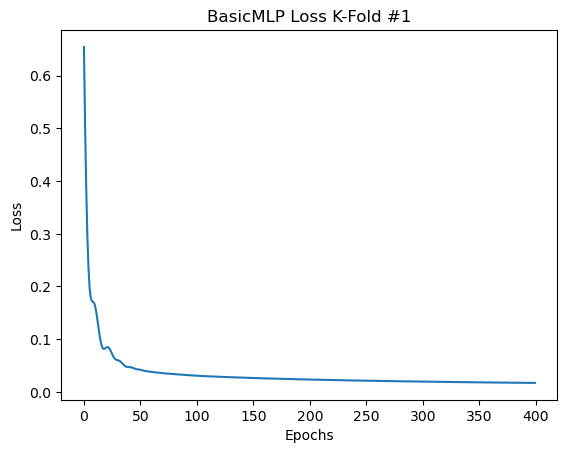

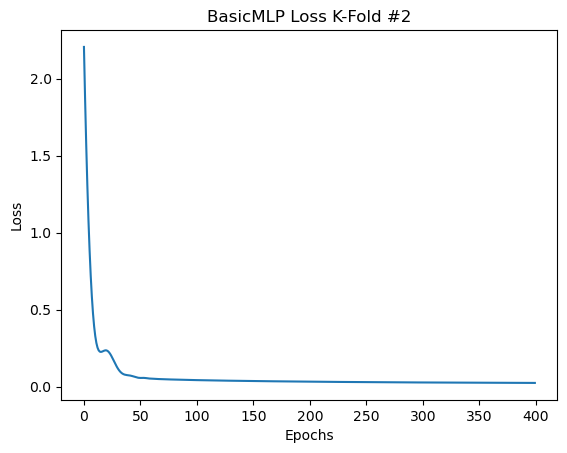

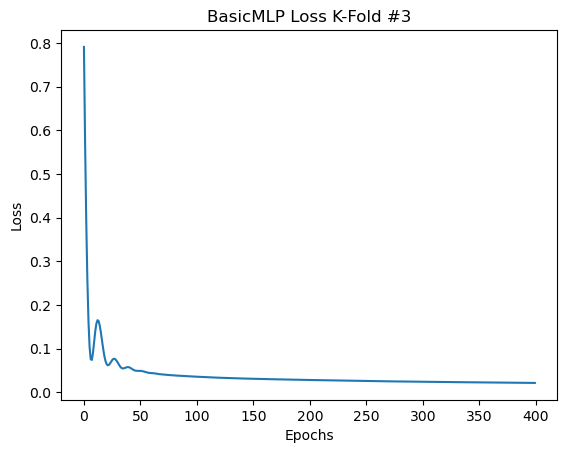

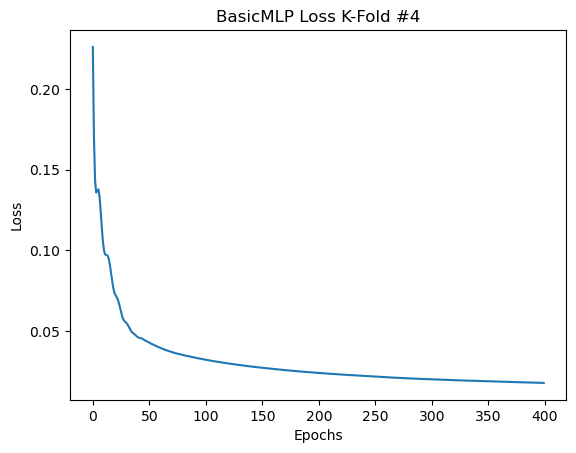

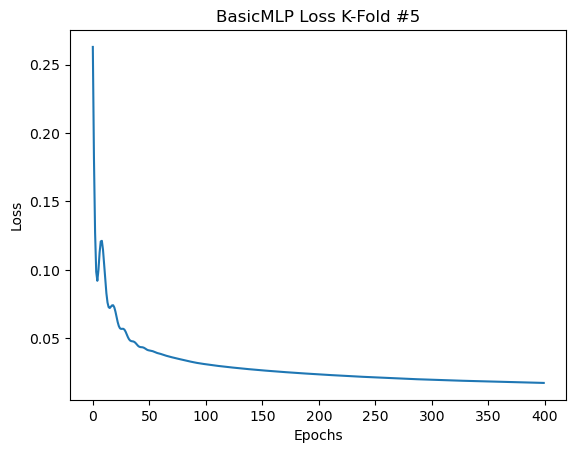

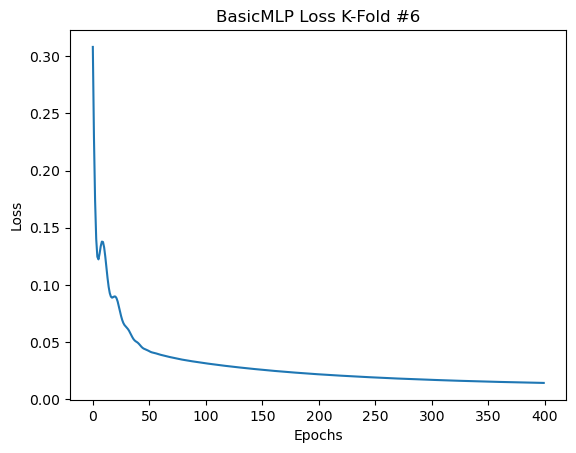

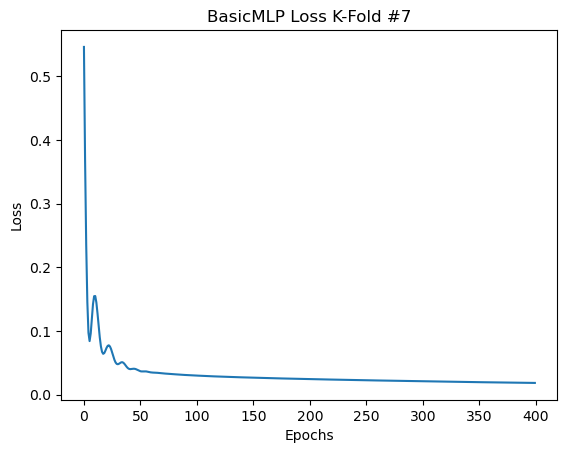

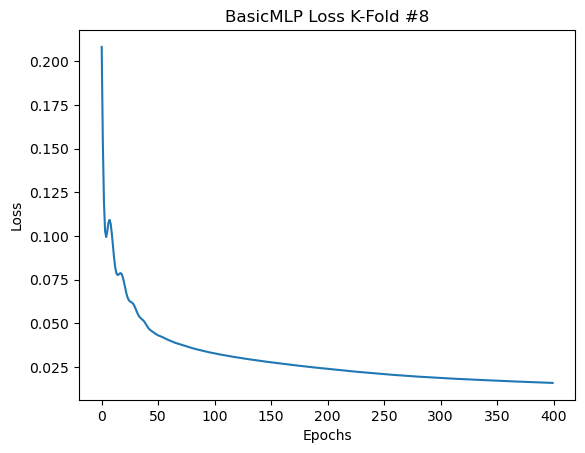

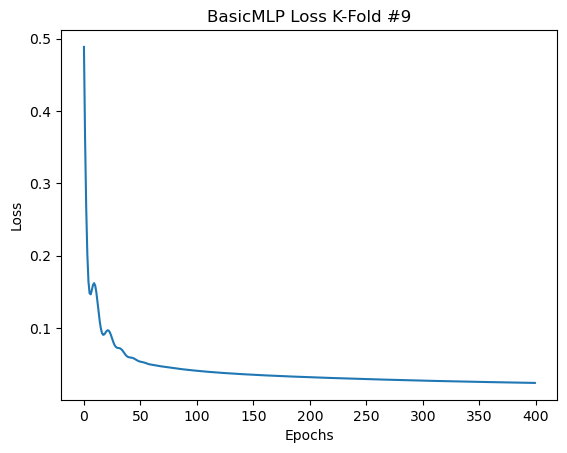

In [ ]:
x, y = x_ohencoded, y

# Initialize lists to store training and test MSE for each fold
mse_train_lst, mse_test_lst = [], []

# Create the KFold object
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True)

i = 0 # Tracking k-fold

# Loop over the folds
for train_index, test_index in kf.split(x):
    # Split the data into training and test sets for this fold
    x_fold_train= x.iloc[train_index]
    y_fold_train = y[train_index]
    x_fold_test= x.iloc[test_index]
    y_fold_test = y[test_index]

    # Convert to tensor
    X_train_tensor = torch.tensor(x_fold_train.values).float()
    y_train_tensor = torch.tensor(y_fold_train).float()

    # Train the model on the training set for this fold
    model = BasicMLP(x_fold_train.shape[1], 64, 1)
    optimiser = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()
    epochs = 400
    epoch_lst = range(epochs)

    mse_lst = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)

    # Plot loss curve
    plt.plot(epoch_lst, mse_lst)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('BasicMLP Loss K-Fold #%s' % i)
    plt.show()

    # Evaluate model
    train_pred = model(X_train_tensor)
    mse_train = mean_squared_error(y_train_tensor.detach().numpy(), train_pred.detach().numpy())

    test_pred = model(X_test_tensor)
    mse_test = mean_squared_error(y_test_tensor.detach().numpy(), test_pred.detach().numpy())

    # Save mse to lists
    mse_train_lst.append(mse_train)
    mse_test_lst.append(mse_test)

    i += 1

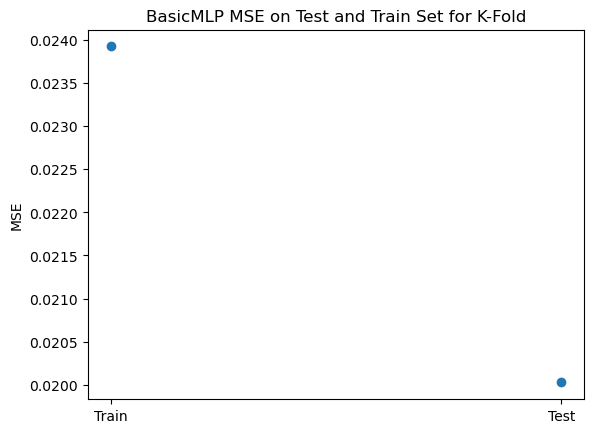

In [ ]:
# MSE Plot
# Get mean from data
train_mse_mean = np.mean(mse_train_lst)
test_mse_mean = np.mean(mse_test_lst)

plt.scatter(['Train', 'Test'], [mse_train, mse_test])
plt.ylabel('MSE')
plt.title('BasicMLP MSE on Test and Train Set for K-Fold')

plt.show()

## Three Different Activation Functions

### Whole dataset

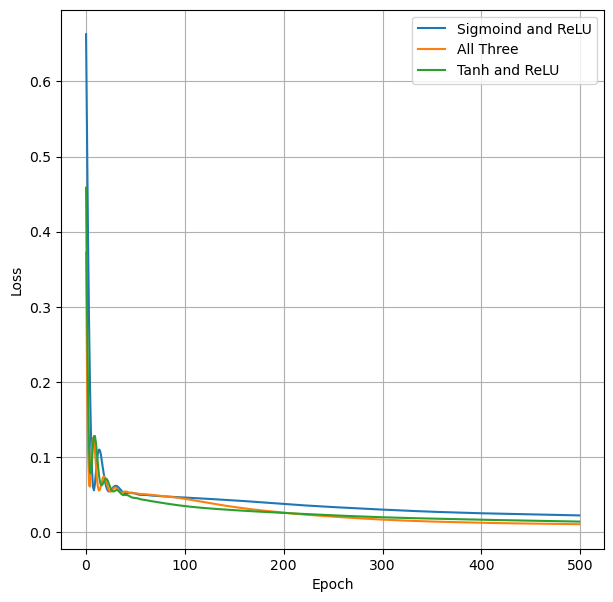

In [ ]:
loss_fn = nn.MSELoss()

model = SigmoidReLUNN(X_train.shape[1], 64, 1)
optimiser = optim.Adam(model.parameters())
S_R_lst = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
# ---------------------------------------------
model = AllThreeNN(X_train.shape[1], 64, 1)
optimiser = optim.Adam(model.parameters())
All_lst = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)

# ---------------------------------------------

model = TanhReLUNN(X_train.shape[1], 64, 1)
optimiser = optim.Adam(model.parameters())
T_R_lst = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)


# Plot loss over epochs
plt.figure(figsize=(7,7))
plt.plot(range(epochs), S_R_lst, label='Sigmoind and ReLU')
plt.plot(range(epochs), All_lst, label='All Three')
plt.plot(range(epochs), T_R_lst, label='Tanh and ReLU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

### K-fold

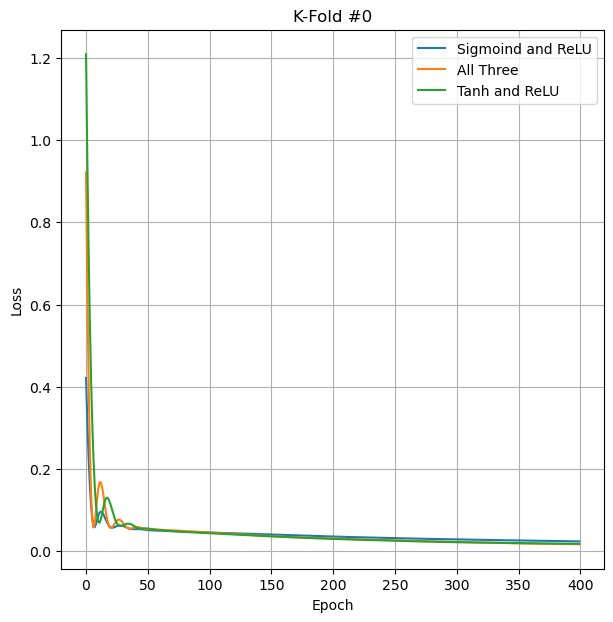

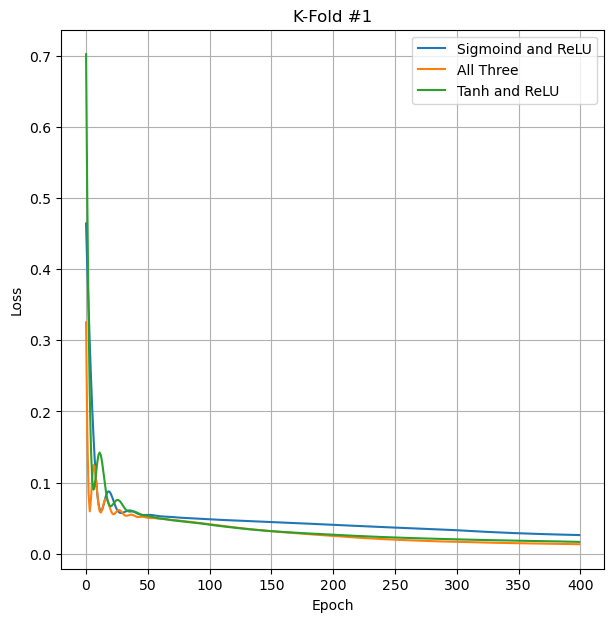

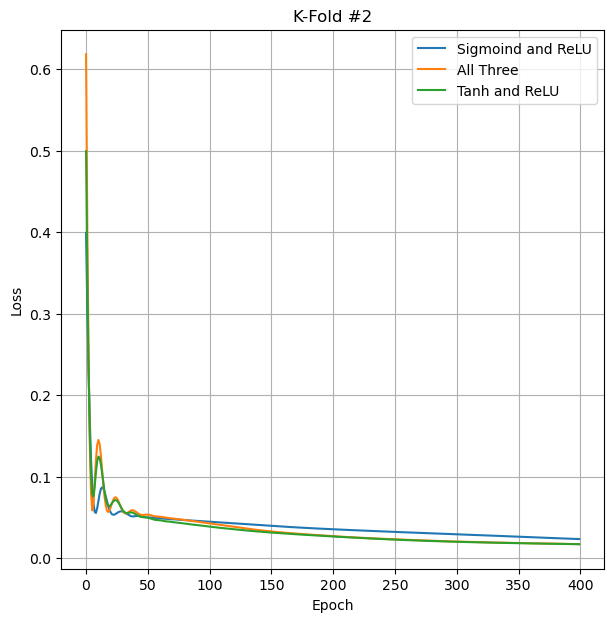

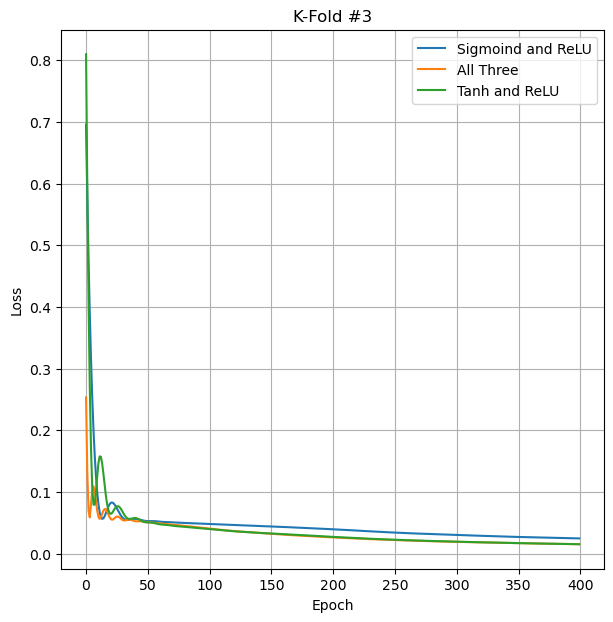

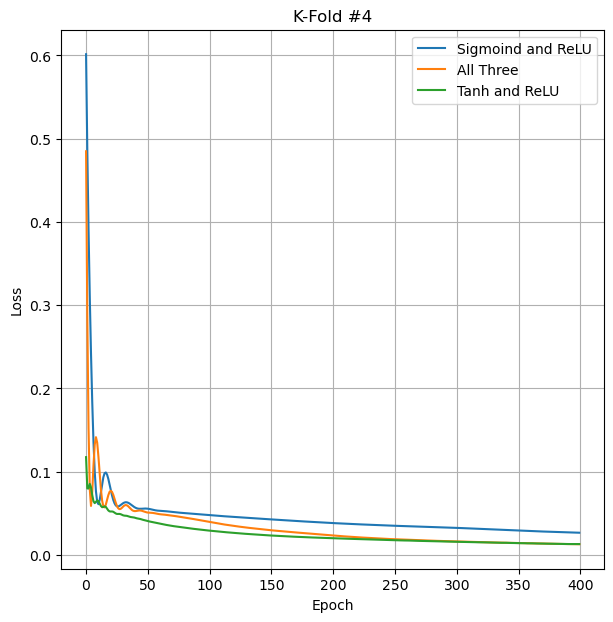

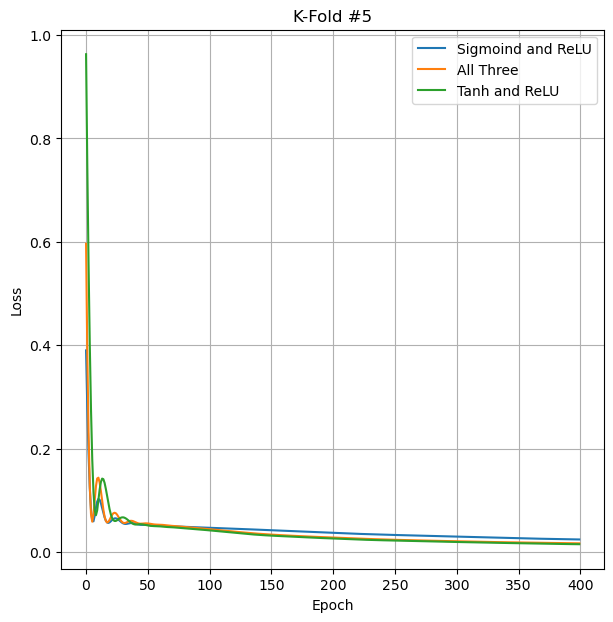

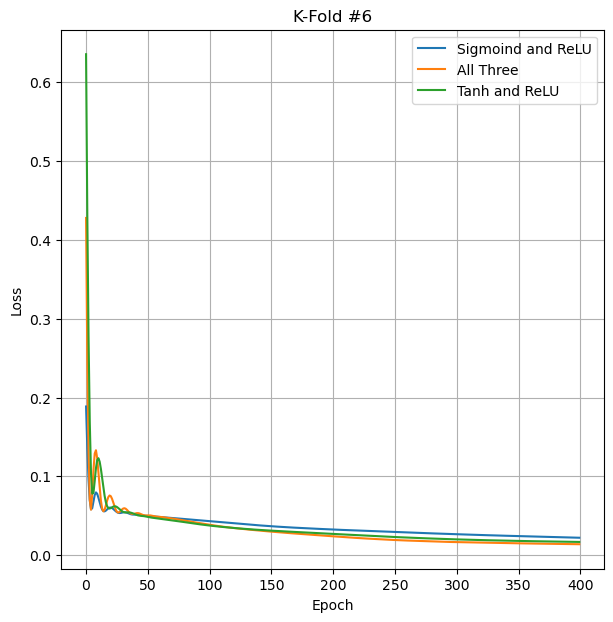

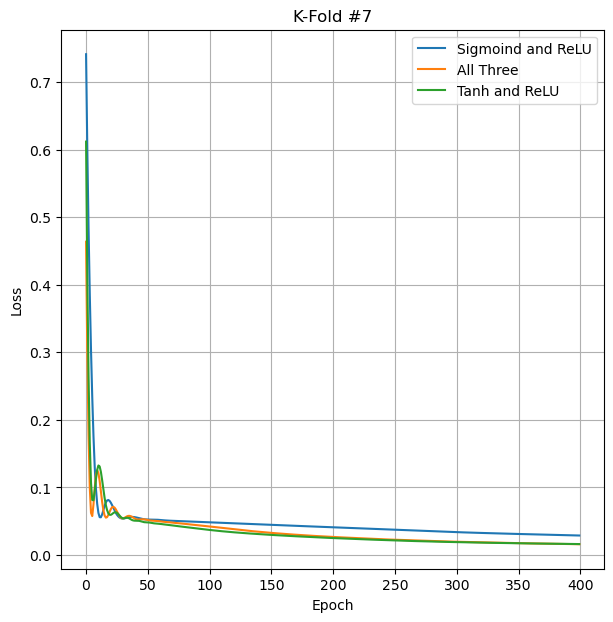

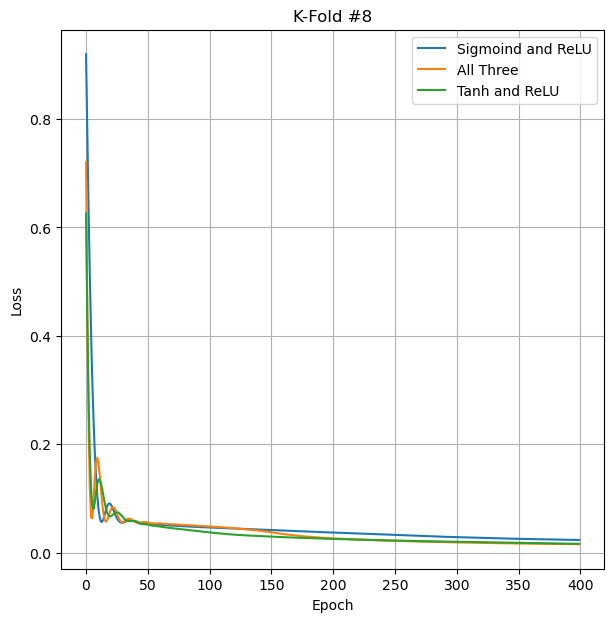

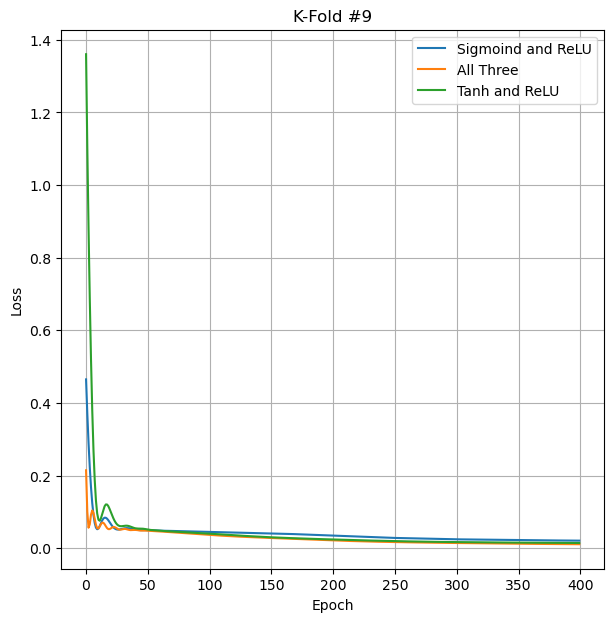

In [ ]:
x, y = x_ohencoded, y

# Create the KFold object
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True)

i = 0 # Tracking k-fold

# Loop over the folds
for train_index, test_index in kf.split(x):
    # Split the data into training and test sets for this fold
    x_fold_train= x.iloc[train_index]
    y_fold_train = y[train_index]
    x_fold_test= x.iloc[test_index]
    y_fold_test = y[test_index]

    # Convert to tensor
    X_train_tensor = torch.tensor(x_fold_train.values).float()
    y_train_tensor = torch.tensor(y_fold_train).float()

    loss_fn = nn.MSELoss()

    model = SigmoidReLUNN(X_train.shape[1], 64, 1)
    optimiser = optim.Adam(model.parameters())
    S_R_lst = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
    # ---------------------------------------------
    model = AllThreeNN(X_train.shape[1], 64, 1)
    optimiser = optim.Adam(model.parameters())
    All_lst = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)

    # ---------------------------------------------

    model = TanhReLUNN(X_train.shape[1], 64, 1)
    optimiser = optim.Adam(model.parameters())
    T_R_lst = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)


    # Plot loss over epochs
    plt.figure(figsize=(7,7))
    plt.plot(range(epochs), S_R_lst, label='Sigmoind and ReLU')
    plt.plot(range(epochs), All_lst, label='All Three')
    plt.plot(range(epochs), T_R_lst, label='Tanh and ReLU')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('K-Fold #%s'%i)
    plt.grid(True)
    plt.legend()
    plt.show()

    i += 1

## Learning Rates and Momentum

### Whole dataset

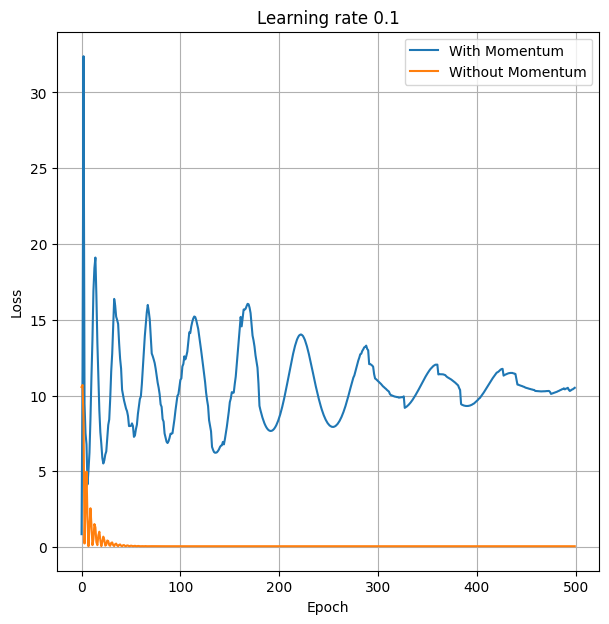

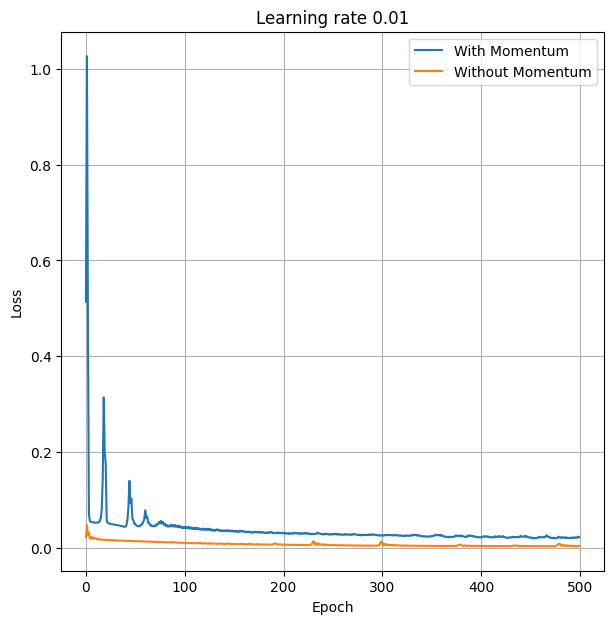

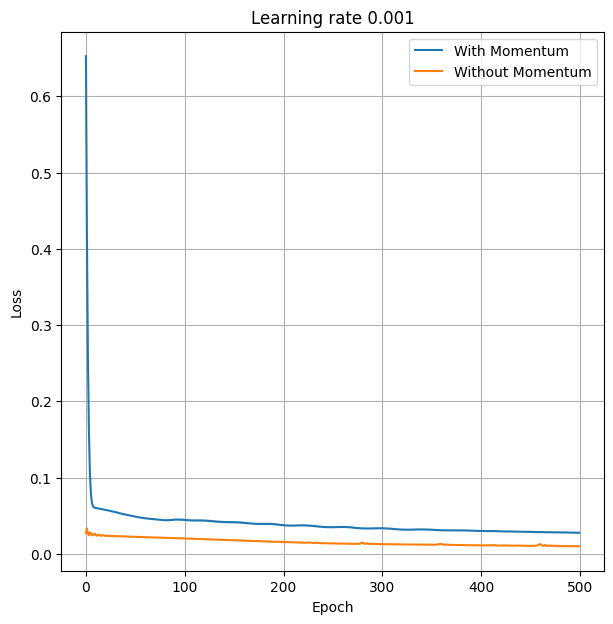

In [ ]:
loss_fn = nn.MSELoss()

learn_rate = [0.1, 0.01, 0.001]

for lr in learn_rate:
  model = AllThreeNN(X_train.shape[1], 64, 1)
  optimiser = optim.Adam(model.parameters(), lr=lr, betas=(0.0, 0.999))
  All_momentum = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)

  optimiser = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
  All_no_momentum = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)

  # Plot loss over epochs
  plt.figure(figsize=(7,7))
  plt.plot(range(epochs), All_momentum, label='With Momentum')
  plt.plot(range(epochs), All_no_momentum, label='Without Momentum')
  plt.title('Learning rate %s' % lr)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid(True)
  plt.legend()
  plt.show()



### K-fold

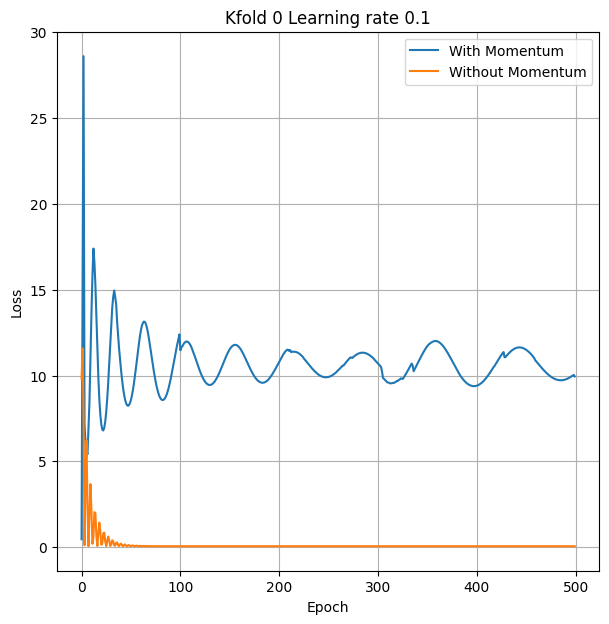

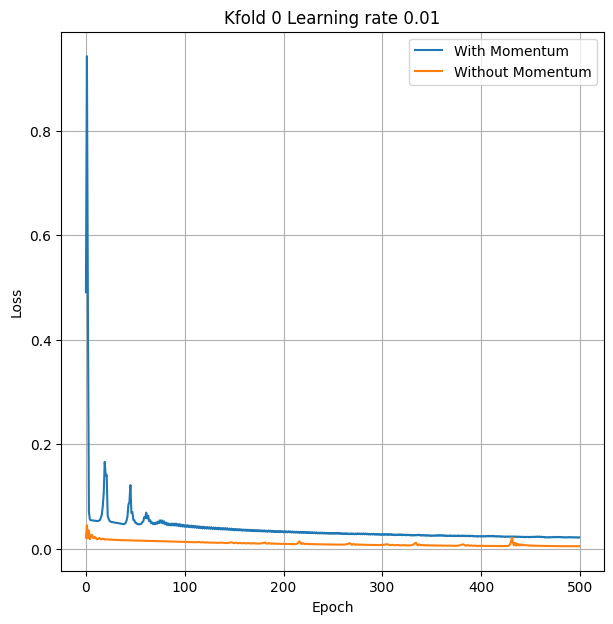

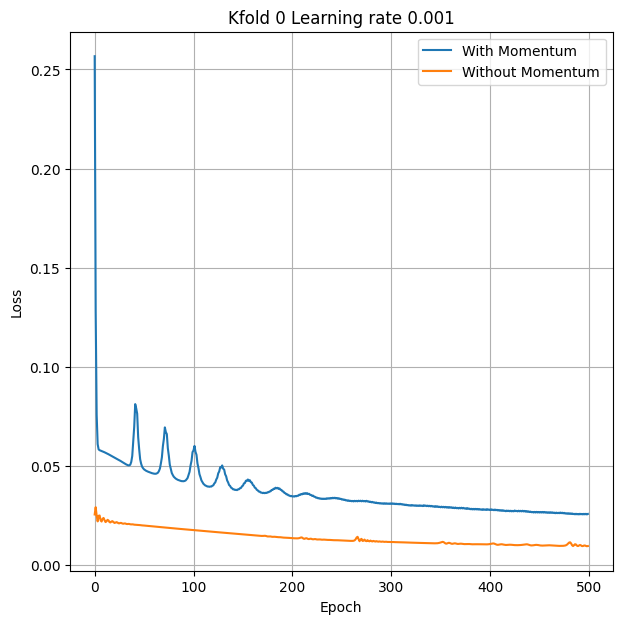

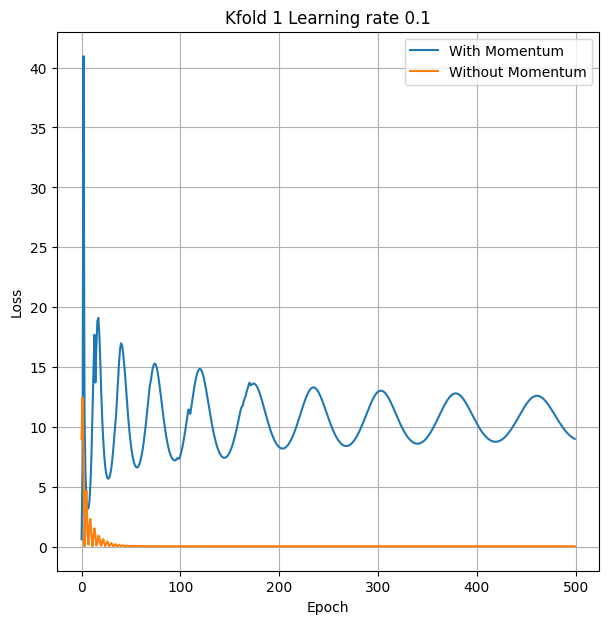

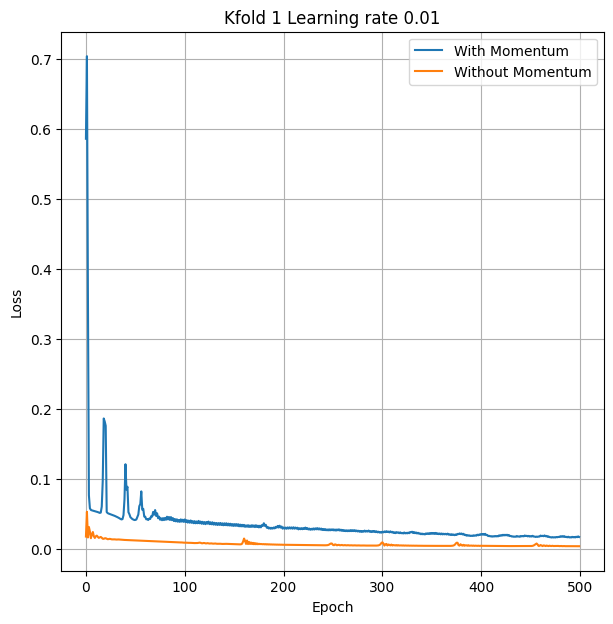

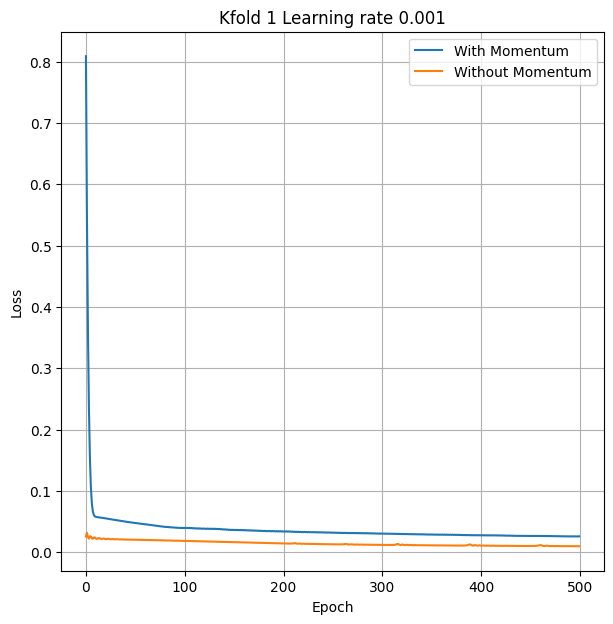

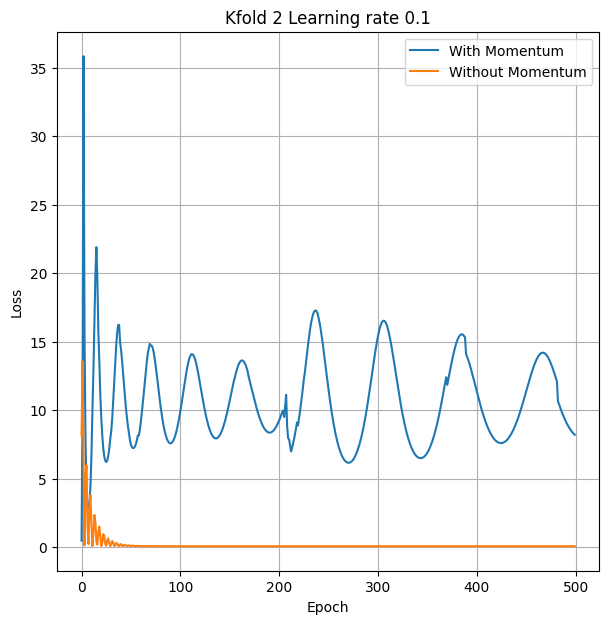

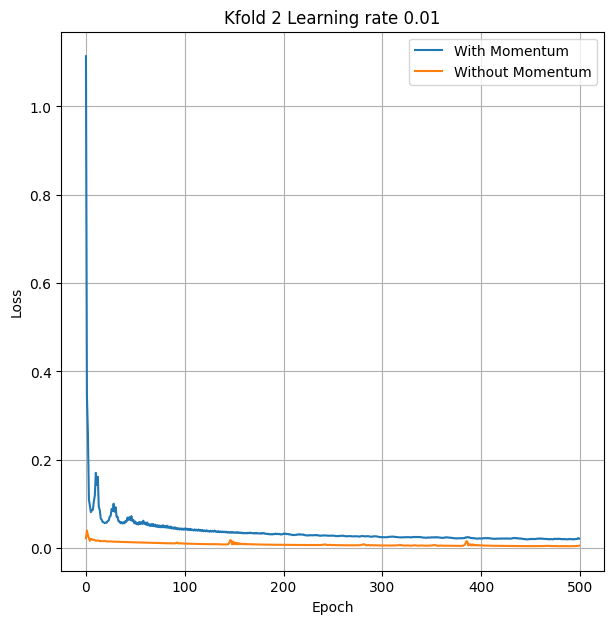

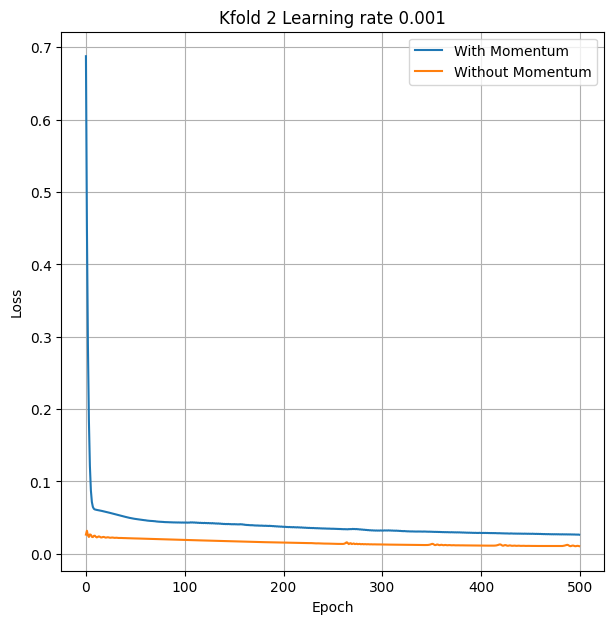

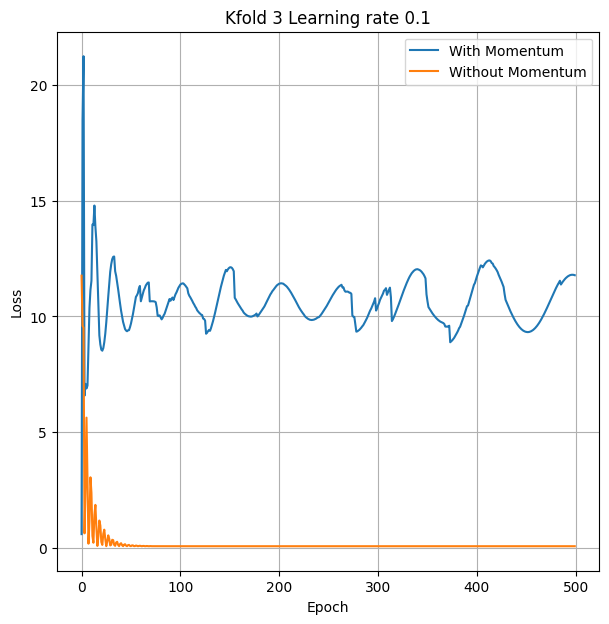

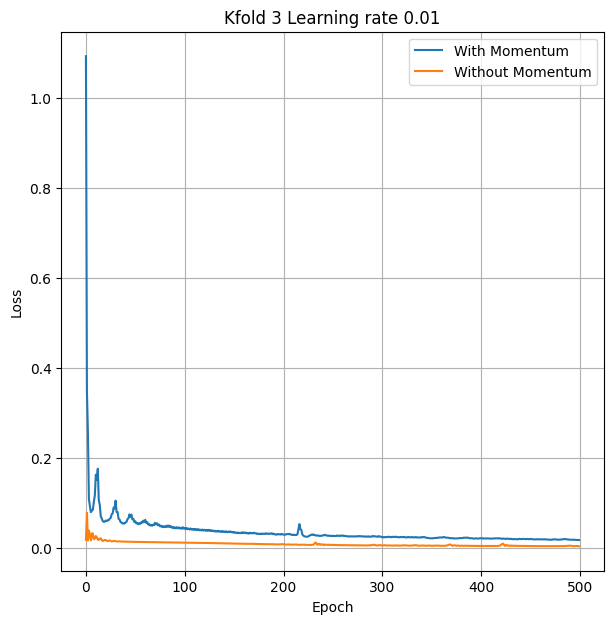

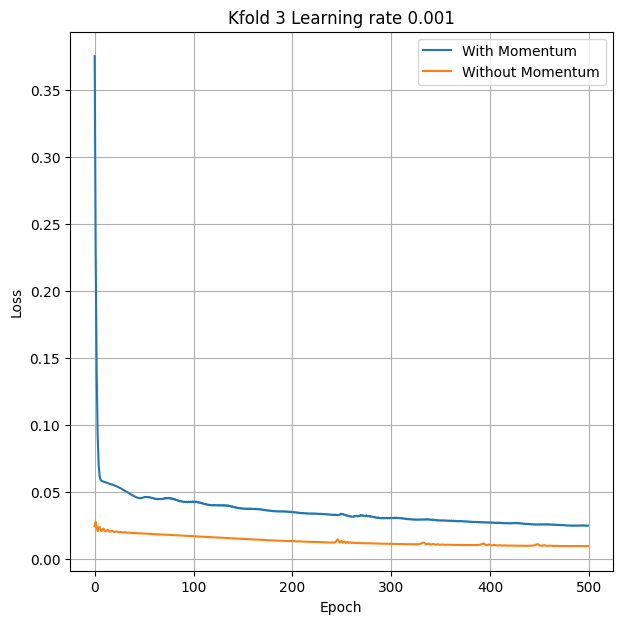

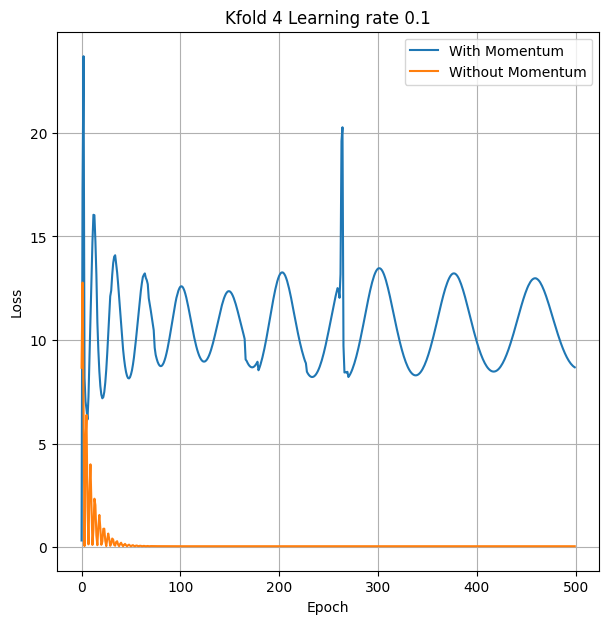

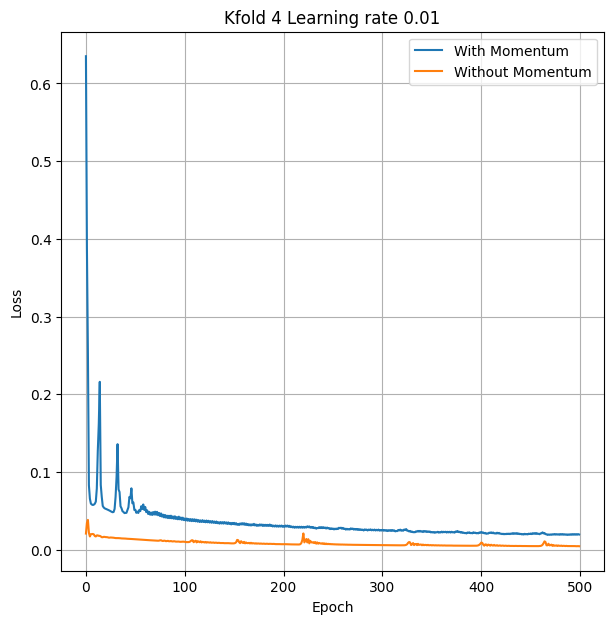

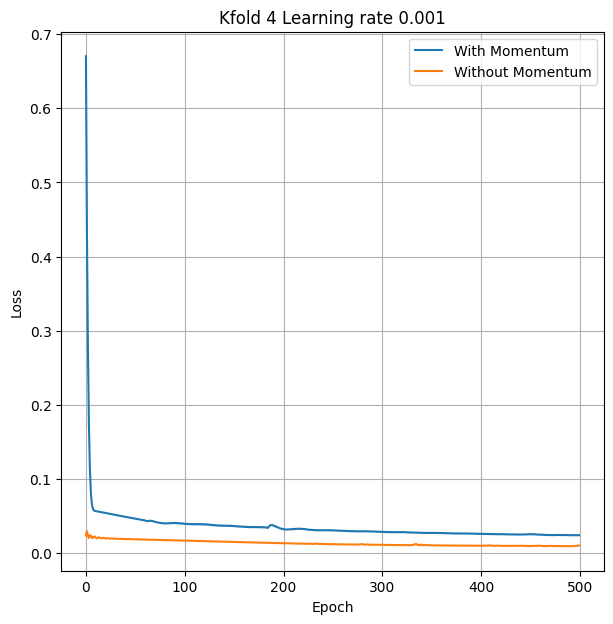

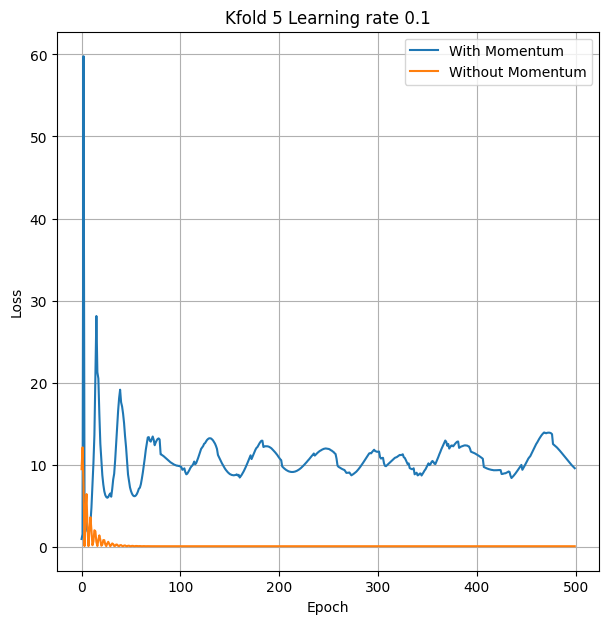

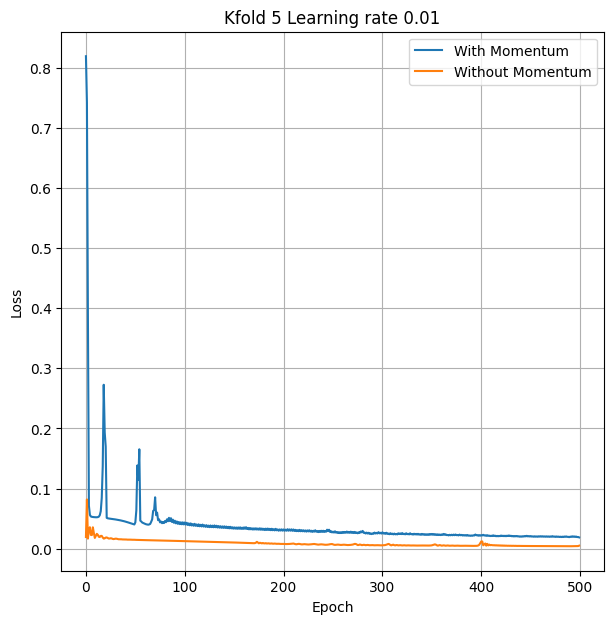

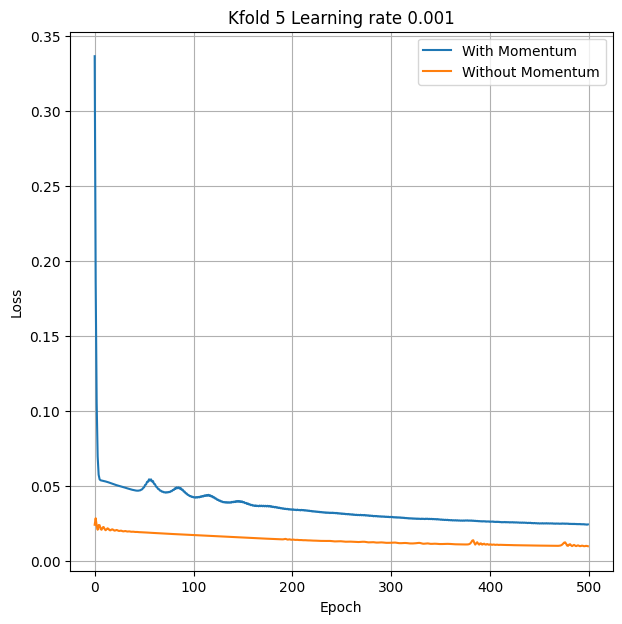

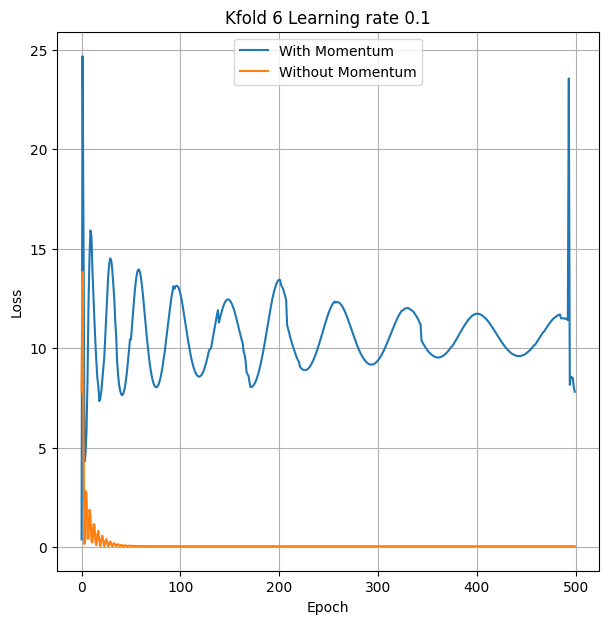

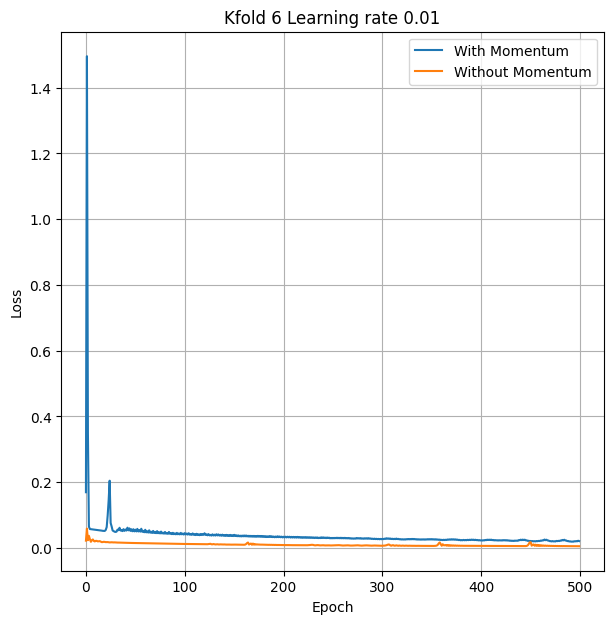

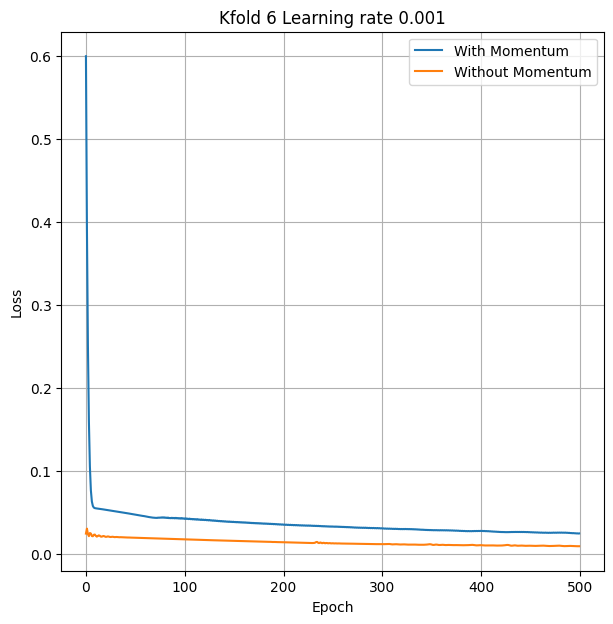

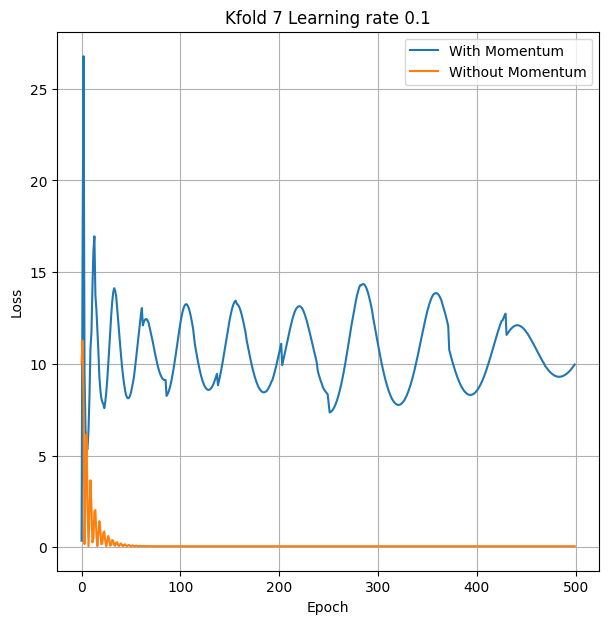

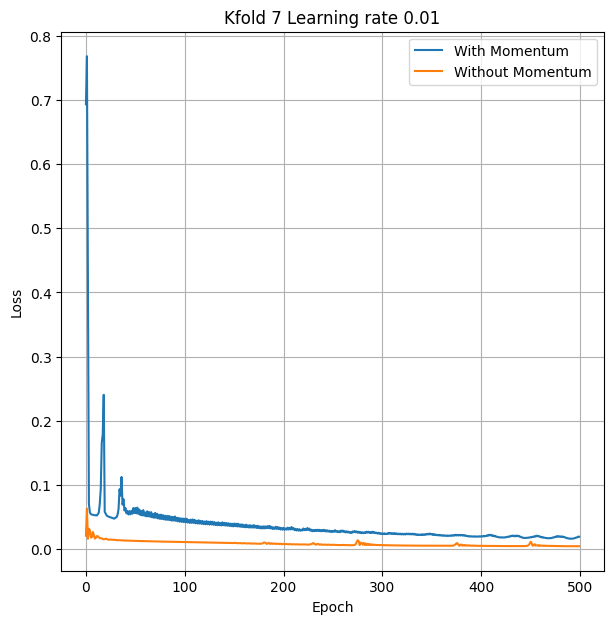

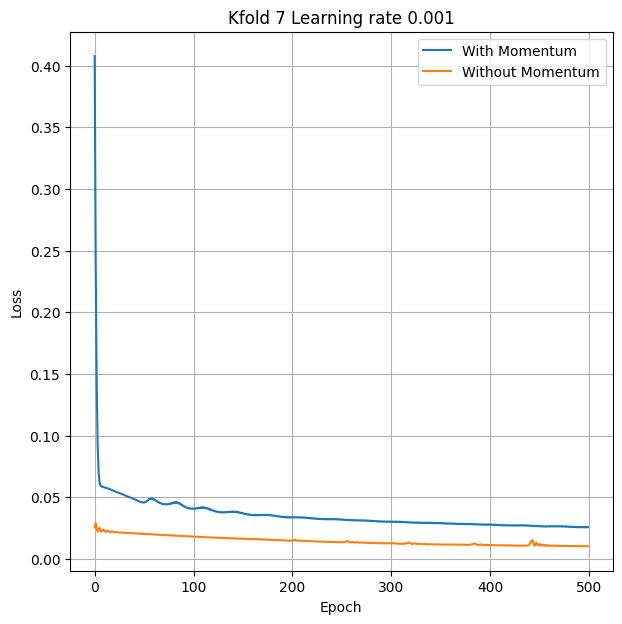

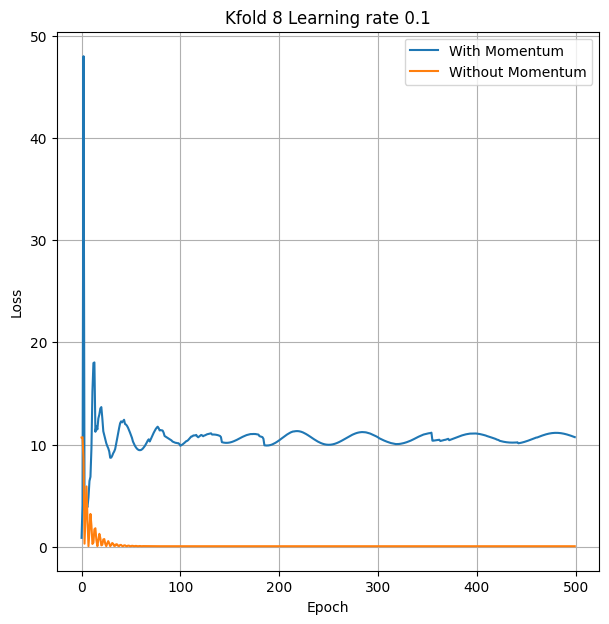

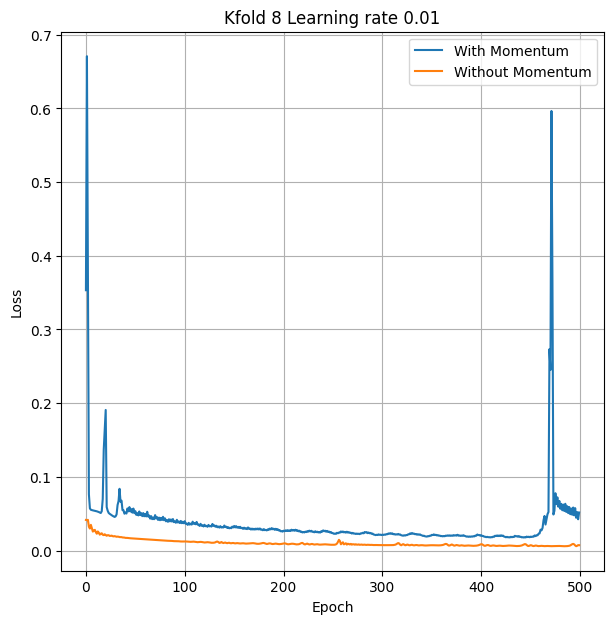

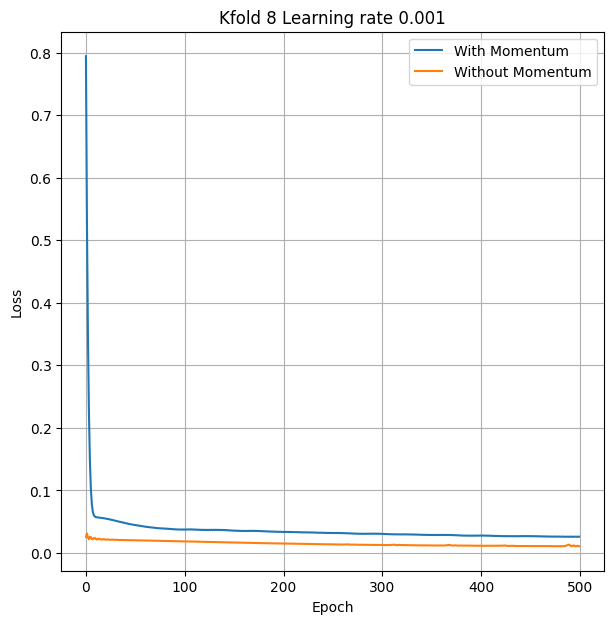

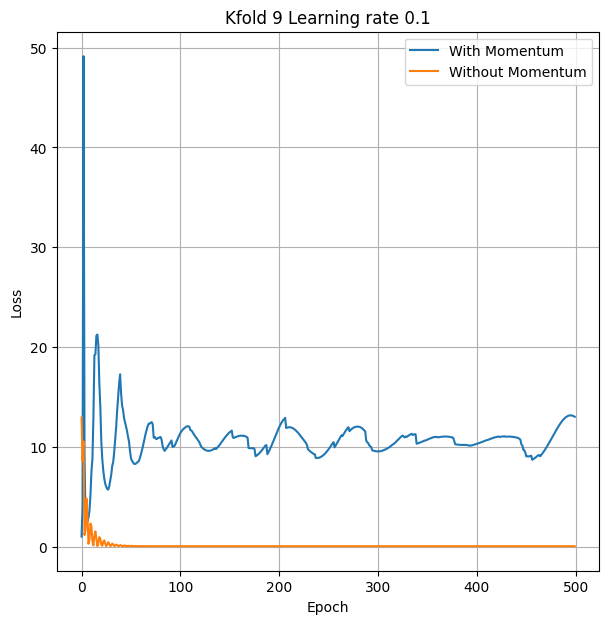

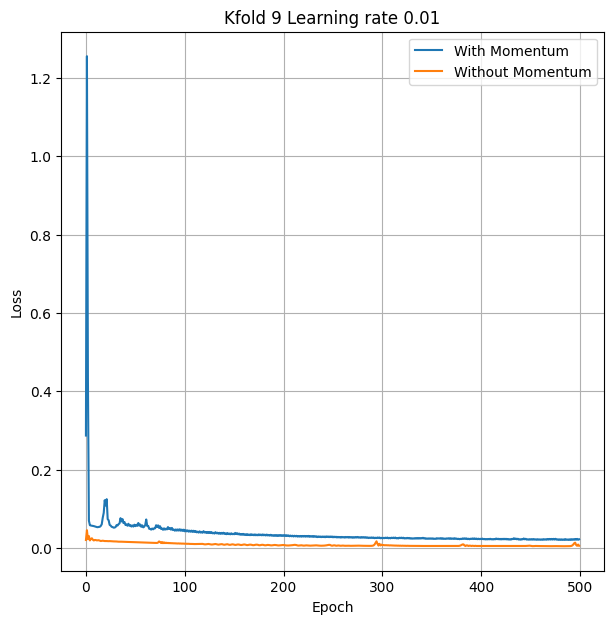

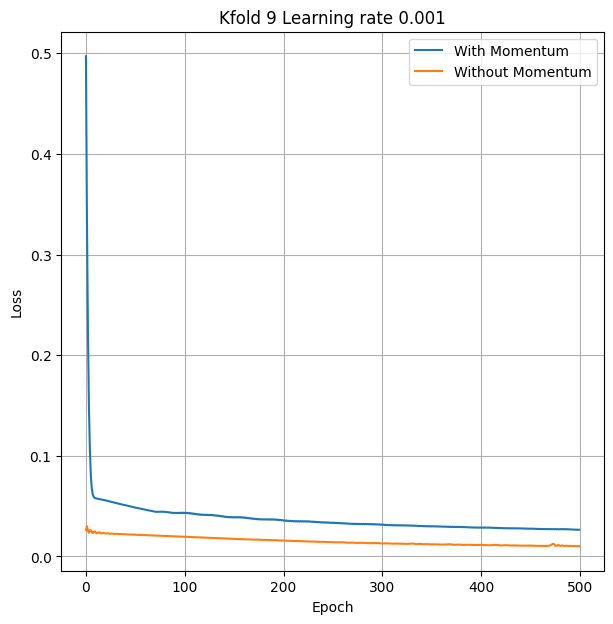

In [ ]:
x, y = x_ohencoded, y

# Create the KFold object
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True)

i = 0 # Tracking k-fold

# Loop over the folds
for train_index, test_index in kf.split(x):
    # Split the data into training and test sets for this fold
    x_fold_train= x.iloc[train_index]
    y_fold_train = y[train_index]
    x_fold_test= x.iloc[test_index]
    y_fold_test = y[test_index]

    # Convert to tensor
    X_train_tensor = torch.tensor(x_fold_train.values).float()
    y_train_tensor = torch.tensor(y_fold_train).float()

    loss_fn = nn.MSELoss()

    learn_rate = [0.1, 0.01, 0.001]

    for lr in learn_rate:
      model = AllThreeNN(X_train.shape[1], 64, 1)
      optimiser = optim.Adam(model.parameters(), lr=lr, betas=(0.0, 0.999))
      All_momentum = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)

      optimiser = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
      All_no_momentum = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)

      # Plot loss over epochs
      plt.figure(figsize=(7,7))
      plt.plot(range(epochs), All_momentum, label='With Momentum')
      plt.plot(range(epochs), All_no_momentum, label='Without Momentum')
      plt.title('Kfold '+str(i)+' Learning rate ' + str(lr))
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.grid(True)
      plt.legend()
      plt.show()

    i += 1

## Dropout

### Whole dataset

In [ ]:
loss_fn = nn.MSELoss()

print('Dropout after each hidden layer (MSE)')

model = DropoutNN(X_train.shape[1], 64, 1, 0.2)
optimiser = optim.Adam(model.parameters())
loss_1 = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
model.eval()
train_pred = model(X_train_tensor)
mse_train = mean_squared_error(y_train_tensor.detach().numpy(), train_pred.detach().numpy())
print('Dropout Probability 0.2: %s' %mse_train)

model = DropoutNN(X_train.shape[1], 64, 1, 0.5)
optimiser = optim.Adam(model.parameters())
loss_1 = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
model.eval()
train_pred = model(X_train_tensor)
mse_train = mean_squared_error(y_train_tensor.detach().numpy(), train_pred.detach().numpy())
print('Dropout Probability 0.5: %s' %mse_train)

model = DropoutNN(X_train.shape[1], 64, 1, 0.8)
optimiser = optim.Adam(model.parameters())
loss_1 = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
model.eval()
train_pred = model(X_train_tensor)
mse_train = mean_squared_error(y_train_tensor.detach().numpy(), train_pred.detach().numpy())
print('Dropout Probability 0.8: %s' %mse_train)

# ---------------------------------------------

print('Dropout after 1 hidden layer (MSE)')

model = OneDropoutNN(X_train.shape[1], 64, 1, 0.2)
optimiser = optim.Adam(model.parameters())
loss_1 = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
model.eval()
train_pred = model(X_train_tensor)
mse_train = mean_squared_error(y_train_tensor.detach().numpy(), train_pred.detach().numpy())
print('Dropout Probability 0.2: %s' %mse_train)

model = OneDropoutNN(X_train.shape[1], 64, 1, 0.5)
optimiser = optim.Adam(model.parameters())
loss_1 = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
model.eval()
train_pred = model(X_train_tensor)
mse_train = mean_squared_error(y_train_tensor.detach().numpy(), train_pred.detach().numpy())
print('Dropout Probability 0.5: %s' %mse_train)

model = OneDropoutNN(X_train.shape[1], 64, 1, 0.8)
optimiser = optim.Adam(model.parameters())
loss_1 = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
model.eval()
train_pred = model(X_train_tensor)
mse_train = mean_squared_error(y_train_tensor.detach().numpy(), train_pred.detach().numpy())
print('Dropout Probability 0.8: %s' %mse_train)


Dropout after each hidden layer (MSE)
Dropout Probability 0.2: 0.021157695
Dropout Probability 0.5: 0.028421612
Dropout Probability 0.8: 0.047540132
Dropout after 1 hidden layer (MSE)
Dropout Probability 0.2: 0.021367805
Dropout Probability 0.5: 0.020266632
Dropout Probability 0.8: 0.028620109


### K-fold

In [ ]:
x, y = x_ohencoded, y

# Initialize lists to store training and test MSE for each fold
mse_train_lst, mse_test_lst = [], []

# Create the KFold object
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True)

i = 0 # Tracking k-fold

# Loop over the folds
for train_index, test_index in kf.split(x):
    print('k-fold #%s'%i)
    # Split the data into training and test sets for this fold
    x_fold_train= x.iloc[train_index]
    y_fold_train = y[train_index]
    x_fold_test= x.iloc[test_index]
    y_fold_test = y[test_index]

    # Convert to tensor
    X_train_tensor = torch.tensor(x_fold_train.values).float()
    y_train_tensor = torch.tensor(y_fold_train).float()

    # Train the model on the training set for this fold
    loss_fn = nn.MSELoss()

    print('Dropout after each hidden layer (MSE)')

    model = DropoutNN(X_train.shape[1], 64, 1, 0.2)
    optimiser = optim.Adam(model.parameters())
    loss_1 = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
    model.eval()
    train_pred = model(X_train_tensor)
    mse_train = mean_squared_error(y_train_tensor.detach().numpy(), train_pred.detach().numpy())
    print('Dropout Probability 0.2: %s' %mse_train)

    model = DropoutNN(X_train.shape[1], 64, 1, 0.5)
    optimiser = optim.Adam(model.parameters())
    loss_1 = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
    model.eval()
    train_pred = model(X_train_tensor)
    mse_train = mean_squared_error(y_train_tensor.detach().numpy(), train_pred.detach().numpy())
    print('Dropout Probability 0.5: %s' %mse_train)

    model = DropoutNN(X_train.shape[1], 64, 1, 0.8)
    optimiser = optim.Adam(model.parameters())
    loss_1 = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
    model.eval()
    train_pred = model(X_train_tensor)
    mse_train = mean_squared_error(y_train_tensor.detach().numpy(), train_pred.detach().numpy())
    print('Dropout Probability 0.8: %s' %mse_train)

    # ---------------------------------------------

    print('Dropout after 1 hidden layer (MSE)')

    model = OneDropoutNN(X_train.shape[1], 64, 1, 0.2)
    optimiser = optim.Adam(model.parameters())
    loss_1 = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
    model.eval()
    train_pred = model(X_train_tensor)
    mse_train = mean_squared_error(y_train_tensor.detach().numpy(), train_pred.detach().numpy())
    print('Dropout Probability 0.2: %s' %mse_train)

    model = OneDropoutNN(X_train.shape[1], 64, 1, 0.5)
    optimiser = optim.Adam(model.parameters())
    loss_1 = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
    model.eval()
    train_pred = model(X_train_tensor)
    mse_train = mean_squared_error(y_train_tensor.detach().numpy(), train_pred.detach().numpy())
    print('Dropout Probability 0.5: %s' %mse_train)

    model = OneDropoutNN(X_train.shape[1], 64, 1, 0.8)
    optimiser = optim.Adam(model.parameters())
    loss_1 = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
    model.eval()
    train_pred = model(X_train_tensor)
    mse_train = mean_squared_error(y_train_tensor.detach().numpy(), train_pred.detach().numpy())
    print('Dropout Probability 0.8: %s' %mse_train)
    print('')

    i += 1

k-fold #0
Dropout after each hidden layer (MSE)
Dropout Probability 0.2: 0.020220868
Dropout Probability 0.5: 0.026784537
Dropout Probability 0.8: 0.051124595
Dropout after 1 hidden layer (MSE)
Dropout Probability 0.2: 0.014299275
Dropout Probability 0.5: 0.019491501
Dropout Probability 0.8: 0.033077702

k-fold #1
Dropout after each hidden layer (MSE)
Dropout Probability 0.2: 0.02002842
Dropout Probability 0.5: 0.0293922
Dropout Probability 0.8: 0.048968837
Dropout after 1 hidden layer (MSE)
Dropout Probability 0.2: 0.018626288
Dropout Probability 0.5: 0.020300476
Dropout Probability 0.8: 0.023469826

k-fold #2
Dropout after each hidden layer (MSE)
Dropout Probability 0.2: 0.019837476
Dropout Probability 0.5: 0.028356174
Dropout Probability 0.8: 0.04885127
Dropout after 1 hidden layer (MSE)
Dropout Probability 0.2: 0.016965581
Dropout Probability 0.5: 0.018688364
Dropout Probability 0.8: 0.028559351

k-fold #3
Dropout after each hidden layer (MSE)
Dropout Probability 0.2: 0.021530032
D

## Combined Model

### Whole dataset

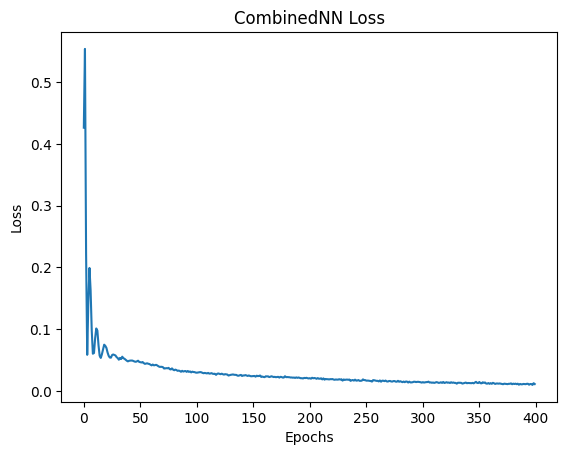

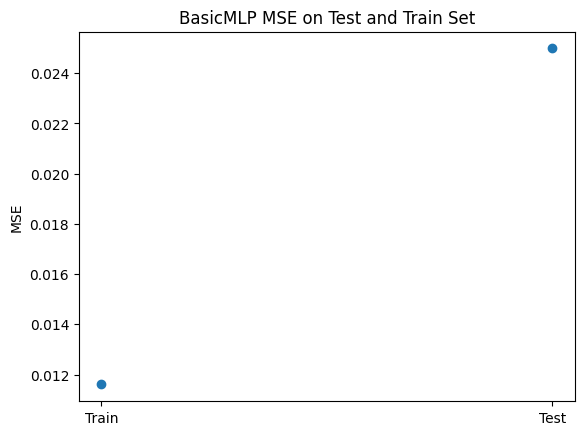

In [ ]:
loss_fn = nn.MSELoss()
epochs = 400

# Training w/ default parameters or Optimizer
model = CombinedNN(X_train.shape[1], 64, 1)
optimiser = optim.Adam(model.parameters(), lr=0.01)
mse_lst = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)

plt.plot(range(epochs), mse_lst)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CombinedNN Loss')
plt.show()

train_pred = model(X_train_tensor)
mse_train = mean_squared_error(y_train_tensor.detach().numpy(), train_pred.detach().numpy())

test_pred = model(X_test_tensor)
mse_test = mean_squared_error(y_test_tensor.detach().numpy(), test_pred.detach().numpy())

plt.scatter(['Train', 'Test'], [mse_train, mse_test])
plt.ylabel('MSE')
plt.title('BasicMLP MSE on Test and Train Set')
plt.show()


### K-fold

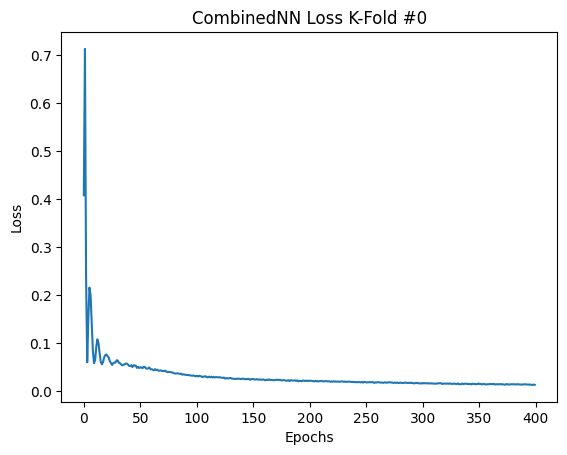

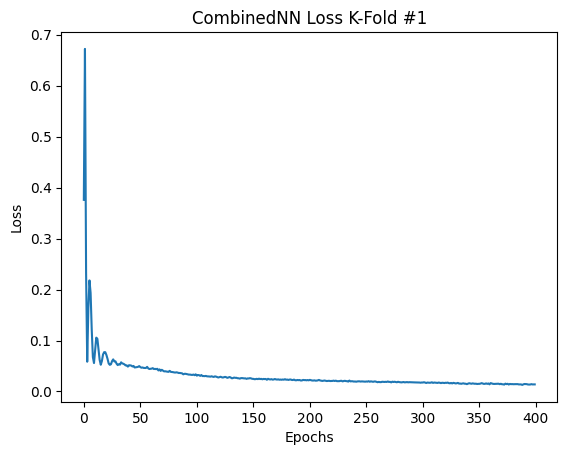

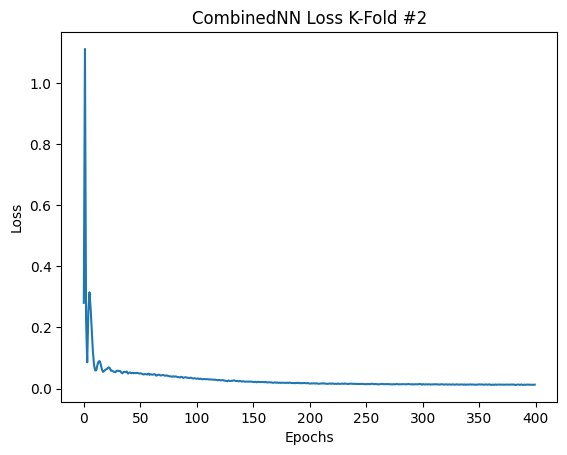

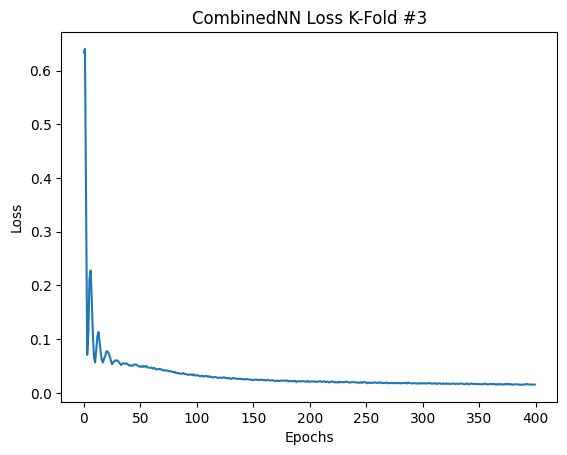

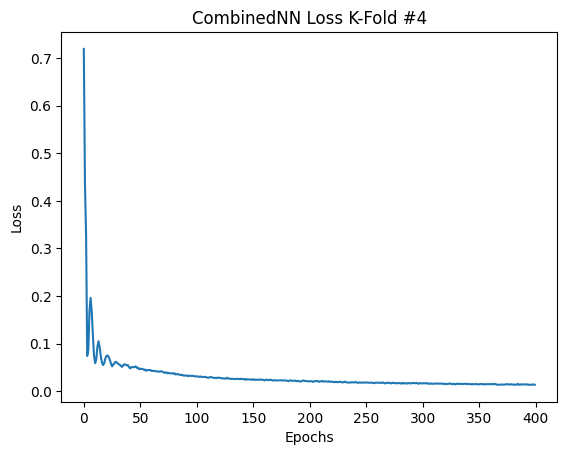

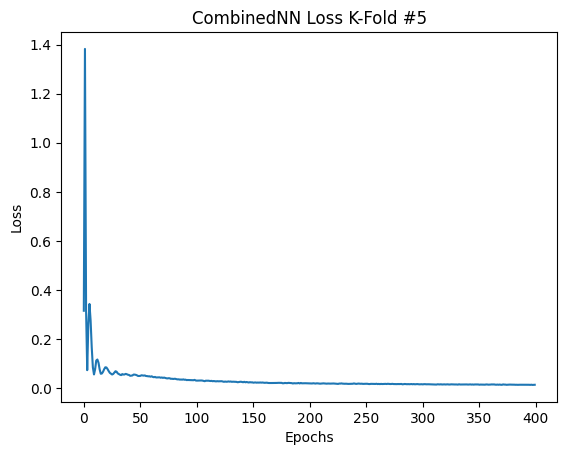

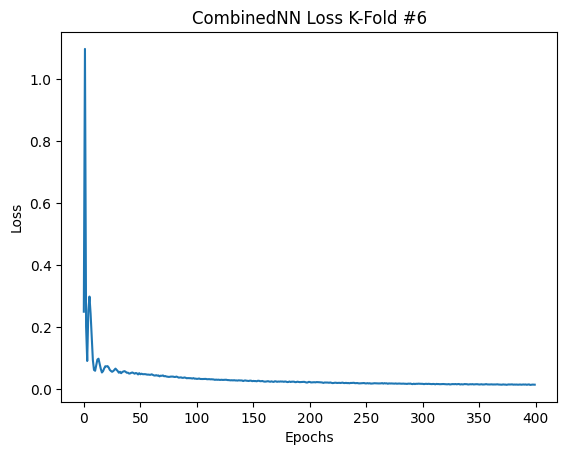

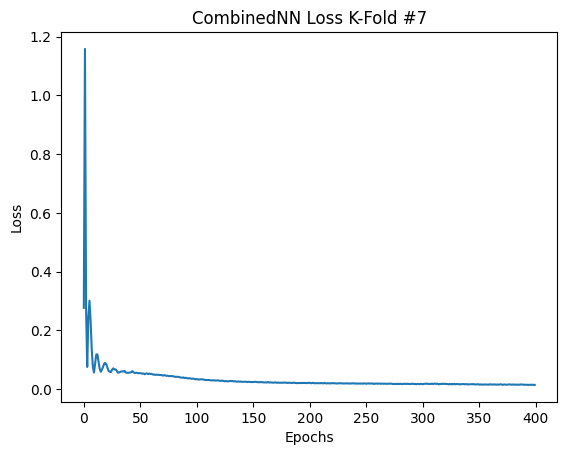

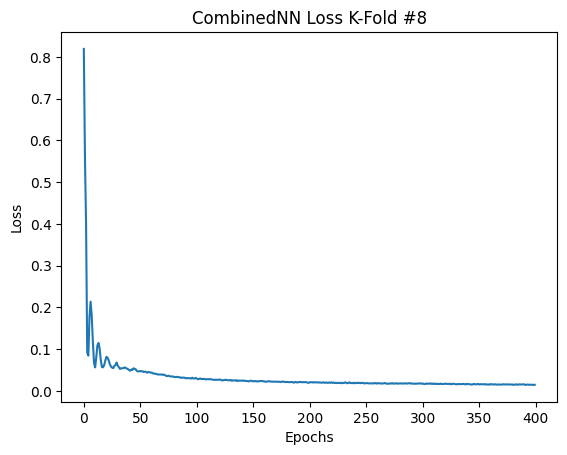

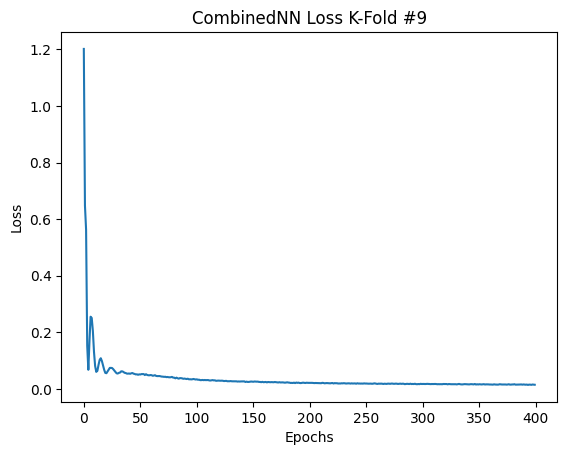

In [ ]:
x, y = x_ohencoded, y

# Initialize lists to store training and test MSE for each fold
mse_train_lst, mse_test_lst = [], []

# Create the KFold object
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True)

i = 0 # Tracking k-fold

# Loop over the folds
for train_index, test_index in kf.split(x):
    # Split the data into training and test sets for this fold
    x_fold_train= x.iloc[train_index]
    y_fold_train = y[train_index]
    x_fold_test= x.iloc[test_index]
    y_fold_test = y[test_index]

    # Convert to tensor
    X_train_tensor = torch.tensor(x_fold_train.values).float()
    y_train_tensor = torch.tensor(y_fold_train).float()

    # Train the model on the training set for this fold
    model = CombinedNN(x_fold_train.shape[1], 64, 1)
    optimiser = optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()
    epochs = 400
    epoch_lst = range(epochs)

    mse_lst = trainRegression(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)

    # Plot loss curve
    plt.plot(epoch_lst, mse_lst)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('CombinedNN Loss K-Fold #%s' % i)
    plt.show()

    # Evaluate model
    train_pred = model(X_train_tensor)
    mse_train = mean_squared_error(y_train_tensor.detach().numpy(), train_pred.detach().numpy())

    test_pred = model(X_test_tensor)
    mse_test = mean_squared_error(y_test_tensor.detach().numpy(), test_pred.detach().numpy())

    # Save mse to lists
    mse_train_lst.append(mse_train)
    mse_test_lst.append(mse_test)

    i += 1

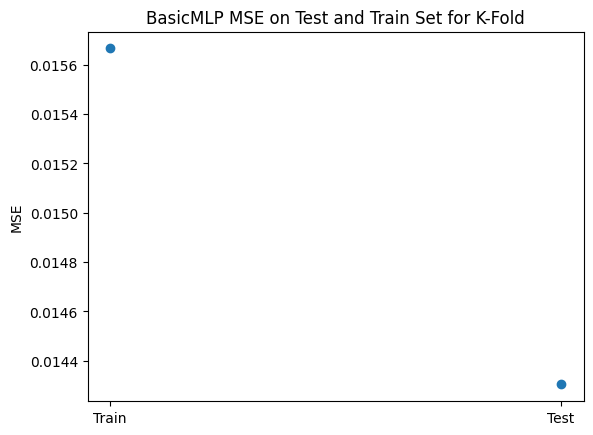

In [ ]:
# MSE Plot
# Get mean from data
train_mse_mean = np.mean(mse_train_lst)
test_mse_mean = np.mean(mse_test_lst)

plt.scatter(['Train', 'Test'], [mse_train, mse_test])
plt.ylabel('MSE')
plt.title('BasicMLP MSE on Test and Train Set for K-Fold')

plt.show()

# **Classification Neural Network**

## Preprocessing

### Loading Dataset

In [ ]:
# Reading in data
# data = Path(r'./Cell viability and extrusion dataset V1.csv')
data = Path(r'/content/Cell viability and extrusion dataset V1.csv')
bioprint_df = pd.read_csv(data)

#Setting references column in bioprint_df as the row indices
bioprint_df = bioprint_df.set_index(bioprint_df['Reference'])
bioprint_df = bioprint_df.drop(['Reference', 'DOI'], axis = 1)

# Removing comment from numeric column
col_fix = "Fiber_Diameter_(µm)"
bioprint_df[col_fix] = bioprint_df[col_fix].str.replace(r' \(.*\)', "", regex=True).astype('float64')

### Imputing mode temperatures

In [ ]:
imputer_mode = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent') #imputing mode value into missing values for temperatures
bioprint_df.loc[:,['Syringe_Temperature_(°C)','Substrate_Temperature_(°C)']] = imputer_mode.fit_transform(bioprint_df.loc[:,['Syringe_Temperature_(°C)','Substrate_Temperature_(°C)']])

### Dropping Numerical Data

In [ ]:
#Variables where more than 50% of all instances have null values are dropped
#This amounts to variables with 309 or more null instances for the cell viability dataset with 617 instances
bioprint_df = bioprint_df.dropna(axis = 1, thresh=309)

#Drop instances without cell viability values
bioprint_df = bioprint_df[bioprint_df['Viability_at_time_of_observation_(%)'].notna()]

#Drop nonprinting instances (instances were extrusion pressure is zero)
bioprint_df = bioprint_df.drop(bioprint_df[bioprint_df['Extrusion_Pressure (kPa)'] == 0 ].index)
bioprint_df = bioprint_df[bioprint_df['Extrusion_Pressure (kPa)'].notna()]

### Feature Selection w/ Correlation

In [ ]:
# corr = bioprint_df.corr()
# display(corr)
# fig, ax = plt.subplots(figsize = (20, 16))
# sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, linewidths=0.1)
# abs(bioprint_df.corr()["Viability_at_time_of_observation_(%)"])

#Drop for cell viability, extrusion pressure, and Intrastudy dataset creation
bioprint_df = bioprint_df.drop(['Final_PEGTA_Conc_(%w/v)','Final_PEGMA_Conc_(%w/v)'], axis = 1)

### Imputation of Numerical and Categorical Data

In [ ]:
# Imputation of numerical data
imputer_knn = KNNImputer(n_neighbors = 30, weights = "uniform") #imputing mode value into missing values
bioprint_df.iloc[:,0:28] = imputer_knn.fit_transform(bioprint_df.iloc[:,0:28]) #used for cell viability dataset preprocessing 170

# Imputation of categorical data
bioprint_df = bioprint_df.fillna(bioprint_df['Conical_or_Straight_Nozzle'].value_counts().index[0])

#Drop categorical or numerical cell viability column depending on which type of prediction model is desired (regression versus classification)
bioprint_df = bioprint_df.drop(["Acceptable_Viability_(Yes/No)", 'Acceptable_Pressure_(Yes/No)'], axis = 1)
bioprint_df = bioprint_df.drop(['Extrusion_Pressure (kPa)'], axis = 1)

### Normalizing and Encoding

In [ ]:
x = bioprint_df.drop("Viability_at_time_of_observation_(%)", axis = 1)
y = bioprint_df["Viability_at_time_of_observation_(%)"]

#Use MinMaxScaler() function to normalize input values for performance metric evaluation. DO NOT USE for value prediction for cell viability and extrusion pressure
x.iloc[:,0:28] = MinMaxScaler().fit_transform(x.iloc[:,0:28]) # Used for cell viability generalized dataset 171

x_ohencoded = pd.get_dummies(x, columns=['Cell_Culture_Medium_Used?','DI_Water_Used?','Precrosslinking_Solution_Used?','Saline_Solution_Used?','EtOH_Solution_Used?','Photoinitiator_Used?','Enzymatic_Crosslinker_Used?','Matrigel_Used?','Conical_or_Straight_Nozzle','Primary/Not_Primary'], dtype=float) #one-hot encoding is used to encode binary/categorical data in datasets

y = y.apply(lambda f: 1 if f > 70 else 0).astype(float)

## Set up Functions

In [ ]:
def compute_acc_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    # precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    return {"Accuracy": acc, "F1 Score": f1, "Recall": recall}

In [ ]:
# Training function
def trainClassification(model, optimiser, loss_fn, epochs, X_train, y_train):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    loss_fn = loss_fn.to(device)
    loss_lst = []
    metric_lst = []
    accuracy = []

    for epoch in range(epochs):
        # Transfer data to `device`
        inputs, labels = X_train.to(device), y_train.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = loss_fn(outputs, labels)
        loss_lst.append(loss.item())

        loss.backward() # Compute gradients
        optimiser.step() # Update weights
        optimiser.zero_grad(set_to_none=True) # Reset gradients for next iteration


        preds = F.softmax(outputs, dim=1).argmax(dim=1)
        train_metrics = compute_acc_metrics(labels, preds)
        metric_lst.append(train_metrics)
        accuracy.append(train_metrics['Accuracy'])

        if epoch % 100 == 0:
            print(f"Epoch {epoch} - Loss: {loss}")
            print(train_metrics)


    return loss_lst, metric_lst, accuracy

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x_ohencoded.values, y.values, test_size=0.15, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).long()

## Default NN

### Whole dataset

Epoch 0 - Loss: 0.7844498753547668
{'Accuracy': 0.3333333333333333, 'F1 Score': 0.17488611606258664, 'Recall': 0.3333333333333333}
Epoch 50 - Loss: 0.5326259136199951
{'Accuracy': 0.74, 'F1 Score': 0.6896663135593221, 'Recall': 0.74}
Epoch 100 - Loss: 0.4286751449108124
{'Accuracy': 0.83, 'F1 Score': 0.8277613911512217, 'Recall': 0.83}
Epoch 150 - Loss: 0.37190377712249756
{'Accuracy': 0.8666666666666667, 'F1 Score': 0.8666666666666667, 'Recall': 0.8666666666666667}
Epoch 200 - Loss: 0.328978955745697
{'Accuracy': 0.8766666666666667, 'F1 Score': 0.876162662898414, 'Recall': 0.8766666666666667}
Epoch 250 - Loss: 0.29565176367759705
{'Accuracy': 0.89, 'F1 Score': 0.8906789361463359, 'Recall': 0.89}
Epoch 300 - Loss: 0.2710440456867218
{'Accuracy': 0.89, 'F1 Score': 0.8906789361463359, 'Recall': 0.89}
Epoch 350 - Loss: 0.25203555822372437
{'Accuracy': 0.8933333333333333, 'F1 Score': 0.8941134716486725, 'Recall': 0.8933333333333333}
Epoch 400 - Loss: 0.2367464154958725
{'Accuracy': 0.90333

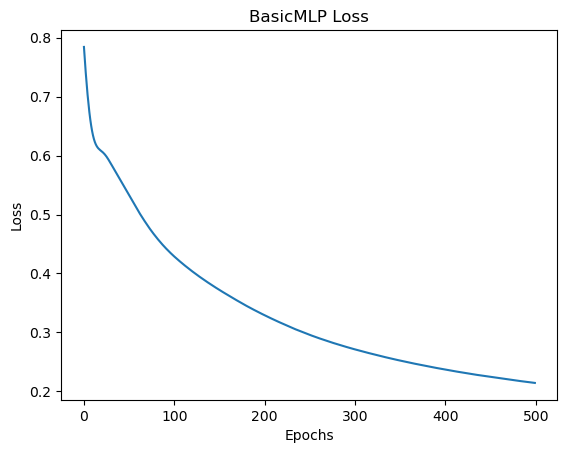

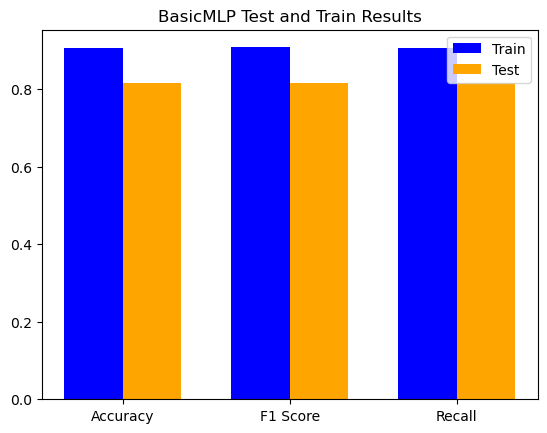

In [ ]:
loss_fn = nn.CrossEntropyLoss()
epochs = 500

# Training w/ default parameters or Optimizer
num_classes = len(y.unique())
model = BasicMLP(X_train.shape[1], 64, num_classes)
optimiser = optim.Adam(model.parameters())
loss_lst = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)

plt.plot(range(epochs), loss_lst[0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('BasicMLP Loss')
plt.show()

model.eval()
# Evaluate on train
train_pred = model(X_train_tensor)
pred = F.softmax(train_pred, dim=1).argmax(dim=1)
train_dict = compute_acc_metrics(y_train_tensor.detach().numpy(), pred)

# Evaluate on test
test_pred = model(X_test_tensor)
pred = F.softmax(test_pred, dim=1).argmax(dim=1)
test_dict = compute_acc_metrics(y_test_tensor.detach().numpy(), pred)

# Get values
keys = ['Accuracy', 'F1 Score', 'Recall']
train_val = list(train_dict.values())
test_val = list(test_dict.values())

# bar positions and width
x = np.arange(len(keys))  # label locations
width = 0.35  # width of the bars

# Plotting the bars
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, train_val, width, label='Train', color='blue')
bars2 = ax.bar(x + width/2, test_val, width, label='Test', color='orange')

# Add labels and title
ax.set_title("BasicMLP Test and Train Results")
ax.set_xticks(x)
ax.set_xticklabels(keys)
ax.legend()

# Show plot
plt.show()

### K-Fold

In [ ]:
x, y = x_ohencoded, y

# Initialize lists to store training and test MSE for each fold
train_metrics = []
accuracy_lst, test_acc = [], []

# Create the KFold object
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True)

i = 0 # Tracking k-fold

# Loop over the folds
for train_index, test_index in kf.split(x):
    # Split the data into training and test sets for this fold
    x_fold_train= x.iloc[train_index]
    y_fold_train = y[train_index]
    x_fold_test= x.iloc[test_index]
    y_fold_test = y[test_index]

    # Convert to tensor
    X_train_tensor = torch.tensor(x_fold_train.values).float()
    y_train_tensor = torch.tensor(y_fold_train).long()
    X_test_tensor = torch.tensor(x_fold_test.values).float()
    y_test_tensor = torch.tensor(y_fold_test).long()

    # Train the model on the training set for this fold
    num_classes = len(y.unique())
    model = BasicMLP(x_fold_train.shape[1], 64, num_classes)
    optimiser = optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    epochs = 500
    epoch_lst = range(epochs)

    loss_lst, train_metrics, acc = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)

    accuracy_lst.append(np.mean(acc))

    model.eval()
    test_pred = model(X_test_tensor)
    pred = F.softmax(test_pred, dim=1).argmax(dim=1)
    test_dict = compute_acc_metrics(y_test_tensor.detach().numpy(), pred)
    test_acc.append(test_dict['Accuracy'])
    i += 1

Epoch 0 - Loss: 0.6437458395957947
{'Accuracy': 0.6635220125786163, 'F1 Score': 0.5318210459987397, 'Recall': 0.6635220125786163}
Epoch 100 - Loss: 0.3945656716823578
{'Accuracy': 0.8490566037735849, 'F1 Score': 0.8474945533769062, 'Recall': 0.8490566037735849}
Epoch 200 - Loss: 0.27944743633270264
{'Accuracy': 0.8805031446540881, 'F1 Score': 0.8792665214233841, 'Recall': 0.8805031446540881}
Epoch 300 - Loss: 0.2310948222875595
{'Accuracy': 0.9025157232704403, 'F1 Score': 0.9026293299592669, 'Recall': 0.9025157232704403}
Epoch 400 - Loss: 0.2046242505311966
{'Accuracy': 0.9088050314465409, 'F1 Score': 0.9091163527223849, 'Recall': 0.9088050314465409}
Epoch 0 - Loss: 0.8838024139404297
{'Accuracy': 0.33962264150943394, 'F1 Score': 0.17220302949774116, 'Recall': 0.33962264150943394}
Epoch 100 - Loss: 0.4703226685523987
{'Accuracy': 0.8207547169811321, 'F1 Score': 0.8118971835492774, 'Recall': 0.8207547169811321}
Epoch 200 - Loss: 0.3654545843601227
{'Accuracy': 0.8584905660377359, 'F1 Sc

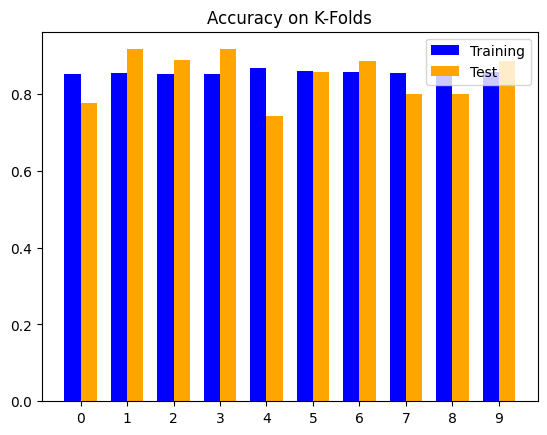

In [ ]:
x = np.arange(10)
width = 0.35  # the width of the bars

# Plotting the bars
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, accuracy_lst, width, label='Training', color='blue')
bars2 = ax.bar(x + width/2, test_acc, width, label='Test', color='orange')

# Add labels, title, and custom x-axis tick labels
ax.set_xticks(x)
ax.set_xticklabels(range(10))
ax.legend()
ax.set_title('Accuracy on K-Folds')

# Show plot
plt.show()


## Different Activation Functions

### Whole dataset

In [ ]:
loss_fn = nn.CrossEntropyLoss()
epochs = 500

print('Sigmoid and ReLU')
num_classes = len(y.unique())
model = SigmoidReLUNN(X_train.shape[1], 64, num_classes)
optimiser = optim.Adam(model.parameters())
S_R_lst, S_R_metrics, S_R_acc = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
S_R_acc = np.mean(S_R_acc)
# ---------------------------------------------

print('All three')
num_classes = len(y.unique())
model = AllThreeNN(X_train.shape[1], 64, num_classes)
optimiser = optim.Adam(model.parameters())
All_lst, All_metrics, All_acc = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
All_acc = np.mean(All_acc)

# ---------------------------------------------
print('Tanh and ReLU')
num_classes = len(y.unique())
model = TanhReLUNN(X_train.shape[1], 64, num_classes)
optimiser = optim.Adam(model.parameters())
T_R_lst, T_R_metrics, T_R_acc = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
T_R_acc = np.mean(T_R_acc)

Sigmoid and ReLU
Epoch 0 - Loss: 0.727489173412323
{'Accuracy': 0.32666666666666666, 'F1 Score': 0.1608710217755444, 'Recall': 0.32666666666666666}
Epoch 100 - Loss: 0.5391414165496826
{'Accuracy': 0.6733333333333333, 'F1 Score': 0.5418857901726427, 'Recall': 0.6733333333333333}
Epoch 200 - Loss: 0.3971060812473297
{'Accuracy': 0.8233333333333334, 'F1 Score': 0.823562536475587, 'Recall': 0.8233333333333334}
Epoch 300 - Loss: 0.3126757740974426
{'Accuracy': 0.8833333333333333, 'F1 Score': 0.8845651950190387, 'Recall': 0.8833333333333333}
Epoch 400 - Loss: 0.25967732071876526
{'Accuracy': 0.8866666666666667, 'F1 Score': 0.8879792354574277, 'Recall': 0.8866666666666667}
All three
Epoch 0 - Loss: 0.6884706616401672
{'Accuracy': 0.62, 'F1 Score': 0.5573685221958875, 'Recall': 0.62}
Epoch 100 - Loss: 0.3573649823665619
{'Accuracy': 0.8666666666666667, 'F1 Score': 0.8655370132648695, 'Recall': 0.8666666666666667}
Epoch 200 - Loss: 0.17949633300304413
{'Accuracy': 0.9066666666666666, 'F1 Score

In [ ]:
print('Sigmoid and ReLU: %s' % S_R_acc)
print('All three: %s' % All_acc)
print('Tanh and ReLU: %s' % T_R_acc)


Sigmoid and ReLU: 0.8300940438871474
All three: 0.8802068965517242
Tanh and ReLU: 0.8783573667711598


### K-fold

In [ ]:
x, y = x_ohencoded, y

# Initialize lists to store training and test MSE for each fold
SR_lst, TR_lst, All_lst = [], [], []

# Create the KFold object
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True)

i = 0 # Tracking k-fold

# Loop over the folds
for train_index, test_index in kf.split(x):
    # Split the data into training and test sets for this fold
    x_fold_train= x.iloc[train_index]
    y_fold_train = y[train_index]
    x_fold_test= x.iloc[test_index]
    y_fold_test = y[test_index]

    # Convert to tensor
    X_train_tensor = torch.tensor(x_fold_train.values).float()
    y_train_tensor = torch.tensor(y_fold_train).long()
    X_test_tensor = torch.tensor(x_fold_test.values).float()
    y_test_tensor = torch.tensor(y_fold_test).long()

    # Train the model on the training set for this fold
    loss_fn = nn.CrossEntropyLoss()
    epochs = 500

    print('Sigmoid and ReLU')
    num_classes = len(y.unique())
    model = SigmoidReLUNN(X_train.shape[1], 64, num_classes)
    optimiser = optim.Adam(model.parameters())
    S_R_lst, S_R_metrics, S_R_acc = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
    S_R_acc = np.mean(S_R_acc)
    SR_lst.append(S_R_acc)
    # ---------------------------------------------

    print('All three')
    num_classes = len(y.unique())
    model = AllThreeNN(X_train.shape[1], 64, num_classes)
    optimiser = optim.Adam(model.parameters())
    All_lst, All_metrics, All_acc = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
    All_acc = np.mean(All_acc)
    All_lst.append(All_acc)

    # ---------------------------------------------
    print('Tanh and ReLU')
    num_classes = len(y.unique())
    model = TanhReLUNN(X_train.shape[1], 64, num_classes)
    optimiser = optim.Adam(model.parameters())
    T_R_lst, T_R_metrics, T_R_acc = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
    T_R_acc = np.mean(T_R_acc)
    TR_lst.append(T_R_acc)

Sigmoid and ReLU
Epoch 0 - Loss: 0.7313969135284424
{'Accuracy': 0.3333333333333333, 'F1 Score': 0.16666666666666666, 'Recall': 0.3333333333333333}
Epoch 100 - Loss: 0.5534486770629883
{'Accuracy': 0.6666666666666666, 'F1 Score': 0.5333333333333334, 'Recall': 0.6666666666666666}
Epoch 200 - Loss: 0.41059985756874084
{'Accuracy': 0.8050314465408805, 'F1 Score': 0.8067016317016318, 'Recall': 0.8050314465408805}
Epoch 300 - Loss: 0.29363110661506653
{'Accuracy': 0.8742138364779874, 'F1 Score': 0.8747795414462081, 'Recall': 0.8742138364779874}
Epoch 400 - Loss: 0.2483915388584137
{'Accuracy': 0.8836477987421384, 'F1 Score': 0.8842940363457724, 'Recall': 0.8836477987421384}
All three
Epoch 0 - Loss: 0.6997222900390625
{'Accuracy': 0.36163522012578614, 'F1 Score': 0.2338794268721276, 'Recall': 0.36163522012578614}
Epoch 100 - Loss: 0.36512860655784607
{'Accuracy': 0.8427672955974843, 'F1 Score': 0.8441142191142192, 'Recall': 0.8427672955974843}
Epoch 200 - Loss: 0.18144457042217255
{'Accurac

In [ ]:
print('Sigmoid and ReLU: %s' % SR_lst)
print('All three: %s' % All_lst)
print('Tanh and ReLU: %s' % TR_lst)

Sigmoid and ReLU: [0.810446540880503, 0.8325283018867924, 0.8306540880503144, 0.8269811320754719, 0.7899247648902822, 0.8397805642633229, 0.8197868338557994, 0.8122068965517242, 0.8231410658307211, 0.8239937304075236]
All three: [0.7166414260864258, 0.6785823106765747, 0.6536656618118286, 0.6408952474594116, 0.637936532497406, 0.6411059498786926, 0.6461849212646484, 0.6499363780021667, 0.650976836681366, 0.6493911743164062, 0.6459954977035522, 0.641812801361084, 0.637763500213623, 0.6345093250274658, 0.6324009895324707, 0.6314651966094971, 0.6314454078674316, 0.6319038271903992, 0.632361888885498, 0.6324329972267151, 0.6319035887718201, 0.6307579874992371, 0.6291393637657166, 0.6272717118263245, 0.6254127025604248, 0.6237621903419495, 0.6224179863929749, 0.6213788986206055, 0.6205508708953857, 0.6197718977928162, 0.6188800930976868, 0.6177499890327454, 0.6163313984870911, 0.6146367788314819, 0.6127645373344421, 0.6108150482177734, 0.6088786125183105, 0.6069921851158142, 0.6051479578018

## Learning Rates and Momentum

### Whole dataset

Epoch 0 - Loss: 0.7007898688316345
{'Accuracy': 0.32666666666666666, 'F1 Score': 0.1608710217755444, 'Recall': 0.32666666666666666}
Epoch 100 - Loss: 2.5704879760742188
{'Accuracy': 0.32666666666666666, 'F1 Score': 0.1608710217755444, 'Recall': 0.32666666666666666}
Epoch 200 - Loss: 4.774876117706299
{'Accuracy': 0.6733333333333333, 'F1 Score': 0.5418857901726427, 'Recall': 0.6733333333333333}
Epoch 300 - Loss: 1.767422080039978
{'Accuracy': 0.6733333333333333, 'F1 Score': 0.5418857901726427, 'Recall': 0.6733333333333333}
Epoch 400 - Loss: 2.526989221572876
{'Accuracy': 0.32666666666666666, 'F1 Score': 0.1608710217755444, 'Recall': 0.32666666666666666}
Epoch 0 - Loss: 4.786744117736816
{'Accuracy': 0.6733333333333333, 'F1 Score': 0.5418857901726427, 'Recall': 0.6733333333333333}
Epoch 100 - Loss: 0.6318923234939575
{'Accuracy': 0.6733333333333333, 'F1 Score': 0.5418857901726427, 'Recall': 0.6733333333333333}
Epoch 200 - Loss: 0.6317928433418274
{'Accuracy': 0.6733333333333333, 'F1 Scor

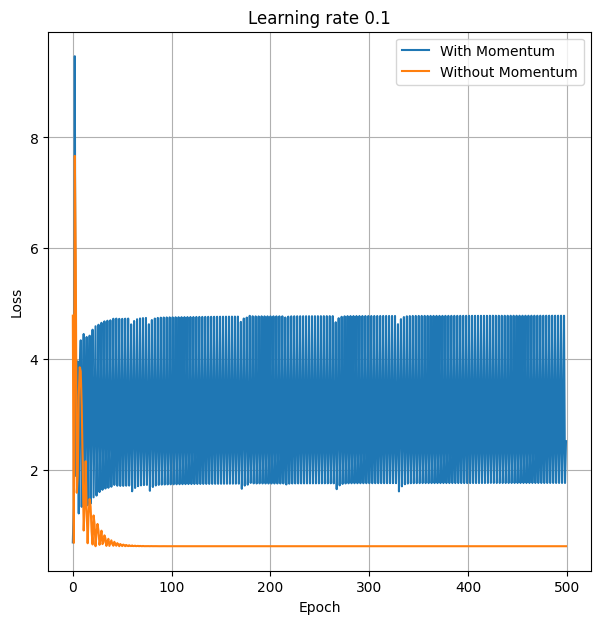

Epoch 0 - Loss: 0.7092167139053345
{'Accuracy': 0.32666666666666666, 'F1 Score': 0.1608710217755444, 'Recall': 0.32666666666666666}
Epoch 100 - Loss: 0.3365083336830139
{'Accuracy': 0.8533333333333334, 'F1 Score': 0.8444066532408444, 'Recall': 0.8533333333333334}
Epoch 200 - Loss: 0.22772257030010223
{'Accuracy': 0.89, 'F1 Score': 0.8869974389256757, 'Recall': 0.89}
Epoch 300 - Loss: 0.1854807734489441
{'Accuracy': 0.9133333333333333, 'F1 Score': 0.9128553921568628, 'Recall': 0.9133333333333333}
Epoch 400 - Loss: 0.17467105388641357
{'Accuracy': 0.9166666666666666, 'F1 Score': 0.9163261235800096, 'Recall': 0.9166666666666666}
Epoch 0 - Loss: 0.17524629831314087
{'Accuracy': 0.92, 'F1 Score': 0.9207605466428996, 'Recall': 0.92}
Epoch 100 - Loss: 0.13445889949798584
{'Accuracy': 0.9266666666666666, 'F1 Score': 0.9266666666666666, 'Recall': 0.9266666666666666}
Epoch 200 - Loss: 0.11882857233285904
{'Accuracy': 0.94, 'F1 Score': 0.9403000000000001, 'Recall': 0.94}
Epoch 300 - Loss: 0.11122

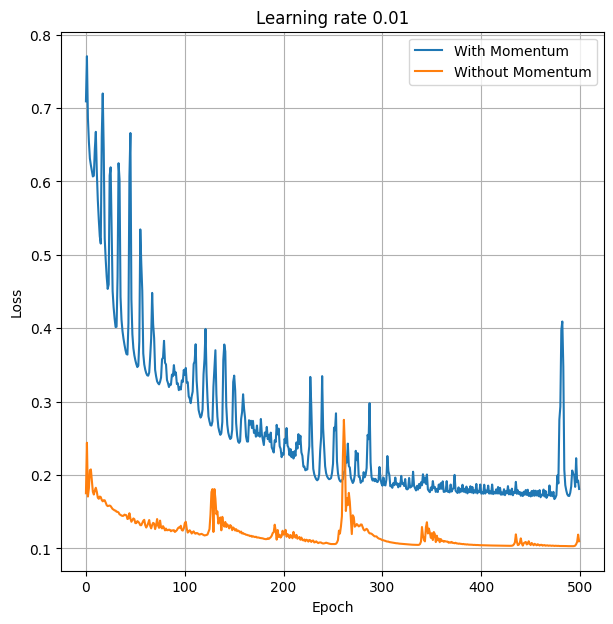

Epoch 0 - Loss: 0.6811653971672058
{'Accuracy': 0.6733333333333333, 'F1 Score': 0.5418857901726427, 'Recall': 0.6733333333333333}
Epoch 100 - Loss: 0.3631918430328369
{'Accuracy': 0.87, 'F1 Score': 0.8713726458783575, 'Recall': 0.87}
Epoch 200 - Loss: 0.27673500776290894
{'Accuracy': 0.8933333333333333, 'F1 Score': 0.894568692195226, 'Recall': 0.8933333333333333}
Epoch 300 - Loss: 0.2409626841545105
{'Accuracy': 0.9, 'F1 Score': 0.9011581489330244, 'Recall': 0.9}
Epoch 400 - Loss: 0.2217952162027359
{'Accuracy': 0.9066666666666666, 'F1 Score': 0.9077476056708228, 'Recall': 0.9066666666666666}
Epoch 0 - Loss: 0.21003954112529755
{'Accuracy': 0.9166666666666666, 'F1 Score': 0.9177145947806419, 'Recall': 0.9166666666666666}
Epoch 100 - Loss: 0.160760760307312
{'Accuracy': 0.93, 'F1 Score': 0.930432050274941, 'Recall': 0.93}
Epoch 200 - Loss: 0.1425035148859024
{'Accuracy': 0.9333333333333333, 'F1 Score': 0.9336666666666665, 'Recall': 0.9333333333333333}
Epoch 300 - Loss: 0.132138654589653

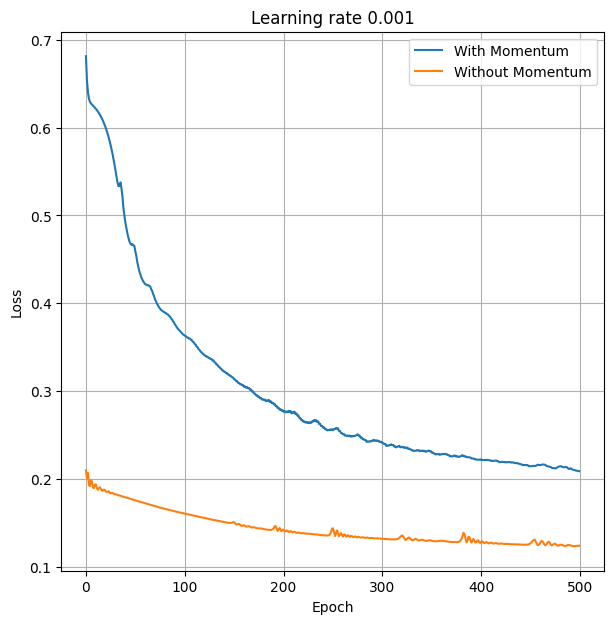

In [ ]:
loss_fn = nn.CrossEntropyLoss()

learn_rate = [0.1, 0.01, 0.001]
epochs = 500

for lr in learn_rate:
  num_classes = len(y.unique())
  model = AllThreeNN(X_train.shape[1], 64, num_classes)

  optimiser = optim.Adam(model.parameters(), lr=lr, betas=(0.0, 0.999))
  All_momentum, metrics, acc = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)

  optimiser = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
  All_no_momentum, metrics, acc = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)

  # Plot loss over epochs
  plt.figure(figsize=(7,7))
  plt.plot(range(epochs), All_momentum, label='With Momentum')
  plt.plot(range(epochs), All_no_momentum, label='Without Momentum')
  plt.title('Learning rate %s' % lr)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid(True)
  plt.legend()
  plt.show()

### K-fold

Epoch 0 - Loss: 0.6516309976577759
{'Accuracy': 0.6698113207547169, 'F1 Score': 0.5373627545037843, 'Recall': 0.6698113207547169}
Epoch 100 - Loss: 2.8471689224243164
{'Accuracy': 0.330188679245283, 'F1 Score': 0.16392345778134618, 'Recall': 0.330188679245283}
Epoch 200 - Loss: 4.692337989807129
{'Accuracy': 0.6698113207547169, 'F1 Score': 0.5373627545037843, 'Recall': 0.6698113207547169}
Epoch 300 - Loss: 1.6402336359024048
{'Accuracy': 0.6698113207547169, 'F1 Score': 0.5373627545037843, 'Recall': 0.6698113207547169}
Epoch 400 - Loss: 2.787632703781128
{'Accuracy': 0.330188679245283, 'F1 Score': 0.16392345778134618, 'Recall': 0.330188679245283}
Epoch 0 - Loss: 4.703205585479736
{'Accuracy': 0.6698113207547169, 'F1 Score': 0.5373627545037843, 'Recall': 0.6698113207547169}
Epoch 100 - Loss: 0.6343684196472168
{'Accuracy': 0.6698113207547169, 'F1 Score': 0.5373627545037843, 'Recall': 0.6698113207547169}
Epoch 200 - Loss: 0.6343122124671936
{'Accuracy': 0.6698113207547169, 'F1 Score': 0.5

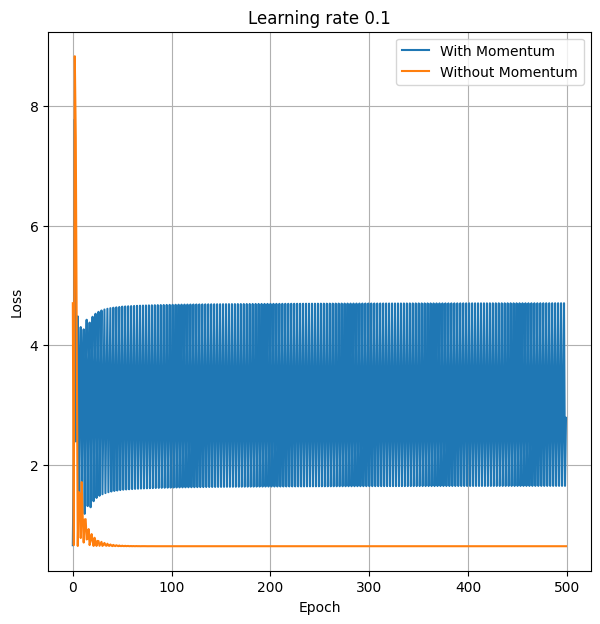

Epoch 0 - Loss: 0.7373836636543274
{'Accuracy': 0.330188679245283, 'F1 Score': 0.16392345778134618, 'Recall': 0.330188679245283}
Epoch 100 - Loss: 0.2798280417919159
{'Accuracy': 0.8773584905660378, 'F1 Score': 0.8762353103808895, 'Recall': 0.8773584905660378}
Epoch 200 - Loss: 0.22989515960216522
{'Accuracy': 0.8836477987421384, 'F1 Score': 0.8780346933375183, 'Recall': 0.8836477987421384}
Epoch 300 - Loss: 0.1835644692182541
{'Accuracy': 0.9088050314465409, 'F1 Score': 0.9065384633208774, 'Recall': 0.9088050314465409}
Epoch 400 - Loss: 0.1731354147195816
{'Accuracy': 0.9150943396226415, 'F1 Score': 0.9135500291364929, 'Recall': 0.9150943396226415}
Epoch 0 - Loss: 0.16449452936649323
{'Accuracy': 0.9150943396226415, 'F1 Score': 0.9132727111163769, 'Recall': 0.9150943396226415}
Epoch 100 - Loss: 0.11852207034826279
{'Accuracy': 0.9308176100628931, 'F1 Score': 0.9304677149320303, 'Recall': 0.9308176100628931}
Epoch 200 - Loss: 0.11292009800672531
{'Accuracy': 0.9276729559748428, 'F1 Sco

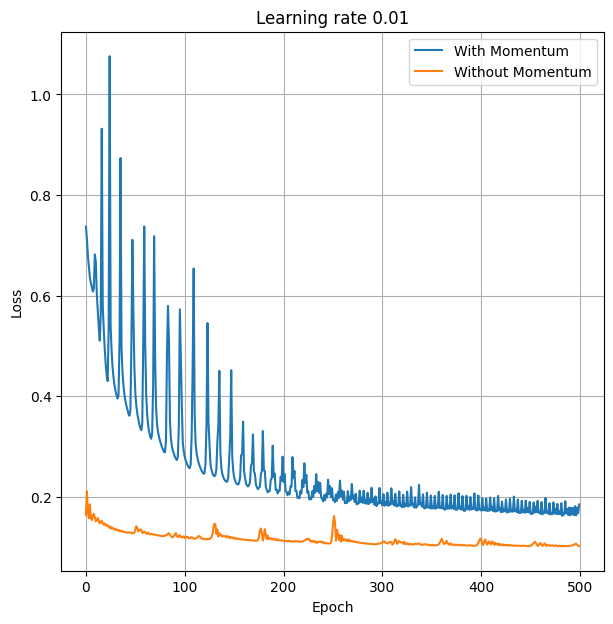

Epoch 0 - Loss: 0.7295507788658142
{'Accuracy': 0.330188679245283, 'F1 Score': 0.16392345778134618, 'Recall': 0.330188679245283}
Epoch 100 - Loss: 0.36866459250450134
{'Accuracy': 0.8490566037735849, 'F1 Score': 0.8514544958440067, 'Recall': 0.8490566037735849}
Epoch 200 - Loss: 0.2677333950996399
{'Accuracy': 0.889937106918239, 'F1 Score': 0.8915974230669177, 'Recall': 0.889937106918239}
Epoch 300 - Loss: 0.232545405626297
{'Accuracy': 0.89937106918239, 'F1 Score': 0.9009696638960045, 'Recall': 0.89937106918239}
Epoch 400 - Loss: 0.21778970956802368
{'Accuracy': 0.9056603773584906, 'F1 Score': 0.9070056328997985, 'Recall': 0.9056603773584906}
Epoch 0 - Loss: 0.20877547562122345
{'Accuracy': 0.9088050314465409, 'F1 Score': 0.9101807219697317, 'Recall': 0.9088050314465409}
Epoch 100 - Loss: 0.1605304330587387
{'Accuracy': 0.9182389937106918, 'F1 Score': 0.9186156223439952, 'Recall': 0.9182389937106918}
Epoch 200 - Loss: 0.13911627233028412
{'Accuracy': 0.9276729559748428, 'F1 Score': 0.

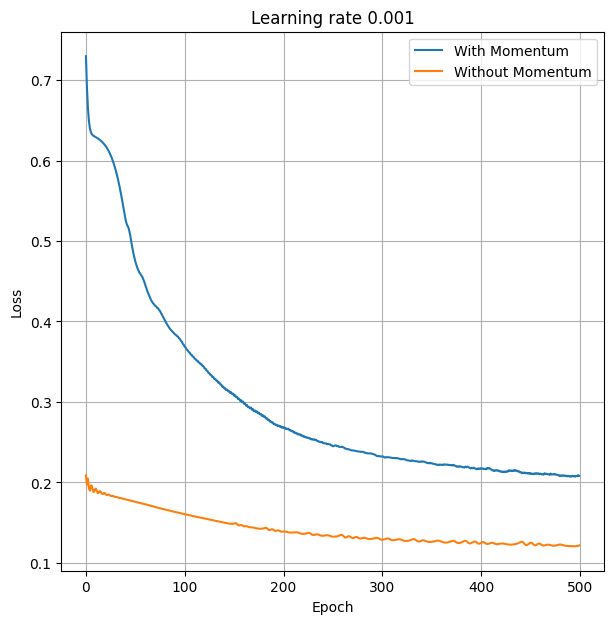

Epoch 0 - Loss: 0.6805858016014099
{'Accuracy': 0.660377358490566, 'F1 Score': 0.5253001715265866, 'Recall': 0.660377358490566}
Epoch 100 - Loss: 3.5207247734069824
{'Accuracy': 0.33962264150943394, 'F1 Score': 0.17220302949774116, 'Recall': 0.33962264150943394}
Epoch 200 - Loss: 4.497547626495361
{'Accuracy': 0.660377358490566, 'F1 Score': 0.5253001715265866, 'Recall': 0.660377358490566}
Epoch 300 - Loss: 1.2739888429641724
{'Accuracy': 0.660377358490566, 'F1 Score': 0.5253001715265866, 'Recall': 0.660377358490566}
Epoch 400 - Loss: 3.4274072647094727
{'Accuracy': 0.33962264150943394, 'F1 Score': 0.17220302949774116, 'Recall': 0.33962264150943394}
Epoch 0 - Loss: 4.490338325500488
{'Accuracy': 0.660377358490566, 'F1 Score': 0.5253001715265866, 'Recall': 0.660377358490566}
Epoch 100 - Loss: 0.6408141851425171
{'Accuracy': 0.660377358490566, 'F1 Score': 0.5253001715265866, 'Recall': 0.660377358490566}
Epoch 200 - Loss: 0.6407848596572876
{'Accuracy': 0.660377358490566, 'F1 Score': 0.525

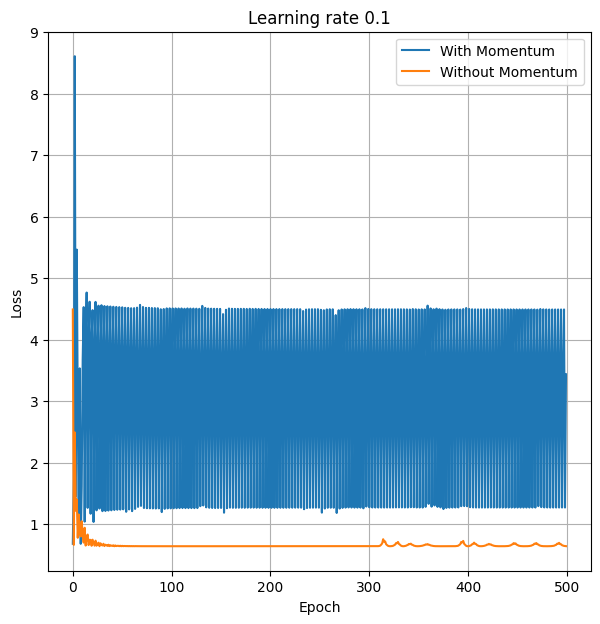

Epoch 0 - Loss: 0.6921826004981995
{'Accuracy': 0.5031446540880503, 'F1 Score': 0.504127358490566, 'Recall': 0.5031446540880503}
Epoch 100 - Loss: 0.5184987187385559
{'Accuracy': 0.7295597484276729, 'F1 Score': 0.7351442830226287, 'Recall': 0.7295597484276729}
Epoch 200 - Loss: 0.23747918009757996
{'Accuracy': 0.8867924528301887, 'F1 Score': 0.8831908505924776, 'Recall': 0.8867924528301887}
Epoch 300 - Loss: 0.1978032886981964
{'Accuracy': 0.9088050314465409, 'F1 Score': 0.907253973095622, 'Recall': 0.9088050314465409}
Epoch 400 - Loss: 0.1903037130832672
{'Accuracy': 0.9088050314465409, 'F1 Score': 0.907253973095622, 'Recall': 0.9088050314465409}
Epoch 0 - Loss: 0.1806708723306656
{'Accuracy': 0.9088050314465409, 'F1 Score': 0.9069745611564817, 'Recall': 0.9088050314465409}
Epoch 100 - Loss: 0.130425363779068
{'Accuracy': 0.9308176100628931, 'F1 Score': 0.9303164901357833, 'Recall': 0.9308176100628931}
Epoch 200 - Loss: 0.1296648383140564
{'Accuracy': 0.9276729559748428, 'F1 Score': 0

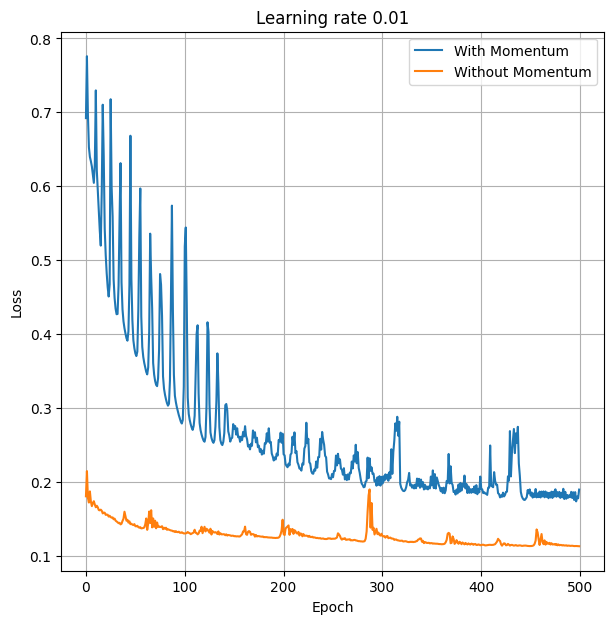

Epoch 0 - Loss: 0.7382997274398804
{'Accuracy': 0.33962264150943394, 'F1 Score': 0.17220302949774116, 'Recall': 0.33962264150943394}
Epoch 100 - Loss: 0.3855789303779602
{'Accuracy': 0.8081761006289309, 'F1 Score': 0.8124152696353356, 'Recall': 0.8081761006289309}
Epoch 200 - Loss: 0.29042914509773254
{'Accuracy': 0.8773584905660378, 'F1 Score': 0.8795645670182142, 'Recall': 0.8773584905660378}
Epoch 300 - Loss: 0.25413015484809875
{'Accuracy': 0.8836477987421384, 'F1 Score': 0.8857407430685622, 'Recall': 0.8836477987421384}
Epoch 400 - Loss: 0.23167183995246887
{'Accuracy': 0.9025157232704403, 'F1 Score': 0.9038755328063505, 'Recall': 0.9025157232704403}
Epoch 0 - Loss: 0.21826903522014618
{'Accuracy': 0.9056603773584906, 'F1 Score': 0.9070453564549689, 'Recall': 0.9056603773584906}
Epoch 100 - Loss: 0.1677524447441101
{'Accuracy': 0.9213836477987422, 'F1 Score': 0.9214709772046387, 'Recall': 0.9213836477987422}
Epoch 200 - Loss: 0.1470237523317337
{'Accuracy': 0.9371069182389937, 'F1

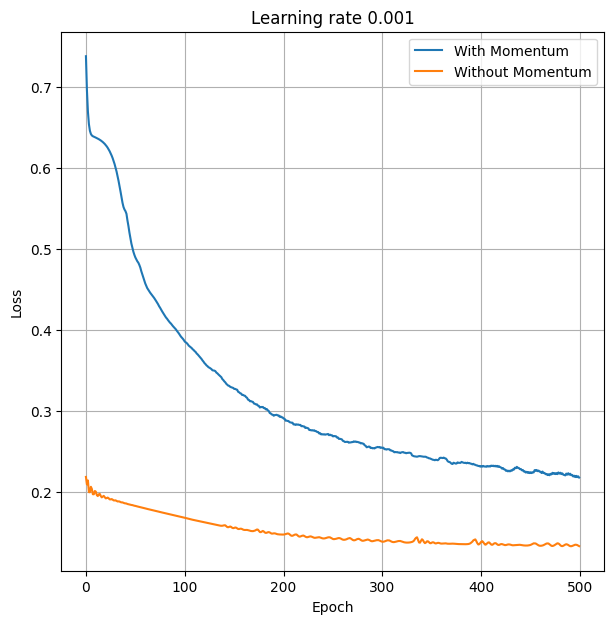

Epoch 0 - Loss: 0.721132218837738
{'Accuracy': 0.3270440251572327, 'F1 Score': 0.16119705505380189, 'Recall': 0.3270440251572327}
Epoch 100 - Loss: 0.6384392976760864
{'Accuracy': 0.6729559748427673, 'F1 Score': 0.5414006714900459, 'Recall': 0.6729559748427673}
Epoch 200 - Loss: 0.6320671439170837
{'Accuracy': 0.6729559748427673, 'F1 Score': 0.5414006714900459, 'Recall': 0.6729559748427673}
Epoch 300 - Loss: 0.6320655345916748
{'Accuracy': 0.6729559748427673, 'F1 Score': 0.5414006714900459, 'Recall': 0.6729559748427673}
Epoch 400 - Loss: 0.6320654153823853
{'Accuracy': 0.6729559748427673, 'F1 Score': 0.5414006714900459, 'Recall': 0.6729559748427673}
Epoch 0 - Loss: 0.6320655941963196
{'Accuracy': 0.6729559748427673, 'F1 Score': 0.5414006714900459, 'Recall': 0.6729559748427673}
Epoch 100 - Loss: 0.6321141123771667
{'Accuracy': 0.6729559748427673, 'F1 Score': 0.5414006714900459, 'Recall': 0.6729559748427673}
Epoch 200 - Loss: 0.63206547498703
{'Accuracy': 0.6729559748427673, 'F1 Score': 

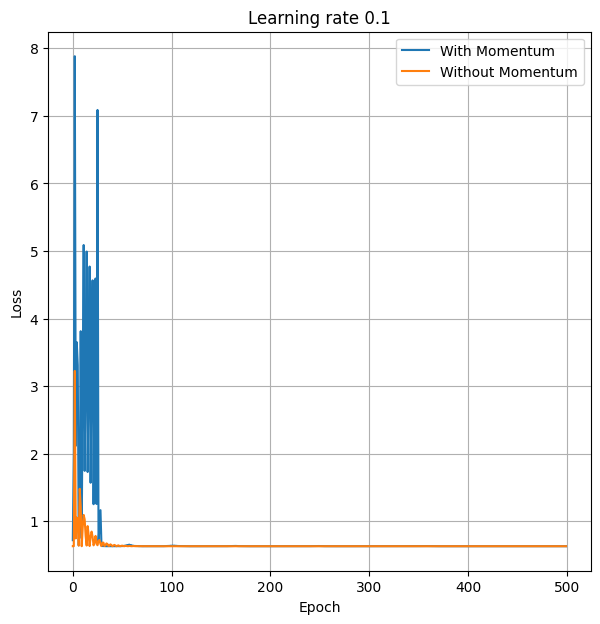

Epoch 0 - Loss: 0.6503454446792603
{'Accuracy': 0.6729559748427673, 'F1 Score': 0.5414006714900459, 'Recall': 0.6729559748427673}
Epoch 100 - Loss: 0.354696124792099
{'Accuracy': 0.8364779874213837, 'F1 Score': 0.8201944928914963, 'Recall': 0.8364779874213837}
Epoch 200 - Loss: 0.2259519100189209
{'Accuracy': 0.8930817610062893, 'F1 Score': 0.8905532891381948, 'Recall': 0.8930817610062893}
Epoch 300 - Loss: 0.1970551609992981
{'Accuracy': 0.9088050314465409, 'F1 Score': 0.9071093426888575, 'Recall': 0.9088050314465409}
Epoch 400 - Loss: 0.17530247569084167
{'Accuracy': 0.9150943396226415, 'F1 Score': 0.9140486769584721, 'Recall': 0.9150943396226415}
Epoch 0 - Loss: 0.16634127497673035
{'Accuracy': 0.9119496855345912, 'F1 Score': 0.9109964802954245, 'Recall': 0.9119496855345912}
Epoch 100 - Loss: 0.1276966780424118
{'Accuracy': 0.9308176100628931, 'F1 Score': 0.931706579583938, 'Recall': 0.9308176100628931}
Epoch 200 - Loss: 0.14157573878765106
{'Accuracy': 0.9308176100628931, 'F1 Score

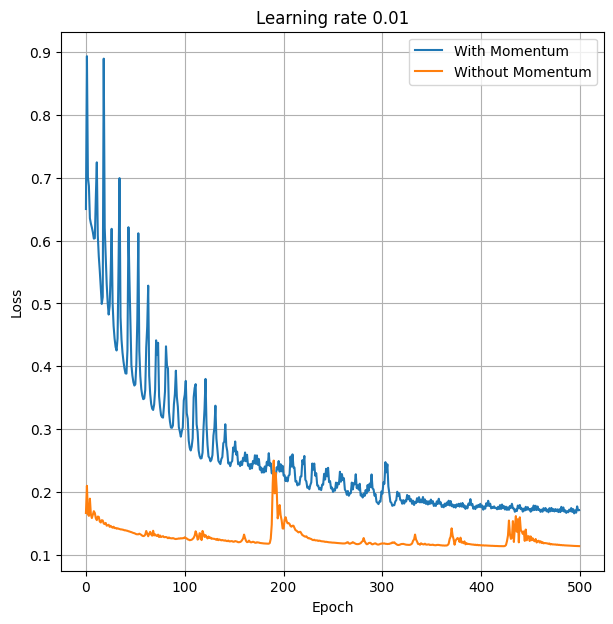

Epoch 0 - Loss: 0.6510586738586426
{'Accuracy': 0.6729559748427673, 'F1 Score': 0.5414006714900459, 'Recall': 0.6729559748427673}
Epoch 100 - Loss: 0.3587786555290222
{'Accuracy': 0.8333333333333334, 'F1 Score': 0.8364371394002061, 'Recall': 0.8333333333333334}
Epoch 200 - Loss: 0.2674747407436371
{'Accuracy': 0.8836477987421384, 'F1 Score': 0.8858146067510873, 'Recall': 0.8836477987421384}
Epoch 300 - Loss: 0.23860789835453033
{'Accuracy': 0.889937106918239, 'F1 Score': 0.8918187985534081, 'Recall': 0.889937106918239}
Epoch 400 - Loss: 0.22365282475948334
{'Accuracy': 0.8930817610062893, 'F1 Score': 0.8948241872312215, 'Recall': 0.8930817610062893}
Epoch 0 - Loss: 0.21578413248062134
{'Accuracy': 0.9025157232704403, 'F1 Score': 0.9041823644330185, 'Recall': 0.9025157232704403}
Epoch 100 - Loss: 0.16627290844917297
{'Accuracy': 0.9213836477987422, 'F1 Score': 0.9214796685778501, 'Recall': 0.9213836477987422}
Epoch 200 - Loss: 0.14328670501708984
{'Accuracy': 0.9245283018867925, 'F1 Sco

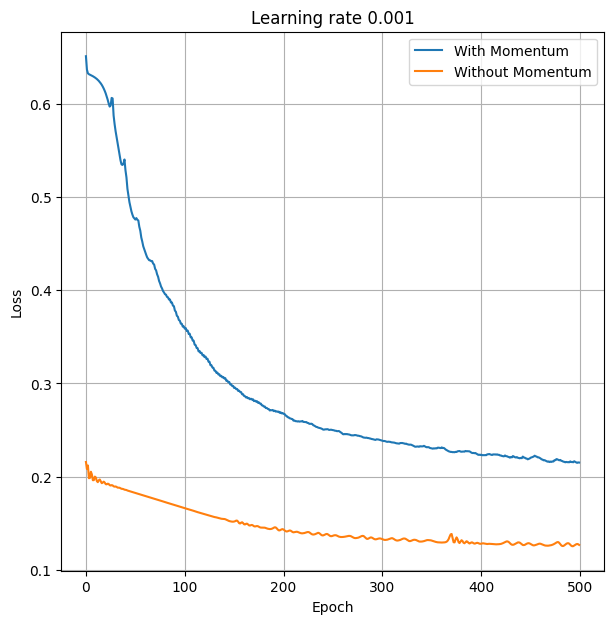

Epoch 0 - Loss: 0.6614031195640564
{'Accuracy': 0.6635220125786163, 'F1 Score': 0.529312456159123, 'Recall': 0.6635220125786163}
Epoch 100 - Loss: 0.6386717557907104
{'Accuracy': 0.6635220125786163, 'F1 Score': 0.529312456159123, 'Recall': 0.6635220125786163}
Epoch 200 - Loss: 0.6389525532722473
{'Accuracy': 0.6635220125786163, 'F1 Score': 0.529312456159123, 'Recall': 0.6635220125786163}
Epoch 300 - Loss: 0.6416833400726318
{'Accuracy': 0.6635220125786163, 'F1 Score': 0.529312456159123, 'Recall': 0.6635220125786163}
Epoch 400 - Loss: 0.6407027244567871
{'Accuracy': 0.6635220125786163, 'F1 Score': 0.529312456159123, 'Recall': 0.6635220125786163}
Epoch 0 - Loss: 0.639900803565979
{'Accuracy': 0.6635220125786163, 'F1 Score': 0.529312456159123, 'Recall': 0.6635220125786163}
Epoch 100 - Loss: 0.640269935131073
{'Accuracy': 0.6635220125786163, 'F1 Score': 0.529312456159123, 'Recall': 0.6635220125786163}
Epoch 200 - Loss: 0.6386728882789612
{'Accuracy': 0.6635220125786163, 'F1 Score': 0.52931

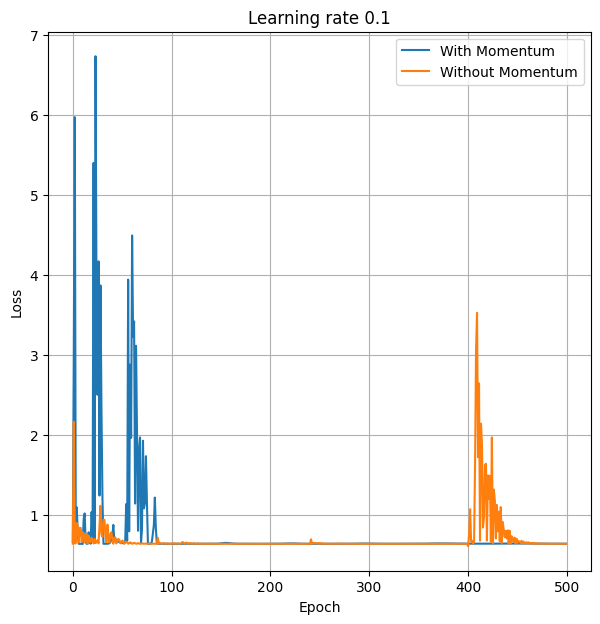

Epoch 0 - Loss: 0.7070237398147583
{'Accuracy': 0.33647798742138363, 'F1 Score': 0.1694265630780614, 'Recall': 0.33647798742138363}
Epoch 100 - Loss: 0.2890850603580475
{'Accuracy': 0.8710691823899371, 'F1 Score': 0.8699410758475565, 'Recall': 0.8710691823899371}
Epoch 200 - Loss: 0.24189381301403046
{'Accuracy': 0.8742138364779874, 'F1 Score': 0.8675887047593472, 'Recall': 0.8742138364779874}
Epoch 300 - Loss: 0.20777834951877594
{'Accuracy': 0.89937106918239, 'F1 Score': 0.8971432251349543, 'Recall': 0.89937106918239}
Epoch 400 - Loss: 0.1903804987668991
{'Accuracy': 0.9025157232704403, 'F1 Score': 0.9005147638513509, 'Recall': 0.9025157232704403}
Epoch 0 - Loss: 0.17784617841243744
{'Accuracy': 0.9119496855345912, 'F1 Score': 0.9110590433833041, 'Recall': 0.9119496855345912}
Epoch 100 - Loss: 0.14415253698825836
{'Accuracy': 0.9213836477987422, 'F1 Score': 0.9216456360164316, 'Recall': 0.9213836477987422}
Epoch 200 - Loss: 0.14915867149829865
{'Accuracy': 0.9182389937106918, 'F1 Sco

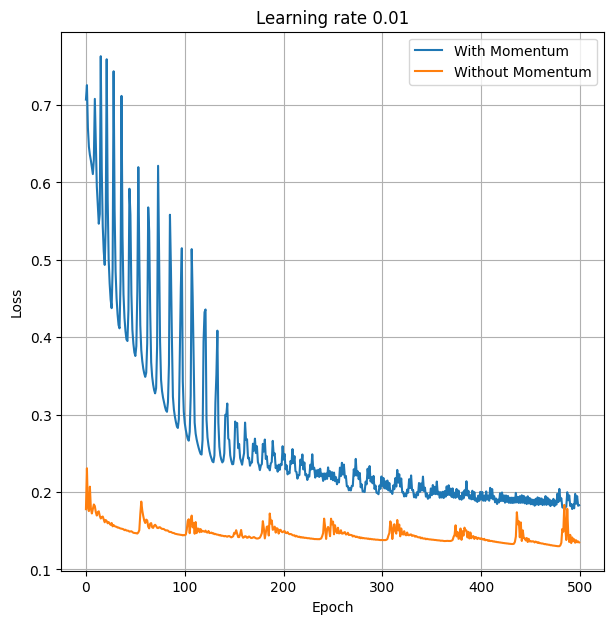

Epoch 0 - Loss: 0.6428009271621704
{'Accuracy': 0.6635220125786163, 'F1 Score': 0.529312456159123, 'Recall': 0.6635220125786163}
Epoch 100 - Loss: 0.3696337342262268
{'Accuracy': 0.8301886792452831, 'F1 Score': 0.83381217838765, 'Recall': 0.8301886792452831}
Epoch 200 - Loss: 0.2806342840194702
{'Accuracy': 0.8836477987421384, 'F1 Score': 0.8854871970175953, 'Recall': 0.8836477987421384}
Epoch 300 - Loss: 0.24584752321243286
{'Accuracy': 0.8962264150943396, 'F1 Score': 0.8978669595021795, 'Recall': 0.8962264150943396}
Epoch 400 - Loss: 0.22961047291755676
{'Accuracy': 0.8962264150943396, 'F1 Score': 0.8978669595021795, 'Recall': 0.8962264150943396}
Epoch 0 - Loss: 0.21905776858329773
{'Accuracy': 0.9056603773584906, 'F1 Score': 0.9072184788420288, 'Recall': 0.9056603773584906}
Epoch 100 - Loss: 0.17200958728790283
{'Accuracy': 0.9150943396226415, 'F1 Score': 0.9157229275678657, 'Recall': 0.9150943396226415}
Epoch 200 - Loss: 0.15579712390899658
{'Accuracy': 0.9150943396226415, 'F1 Scor

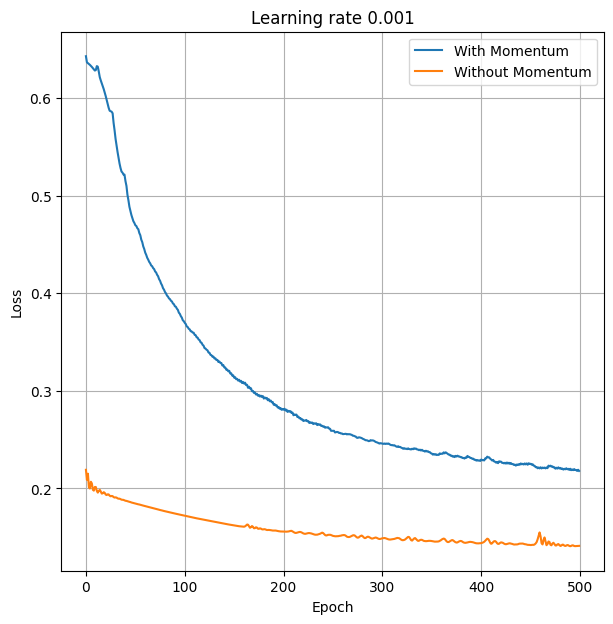

Epoch 0 - Loss: 0.7004643082618713
{'Accuracy': 0.32601880877742945, 'F1 Score': 0.1603118492333459, 'Recall': 0.32601880877742945}
Epoch 100 - Loss: 2.6034095287323
{'Accuracy': 0.32601880877742945, 'F1 Score': 0.1603118492333459, 'Recall': 0.32601880877742945}
Epoch 200 - Loss: 5.27638578414917
{'Accuracy': 0.6739811912225705, 'F1 Score': 0.5427189367522571, 'Recall': 0.6739811912225705}
Epoch 300 - Loss: 1.9288573265075684
{'Accuracy': 0.6739811912225705, 'F1 Score': 0.5427189367522571, 'Recall': 0.6739811912225705}
Epoch 400 - Loss: 2.5131587982177734
{'Accuracy': 0.32601880877742945, 'F1 Score': 0.1603118492333459, 'Recall': 0.32601880877742945}
Epoch 0 - Loss: 4.945916175842285
{'Accuracy': 0.6739811912225705, 'F1 Score': 0.5427189367522571, 'Recall': 0.6739811912225705}
Epoch 100 - Loss: 0.6257712841033936
{'Accuracy': 0.6739811912225705, 'F1 Score': 0.5427189367522571, 'Recall': 0.6739811912225705}
Epoch 200 - Loss: 0.6238369345664978
{'Accuracy': 0.6739811912225705, 'F1 Score'

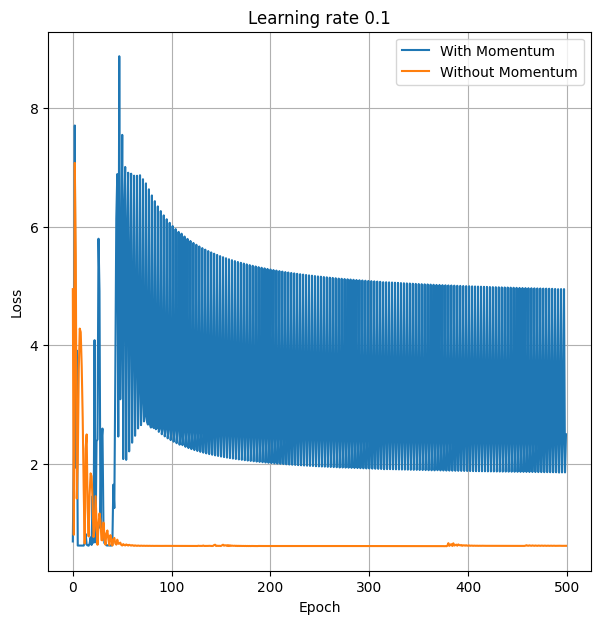

Epoch 0 - Loss: 0.7319709658622742
{'Accuracy': 0.32601880877742945, 'F1 Score': 0.1603118492333459, 'Recall': 0.32601880877742945}
Epoch 100 - Loss: 0.2769537568092346
{'Accuracy': 0.8808777429467085, 'F1 Score': 0.8780510376690986, 'Recall': 0.8808777429467085}
Epoch 200 - Loss: 0.2165100872516632
{'Accuracy': 0.8996865203761756, 'F1 Score': 0.8969500553892568, 'Recall': 0.8996865203761756}
Epoch 300 - Loss: 0.18866734206676483
{'Accuracy': 0.9122257053291536, 'F1 Score': 0.9098312984655996, 'Recall': 0.9122257053291536}
Epoch 400 - Loss: 0.17256301641464233
{'Accuracy': 0.9122257053291536, 'F1 Score': 0.9107302433874441, 'Recall': 0.9122257053291536}
Epoch 0 - Loss: 0.16224920749664307
{'Accuracy': 0.9153605015673981, 'F1 Score': 0.9140530645369234, 'Recall': 0.9153605015673981}
Epoch 100 - Loss: 0.13174447417259216
{'Accuracy': 0.9310344827586207, 'F1 Score': 0.9312017555975018, 'Recall': 0.9310344827586207}
Epoch 200 - Loss: 0.1221037358045578
{'Accuracy': 0.9373040752351097, 'F1 

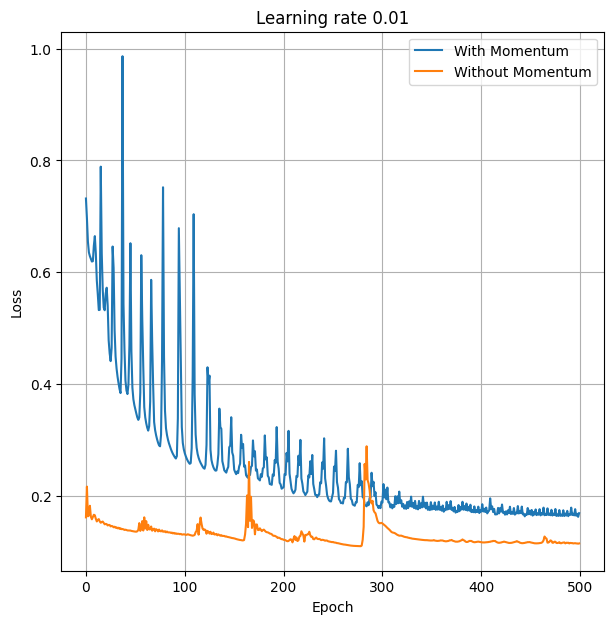

Epoch 0 - Loss: 0.63334059715271
{'Accuracy': 0.6739811912225705, 'F1 Score': 0.5427189367522571, 'Recall': 0.6739811912225705}
Epoch 100 - Loss: 0.35288330912590027
{'Accuracy': 0.8369905956112853, 'F1 Score': 0.8403918361674777, 'Recall': 0.8369905956112853}
Epoch 200 - Loss: 0.26795801520347595
{'Accuracy': 0.890282131661442, 'F1 Score': 0.8911604054329574, 'Recall': 0.890282131661442}
Epoch 300 - Loss: 0.23838354647159576
{'Accuracy': 0.896551724137931, 'F1 Score': 0.8975912232156305, 'Recall': 0.896551724137931}
Epoch 400 - Loss: 0.22009514272212982
{'Accuracy': 0.9090909090909091, 'F1 Score': 0.910347657702715, 'Recall': 0.9090909090909091}
Epoch 0 - Loss: 0.20836660265922546
{'Accuracy': 0.9122257053291536, 'F1 Score': 0.9133596316239444, 'Recall': 0.9122257053291536}
Epoch 100 - Loss: 0.16139353811740875
{'Accuracy': 0.9184952978056427, 'F1 Score': 0.9186929838879565, 'Recall': 0.9184952978056427}
Epoch 200 - Loss: 0.14682114124298096
{'Accuracy': 0.9310344827586207, 'F1 Score'

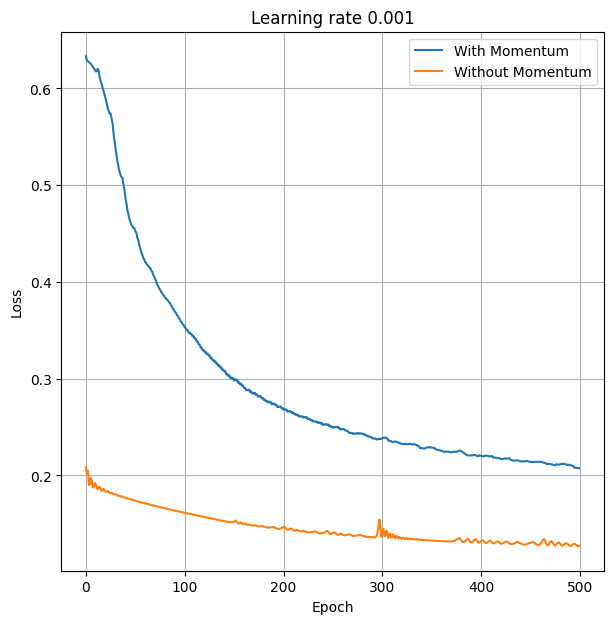

Epoch 0 - Loss: 0.7133964896202087
{'Accuracy': 0.34796238244514105, 'F1 Score': 0.17964569512284026, 'Recall': 0.34796238244514105}
Epoch 100 - Loss: 3.648362159729004
{'Accuracy': 0.34796238244514105, 'F1 Score': 0.17964569512284026, 'Recall': 0.34796238244514105}
Epoch 200 - Loss: 4.475247859954834
{'Accuracy': 0.6520376175548589, 'F1 Score': 0.5147014210679721, 'Recall': 0.6520376175548589}
Epoch 300 - Loss: 1.0853240489959717
{'Accuracy': 0.6520376175548589, 'F1 Score': 0.5147014210679721, 'Recall': 0.6520376175548589}
Epoch 400 - Loss: 3.614467144012451
{'Accuracy': 0.34796238244514105, 'F1 Score': 0.17964569512284026, 'Recall': 0.34796238244514105}
Epoch 0 - Loss: 4.47342586517334
{'Accuracy': 0.6520376175548589, 'F1 Score': 0.5147014210679721, 'Recall': 0.6520376175548589}
Epoch 100 - Loss: 0.6462603807449341
{'Accuracy': 0.6520376175548589, 'F1 Score': 0.5147014210679721, 'Recall': 0.6520376175548589}
Epoch 200 - Loss: 0.6461761593818665
{'Accuracy': 0.6520376175548589, 'F1 Sc

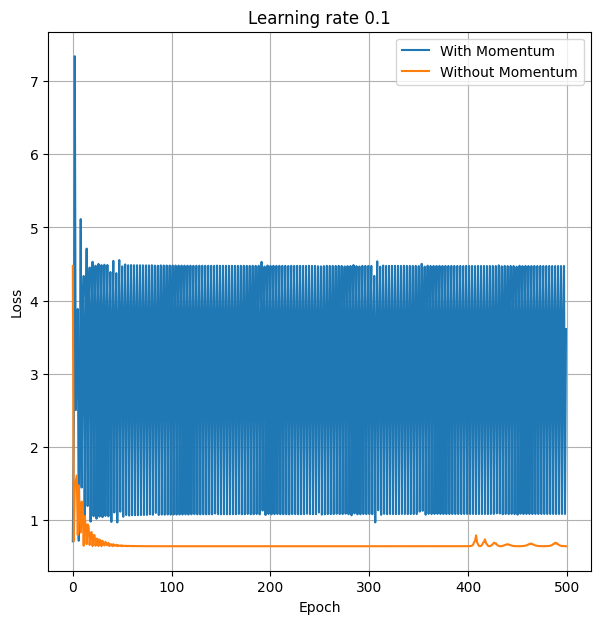

Epoch 0 - Loss: 0.702399730682373
{'Accuracy': 0.34796238244514105, 'F1 Score': 0.17964569512284026, 'Recall': 0.34796238244514105}
Epoch 100 - Loss: 0.2770623564720154
{'Accuracy': 0.8840125391849529, 'F1 Score': 0.8830840783407795, 'Recall': 0.8840125391849529}
Epoch 200 - Loss: 0.225490540266037
{'Accuracy': 0.8996865203761756, 'F1 Score': 0.9007688567265216, 'Recall': 0.8996865203761756}
Epoch 300 - Loss: 0.16503244638442993
{'Accuracy': 0.9122257053291536, 'F1 Score': 0.9125763801897252, 'Recall': 0.9122257053291536}
Epoch 400 - Loss: 0.1644429713487625
{'Accuracy': 0.9216300940438872, 'F1 Score': 0.9226443830505479, 'Recall': 0.9216300940438872}
Epoch 0 - Loss: 0.16092170774936676
{'Accuracy': 0.9216300940438872, 'F1 Score': 0.9226443830505479, 'Recall': 0.9216300940438872}
Epoch 100 - Loss: 0.11652281880378723
{'Accuracy': 0.9373040752351097, 'F1 Score': 0.9376702709445838, 'Recall': 0.9373040752351097}
Epoch 200 - Loss: 0.10760220885276794
{'Accuracy': 0.9404388714733543, 'F1 S

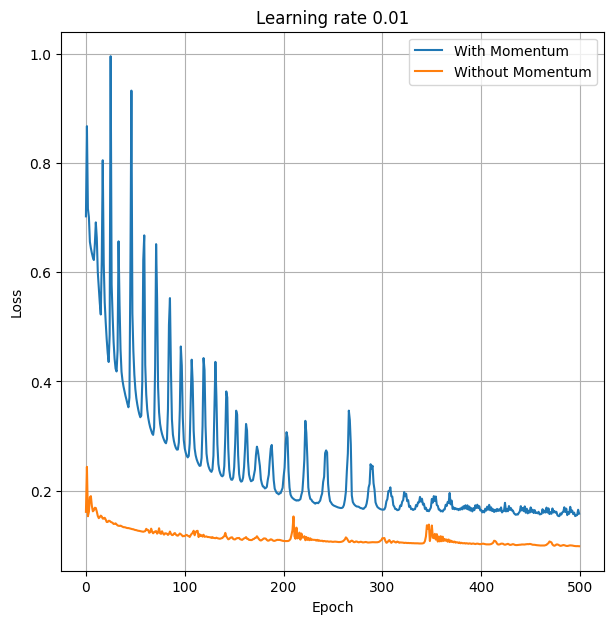

Epoch 0 - Loss: 0.6624977588653564
{'Accuracy': 0.6520376175548589, 'F1 Score': 0.5147014210679721, 'Recall': 0.6520376175548589}
Epoch 100 - Loss: 0.36420249938964844
{'Accuracy': 0.8369905956112853, 'F1 Score': 0.8396101223117468, 'Recall': 0.8369905956112853}
Epoch 200 - Loss: 0.2658447325229645
{'Accuracy': 0.896551724137931, 'F1 Score': 0.8980270615942539, 'Recall': 0.896551724137931}
Epoch 300 - Loss: 0.23315487802028656
{'Accuracy': 0.9059561128526645, 'F1 Score': 0.9072363741734939, 'Recall': 0.9059561128526645}
Epoch 400 - Loss: 0.21037304401397705
{'Accuracy': 0.9059561128526645, 'F1 Score': 0.9072363741734939, 'Recall': 0.9059561128526645}
Epoch 0 - Loss: 0.19336682558059692
{'Accuracy': 0.9153605015673981, 'F1 Score': 0.9164559336945918, 'Recall': 0.9153605015673981}
Epoch 100 - Loss: 0.1444293111562729
{'Accuracy': 0.9341692789968652, 'F1 Score': 0.9347238375451541, 'Recall': 0.9341692789968652}
Epoch 200 - Loss: 0.1276506781578064
{'Accuracy': 0.9341692789968652, 'F1 Scor

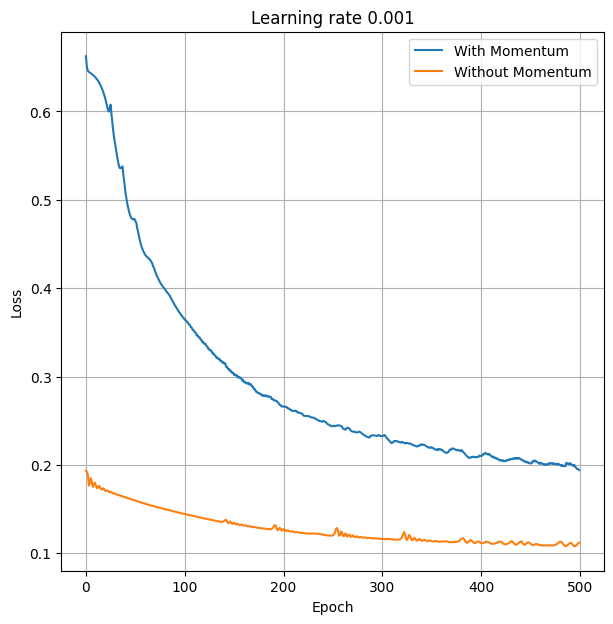

Epoch 0 - Loss: 0.7218747735023499
{'Accuracy': 0.31974921630094044, 'F1 Score': 0.15493786253062197, 'Recall': 0.31974921630094044}
Epoch 100 - Loss: 2.1891345977783203
{'Accuracy': 0.31974921630094044, 'F1 Score': 0.15493786253062197, 'Recall': 0.31974921630094044}
Epoch 200 - Loss: 4.860369682312012
{'Accuracy': 0.6802507836990596, 'F1 Score': 0.5508000748608056, 'Recall': 0.6802507836990596}
Epoch 300 - Loss: 1.928239107131958
{'Accuracy': 0.6802507836990596, 'F1 Score': 0.5508000748608056, 'Recall': 0.6802507836990596}
Epoch 400 - Loss: 2.164036512374878
{'Accuracy': 0.31974921630094044, 'F1 Score': 0.15493786253062197, 'Recall': 0.31974921630094044}
Epoch 0 - Loss: 4.8740620613098145
{'Accuracy': 0.6802507836990596, 'F1 Score': 0.5508000748608056, 'Recall': 0.6802507836990596}
Epoch 100 - Loss: 0.6266822218894958
{'Accuracy': 0.6802507836990596, 'F1 Score': 0.5508000748608056, 'Recall': 0.6802507836990596}
Epoch 200 - Loss: 0.6266802549362183
{'Accuracy': 0.6802507836990596, 'F1 

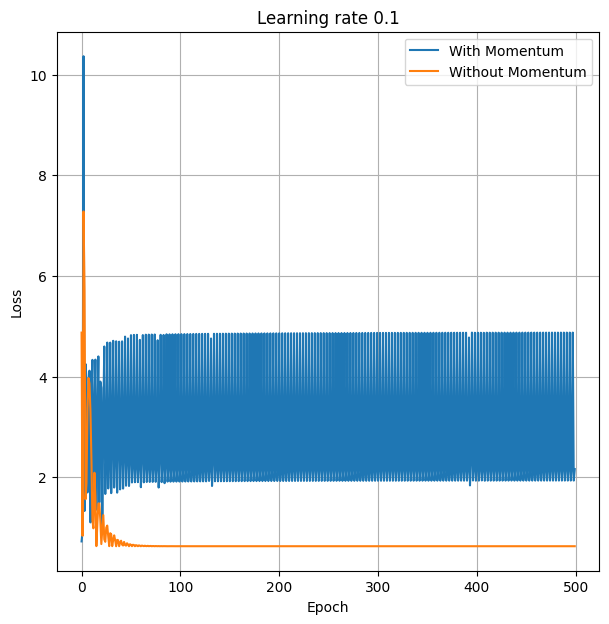

Epoch 0 - Loss: 0.7401576042175293
{'Accuracy': 0.31974921630094044, 'F1 Score': 0.15493786253062197, 'Recall': 0.31974921630094044}
Epoch 100 - Loss: 0.4003632962703705
{'Accuracy': 0.768025078369906, 'F1 Score': 0.7212633352745115, 'Recall': 0.768025078369906}
Epoch 200 - Loss: 0.22870959341526031
{'Accuracy': 0.8934169278996865, 'F1 Score': 0.889972014393284, 'Recall': 0.8934169278996865}
Epoch 300 - Loss: 0.1904725283384323
{'Accuracy': 0.9059561128526645, 'F1 Score': 0.9045913541114394, 'Recall': 0.9059561128526645}
Epoch 400 - Loss: 0.21373356878757477
{'Accuracy': 0.8840125391849529, 'F1 Score': 0.8780345862523563, 'Recall': 0.8840125391849529}
Epoch 0 - Loss: 0.17068727314472198
{'Accuracy': 0.9184952978056427, 'F1 Score': 0.9187022834076735, 'Recall': 0.9184952978056427}
Epoch 100 - Loss: 0.13696375489234924
{'Accuracy': 0.9341692789968652, 'F1 Score': 0.9349973656957224, 'Recall': 0.9341692789968652}
Epoch 200 - Loss: 0.13427168130874634
{'Accuracy': 0.9216300940438872, 'F1 S

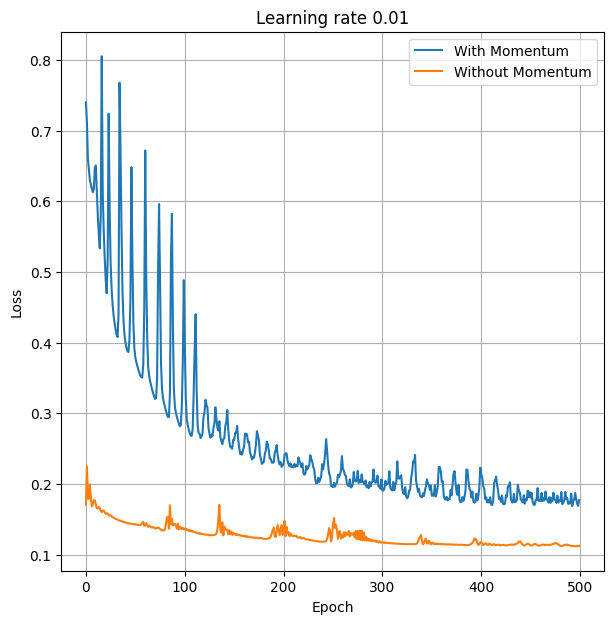

Epoch 0 - Loss: 0.671694278717041
{'Accuracy': 0.6802507836990596, 'F1 Score': 0.5508000748608056, 'Recall': 0.6802507836990596}
Epoch 100 - Loss: 0.37869903445243835
{'Accuracy': 0.8463949843260188, 'F1 Score': 0.84230793291119, 'Recall': 0.8463949843260188}
Epoch 200 - Loss: 0.2918608486652374
{'Accuracy': 0.8714733542319749, 'F1 Score': 0.8654342699534523, 'Recall': 0.8714733542319749}
Epoch 300 - Loss: 0.2585148513317108
{'Accuracy': 0.877742946708464, 'F1 Score': 0.8730517237779015, 'Recall': 0.877742946708464}
Epoch 400 - Loss: 0.23498539626598358
{'Accuracy': 0.8871473354231975, 'F1 Score': 0.8834997799458301, 'Recall': 0.8871473354231975}
Epoch 0 - Loss: 0.22240234911441803
{'Accuracy': 0.8934169278996865, 'F1 Score': 0.8903819117872097, 'Recall': 0.8934169278996865}
Epoch 100 - Loss: 0.16877727210521698
{'Accuracy': 0.9153605015673981, 'F1 Score': 0.9158796985888226, 'Recall': 0.9153605015673981}
Epoch 200 - Loss: 0.14824092388153076
{'Accuracy': 0.9247648902821317, 'F1 Score'

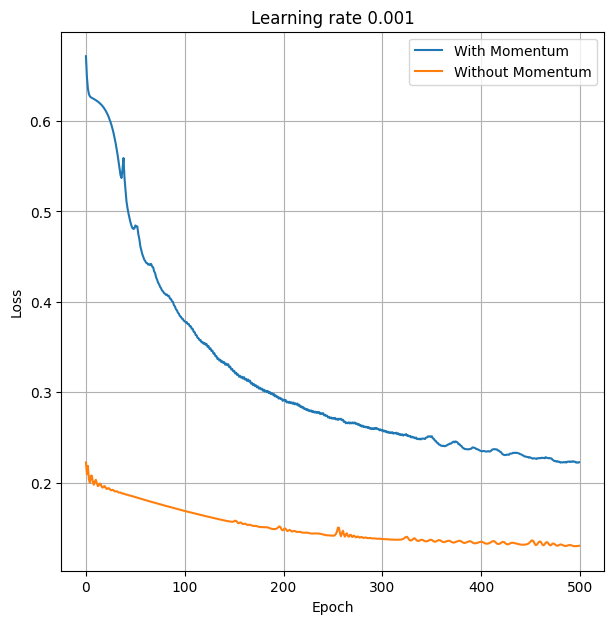

Epoch 0 - Loss: 0.6698863506317139
{'Accuracy': 0.658307210031348, 'F1 Score': 0.5226635694010703, 'Recall': 0.658307210031348}
Epoch 100 - Loss: 6.902822017669678
{'Accuracy': 0.34169278996865204, 'F1 Score': 0.1740397855447807, 'Recall': 0.34169278996865204}
Epoch 200 - Loss: 2.69389009475708
{'Accuracy': 0.658307210031348, 'F1 Score': 0.5226635694010703, 'Recall': 0.658307210031348}
Epoch 300 - Loss: 0.6421509981155396
{'Accuracy': 0.658307210031348, 'F1 Score': 0.5226635694010703, 'Recall': 0.658307210031348}
Epoch 400 - Loss: 5.670341491699219
{'Accuracy': 0.658307210031348, 'F1 Score': 0.5226635694010703, 'Recall': 0.658307210031348}
Epoch 0 - Loss: 1.2777036428451538
{'Accuracy': 0.658307210031348, 'F1 Score': 0.5226635694010703, 'Recall': 0.658307210031348}
Epoch 100 - Loss: 0.35125261545181274
{'Accuracy': 0.8307210031347962, 'F1 Score': 0.8341546184702289, 'Recall': 0.8307210031347962}
Epoch 200 - Loss: 0.2646920084953308
{'Accuracy': 0.890282131661442, 'F1 Score': 0.89015963

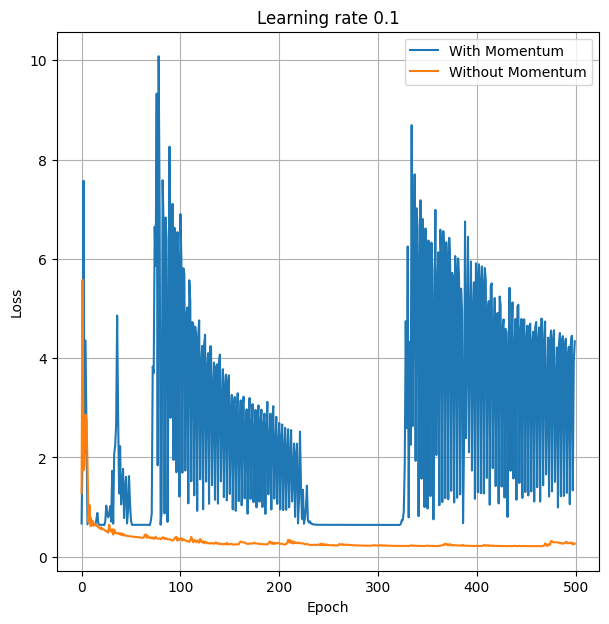

Epoch 0 - Loss: 0.7589231729507446
{'Accuracy': 0.34169278996865204, 'F1 Score': 0.1740397855447807, 'Recall': 0.34169278996865204}
Epoch 100 - Loss: 0.3250458538532257
{'Accuracy': 0.8557993730407524, 'F1 Score': 0.8544003638428389, 'Recall': 0.8557993730407524}
Epoch 200 - Loss: 0.26829808950424194
{'Accuracy': 0.8840125391849529, 'F1 Score': 0.8854238760194872, 'Recall': 0.8840125391849529}
Epoch 300 - Loss: 0.23020605742931366
{'Accuracy': 0.896551724137931, 'F1 Score': 0.8981115587605066, 'Recall': 0.896551724137931}
Epoch 400 - Loss: 0.21707895398139954
{'Accuracy': 0.8996865203761756, 'F1 Score': 0.901266210258944, 'Recall': 0.8996865203761756}
Epoch 0 - Loss: 0.19104747474193573
{'Accuracy': 0.9059561128526645, 'F1 Score': 0.9063512210063934, 'Recall': 0.9059561128526645}
Epoch 100 - Loss: 0.14564652740955353
{'Accuracy': 0.9247648902821317, 'F1 Score': 0.9252273214042329, 'Recall': 0.9247648902821317}
Epoch 200 - Loss: 0.1402977854013443
{'Accuracy': 0.9247648902821317, 'F1 Sc

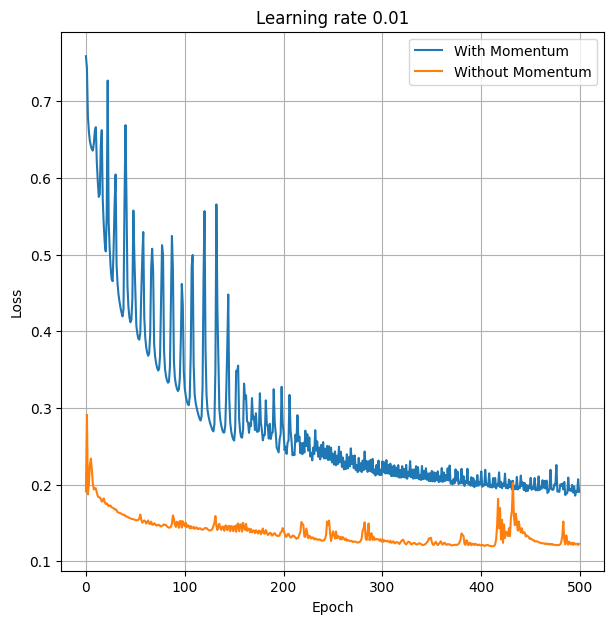

Epoch 0 - Loss: 0.6684600710868835
{'Accuracy': 0.658307210031348, 'F1 Score': 0.5226635694010703, 'Recall': 0.658307210031348}
Epoch 100 - Loss: 0.3877263069152832
{'Accuracy': 0.8119122257053292, 'F1 Score': 0.8157273538558097, 'Recall': 0.8119122257053292}
Epoch 200 - Loss: 0.3011458218097687
{'Accuracy': 0.8714733542319749, 'F1 Score': 0.8732303549530129, 'Recall': 0.8714733542319749}
Epoch 300 - Loss: 0.26770514249801636
{'Accuracy': 0.8808777429467085, 'F1 Score': 0.8827536246824959, 'Recall': 0.8808777429467085}
Epoch 400 - Loss: 0.24797488749027252
{'Accuracy': 0.8934169278996865, 'F1 Score': 0.8950953484001279, 'Recall': 0.8934169278996865}
Epoch 0 - Loss: 0.23580870032310486
{'Accuracy': 0.8996865203761756, 'F1 Score': 0.90112963550997, 'Recall': 0.8996865203761756}
Epoch 100 - Loss: 0.18127086758613586
{'Accuracy': 0.9122257053291536, 'F1 Score': 0.9125944729393005, 'Recall': 0.9122257053291536}
Epoch 200 - Loss: 0.1597694754600525
{'Accuracy': 0.9153605015673981, 'F1 Score'

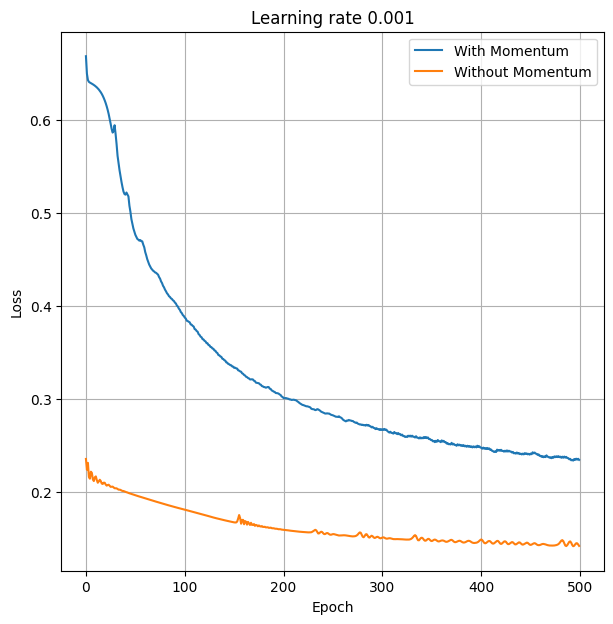

Epoch 0 - Loss: 0.6598533391952515
{'Accuracy': 0.6551724137931034, 'F1 Score': 0.5186781609195402, 'Recall': 0.6551724137931034}
Epoch 100 - Loss: 3.606741189956665
{'Accuracy': 0.3448275862068966, 'F1 Score': 0.1768346595932803, 'Recall': 0.3448275862068966}
Epoch 200 - Loss: 4.46298885345459
{'Accuracy': 0.6551724137931034, 'F1 Score': 0.5186781609195402, 'Recall': 0.6551724137931034}
Epoch 300 - Loss: 1.141413688659668
{'Accuracy': 0.6551724137931034, 'F1 Score': 0.5186781609195402, 'Recall': 0.6551724137931034}
Epoch 400 - Loss: 3.5751585960388184
{'Accuracy': 0.3448275862068966, 'F1 Score': 0.1768346595932803, 'Recall': 0.3448275862068966}
Epoch 0 - Loss: 4.462673187255859
{'Accuracy': 0.6551724137931034, 'F1 Score': 0.5186781609195402, 'Recall': 0.6551724137931034}
Epoch 100 - Loss: 0.6441874504089355
{'Accuracy': 0.6551724137931034, 'F1 Score': 0.5186781609195402, 'Recall': 0.6551724137931034}
Epoch 200 - Loss: 0.6441857218742371
{'Accuracy': 0.6551724137931034, 'F1 Score': 0.5

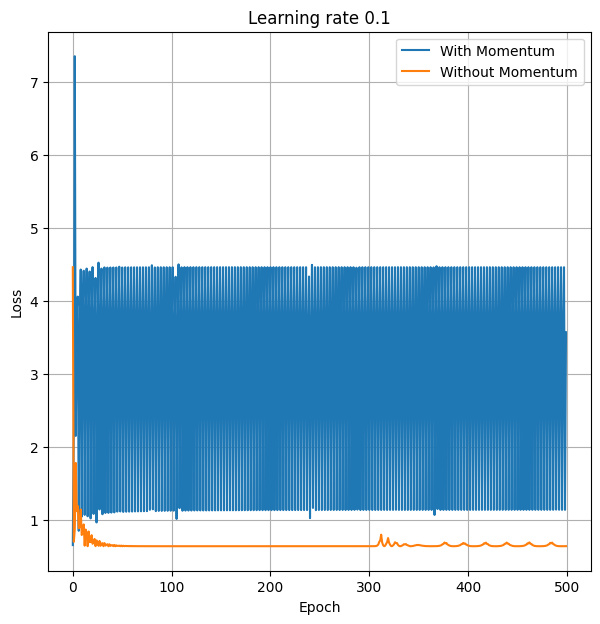

Epoch 0 - Loss: 0.7005995512008667
{'Accuracy': 0.3730407523510972, 'F1 Score': 0.2570787776843285, 'Recall': 0.3730407523510972}
Epoch 100 - Loss: 0.2731691896915436
{'Accuracy': 0.8840125391849529, 'F1 Score': 0.8845991854758657, 'Recall': 0.8840125391849529}
Epoch 200 - Loss: 0.22523438930511475
{'Accuracy': 0.8996865203761756, 'F1 Score': 0.9007983692882621, 'Recall': 0.8996865203761756}
Epoch 300 - Loss: 0.2102203369140625
{'Accuracy': 0.9122257053291536, 'F1 Score': 0.9134543530157511, 'Recall': 0.9122257053291536}
Epoch 400 - Loss: 0.21102237701416016
{'Accuracy': 0.9059561128526645, 'F1 Score': 0.9073964068385975, 'Recall': 0.9059561128526645}
Epoch 0 - Loss: 0.18778486549854279
{'Accuracy': 0.9090909090909091, 'F1 Score': 0.9103004065255266, 'Recall': 0.9090909090909091}
Epoch 100 - Loss: 0.1453363001346588
{'Accuracy': 0.9216300940438872, 'F1 Score': 0.9221710569841289, 'Recall': 0.9216300940438872}
Epoch 200 - Loss: 0.14378704130649567
{'Accuracy': 0.9278996865203761, 'F1 Sc

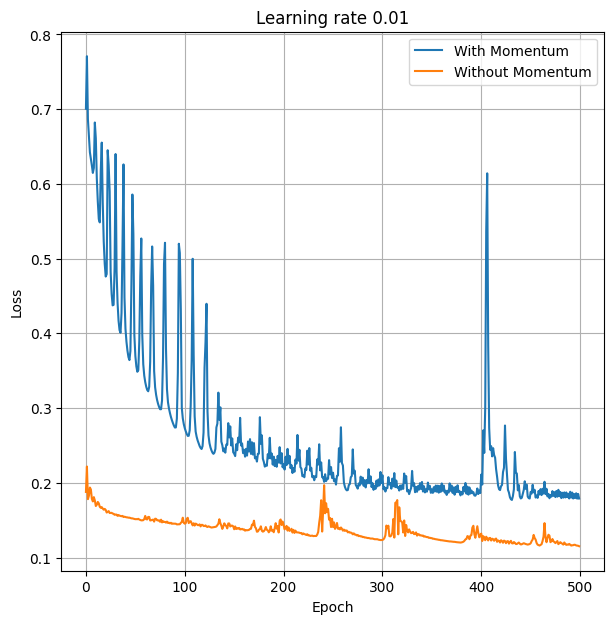

Epoch 0 - Loss: 0.6831308007240295
{'Accuracy': 0.6551724137931034, 'F1 Score': 0.5186781609195402, 'Recall': 0.6551724137931034}
Epoch 100 - Loss: 0.35875973105430603
{'Accuracy': 0.8620689655172413, 'F1 Score': 0.8596169822316457, 'Recall': 0.8620689655172413}
Epoch 200 - Loss: 0.26674869656562805
{'Accuracy': 0.8683385579937304, 'F1 Score': 0.8651902362017283, 'Recall': 0.8683385579937304}
Epoch 300 - Loss: 0.23818625509738922
{'Accuracy': 0.8808777429467085, 'F1 Score': 0.8780292613253734, 'Recall': 0.8808777429467085}
Epoch 400 - Loss: 0.22145812213420868
{'Accuracy': 0.8934169278996865, 'F1 Score': 0.8908682864490182, 'Recall': 0.8934169278996865}
Epoch 0 - Loss: 0.20955060422420502
{'Accuracy': 0.8934169278996865, 'F1 Score': 0.8908682864490182, 'Recall': 0.8934169278996865}
Epoch 100 - Loss: 0.1647133082151413
{'Accuracy': 0.9122257053291536, 'F1 Score': 0.9129092706535052, 'Recall': 0.9122257053291536}
Epoch 200 - Loss: 0.14450518786907196
{'Accuracy': 0.9216300940438872, 'F1 

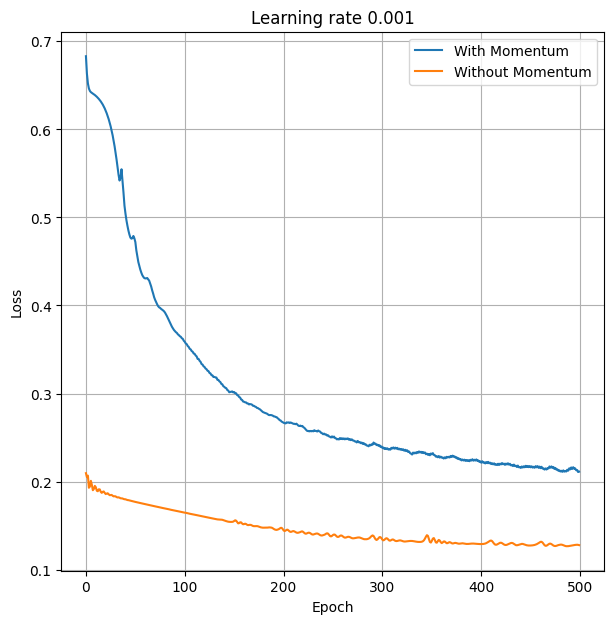

Epoch 0 - Loss: 0.6684534549713135
{'Accuracy': 0.6520376175548589, 'F1 Score': 0.5147014210679721, 'Recall': 0.6520376175548589}
Epoch 100 - Loss: 3.6208548545837402
{'Accuracy': 0.34796238244514105, 'F1 Score': 0.17964569512284026, 'Recall': 0.34796238244514105}
Epoch 200 - Loss: 0.6461692452430725
{'Accuracy': 0.6520376175548589, 'F1 Score': 0.5147014210679721, 'Recall': 0.6520376175548589}
Epoch 300 - Loss: 11.616230010986328
{'Accuracy': 0.34796238244514105, 'F1 Score': 0.17964569512284026, 'Recall': 0.34796238244514105}
Epoch 400 - Loss: 3.3735737800598145
{'Accuracy': 0.6520376175548589, 'F1 Score': 0.5147014210679721, 'Recall': 0.6520376175548589}
Epoch 0 - Loss: 0.6461750268936157
{'Accuracy': 0.6520376175548589, 'F1 Score': 0.5147014210679721, 'Recall': 0.6520376175548589}
Epoch 100 - Loss: 0.646176278591156
{'Accuracy': 0.6520376175548589, 'F1 Score': 0.5147014210679721, 'Recall': 0.6520376175548589}
Epoch 200 - Loss: 0.6461761593818665
{'Accuracy': 0.6520376175548589, 'F1 S

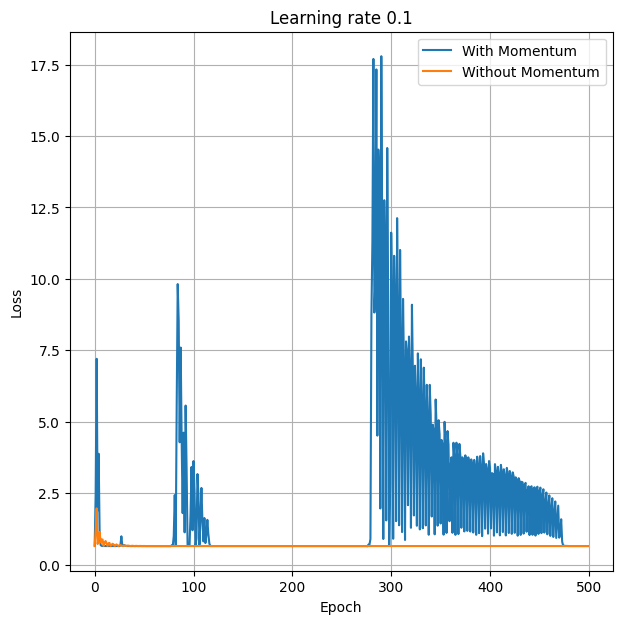

Epoch 0 - Loss: 0.7259691953659058
{'Accuracy': 0.34796238244514105, 'F1 Score': 0.17964569512284026, 'Recall': 0.34796238244514105}
Epoch 100 - Loss: 0.40461763739585876
{'Accuracy': 0.8338557993730408, 'F1 Score': 0.8374486581425501, 'Recall': 0.8338557993730408}
Epoch 200 - Loss: 0.29607701301574707
{'Accuracy': 0.877742946708464, 'F1 Score': 0.8796366615299785, 'Recall': 0.877742946708464}
Epoch 300 - Loss: 0.20050039887428284
{'Accuracy': 0.9090909090909091, 'F1 Score': 0.9098567280385463, 'Recall': 0.9090909090909091}
Epoch 400 - Loss: 0.18524031341075897
{'Accuracy': 0.9090909090909091, 'F1 Score': 0.9098567280385463, 'Recall': 0.9090909090909091}
Epoch 0 - Loss: 0.1954924762248993
{'Accuracy': 0.8996865203761756, 'F1 Score': 0.9014082192338284, 'Recall': 0.8996865203761756}
Epoch 100 - Loss: 0.13859979808330536
{'Accuracy': 0.9247648902821317, 'F1 Score': 0.9252043251335005, 'Recall': 0.9247648902821317}
Epoch 200 - Loss: 0.131984680891037
{'Accuracy': 0.9247648902821317, 'F1 S

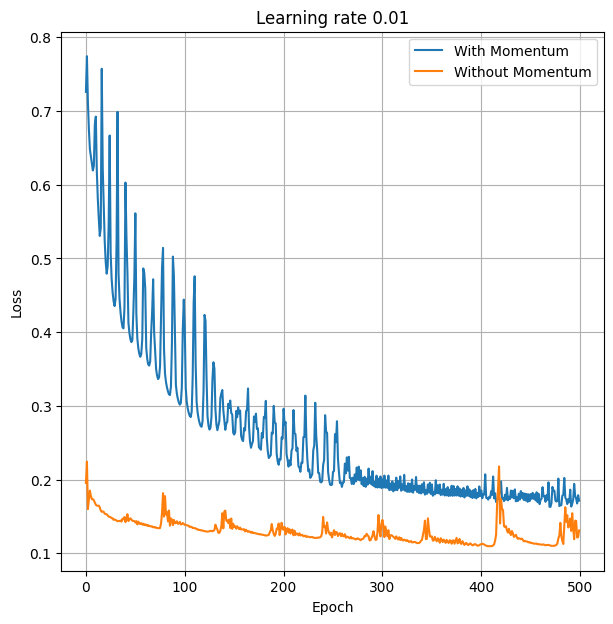

Epoch 0 - Loss: 0.6856405138969421
{'Accuracy': 0.6520376175548589, 'F1 Score': 0.5147014210679721, 'Recall': 0.6520376175548589}
Epoch 100 - Loss: 0.394231379032135
{'Accuracy': 0.8181818181818182, 'F1 Score': 0.8208885335769758, 'Recall': 0.8181818181818182}
Epoch 200 - Loss: 0.29701441526412964
{'Accuracy': 0.8808777429467085, 'F1 Score': 0.8826511082056049, 'Recall': 0.8808777429467085}
Epoch 300 - Loss: 0.25531405210494995
{'Accuracy': 0.8934169278996865, 'F1 Score': 0.8947223660666964, 'Recall': 0.8934169278996865}
Epoch 400 - Loss: 0.23593878746032715
{'Accuracy': 0.8996865203761756, 'F1 Score': 0.9009151680627733, 'Recall': 0.8996865203761756}
Epoch 0 - Loss: 0.2209067940711975
{'Accuracy': 0.9090909090909091, 'F1 Score': 0.9101391402009109, 'Recall': 0.9090909090909091}
Epoch 100 - Loss: 0.1604689061641693
{'Accuracy': 0.9278996865203761, 'F1 Score': 0.9281184897315815, 'Recall': 0.9278996865203761}
Epoch 200 - Loss: 0.14111904799938202
{'Accuracy': 0.9247648902821317, 'F1 Sco

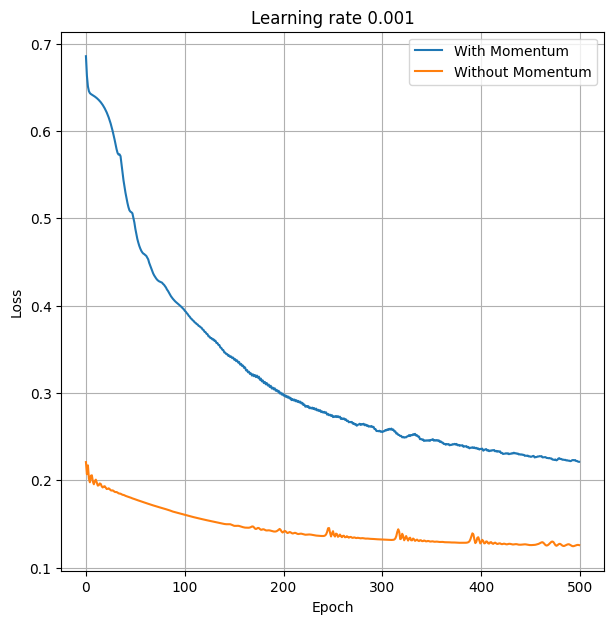

In [ ]:
x, y = x_ohencoded, y

# Create the KFold object
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True)

i = 0 # Tracking k-fold

# Loop over the folds
for train_index, test_index in kf.split(x):
    # Split the data into training and test sets for this fold
    x_fold_train= x.iloc[train_index]
    y_fold_train = y[train_index]
    x_fold_test= x.iloc[test_index]
    y_fold_test = y[test_index]

    # Convert to tensor
    X_train_tensor = torch.tensor(x_fold_train.values).float()
    y_train_tensor = torch.tensor(y_fold_train).long()
    X_test_tensor = torch.tensor(x_fold_test.values).float()
    y_test_tensor = torch.tensor(y_fold_test).long()

    # Train the model on the training set for this fold
    loss_fn = nn.CrossEntropyLoss()

    learn_rate = [0.1, 0.01, 0.001]
    epochs = 500

    for lr in learn_rate:
      num_classes = len(y.unique())
      model = AllThreeNN(X_train.shape[1], 64, num_classes)

      optimiser = optim.Adam(model.parameters(), lr=lr, betas=(0.0, 0.999))
      All_momentum, metrics, acc = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)

      optimiser = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
      All_no_momentum, metrics, acc = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)

      # Plot loss over epochs
      plt.figure(figsize=(7,7))
      plt.plot(range(epochs), All_momentum, label='With Momentum')
      plt.plot(range(epochs), All_no_momentum, label='Without Momentum')
      plt.title('Learning rate %s' % lr)
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.grid(True)
      plt.legend()
      plt.show()

## Dropout

### Whole dataset

In [ ]:
loss_fn = nn.CrossEntropyLoss()
epochs = 500

print('Dropout after each hidden layer (Accuracy)')
num_classes = len(y.unique())
model = DropoutNN(X_train.shape[1], 64, num_classes, 0.2)
optimiser = optim.Adam(model.parameters())
loss, metrics, acc = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
acc_1 = np.mean(acc)

num_classes = len(y.unique())
model = DropoutNN(X_train.shape[1], 64, num_classes, 0.5)
optimiser = optim.Adam(model.parameters())
loss, metrics, acc = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
acc_2 = np.mean(acc)

num_classes = len(y.unique())
model = DropoutNN(X_train.shape[1], 64, num_classes, 0.8)
optimiser = optim.Adam(model.parameters())
loss, metrics, acc = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
acc_3 = np.mean(acc)

# ---------------------------------------------
print('One dropout (Accuracy)')
num_classes = len(y.unique())
model = OneDropoutNN(X_train.shape[1], 64, num_classes, 0.2)
optimiser = optim.Adam(model.parameters())
loss, metrics, acc = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
acc_4 = np.mean(acc)

num_classes = len(y.unique())
model = OneDropoutNN(X_train.shape[1], 64, num_classes, 0.5)
optimiser = optim.Adam(model.parameters())
loss, metrics, acc = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
acc_5 = np.mean(acc)

num_classes = len(y.unique())
model = OneDropoutNN(X_train.shape[1], 64, num_classes, 0.8)
optimiser = optim.Adam(model.parameters())
loss, metrics, acc = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
acc_6 = np.mean(acc)

Dropout after each hidden layer (Accuracy)
Epoch 0 - Loss: 0.6647527813911438
{'Accuracy': 0.6066666666666667, 'F1 Score': 0.573957033957034, 'Recall': 0.6066666666666667}
Epoch 100 - Loss: 0.4123230278491974
{'Accuracy': 0.8466666666666667, 'F1 Score': 0.8466666666666667, 'Recall': 0.8466666666666667}
Epoch 200 - Loss: 0.30223435163497925
{'Accuracy': 0.8666666666666667, 'F1 Score': 0.8655370132648695, 'Recall': 0.8666666666666667}
Epoch 300 - Loss: 0.2520565688610077
{'Accuracy': 0.8933333333333333, 'F1 Score': 0.8920994284927356, 'Recall': 0.8933333333333333}
Epoch 400 - Loss: 0.21241070330142975
{'Accuracy': 0.9166666666666666, 'F1 Score': 0.9163261235800096, 'Recall': 0.9166666666666666}
Epoch 0 - Loss: 0.7088891863822937
{'Accuracy': 0.53, 'F1 Score': 0.5421155555555556, 'Recall': 0.53}
Epoch 100 - Loss: 0.5134585499763489
{'Accuracy': 0.73, 'F1 Score': 0.7181302907618696, 'Recall': 0.73}
Epoch 200 - Loss: 0.4218354821205139
{'Accuracy': 0.8233333333333334, 'F1 Score': 0.82100693

In [ ]:
print('Dropout after each hidden layer (Accuracy)')
print('Dropout Probability 0.2: %s' %acc_1)
print('Dropout Probability 0.5: %s' %acc_2)
print('Dropout Probability 0.8: %s' %acc_3)
print('')
print('One dropout (Accuracy)')
print('Dropout Probability 0.2: %s' %acc_4)
print('Dropout Probability 0.5: %s' %acc_5)
print('Dropout Probability 0.8: %s' %acc_6)

Dropout after each hidden layer (Accuracy)
Dropout Probability 0.2: 0.8516333333333335
Dropout Probability 0.5: 0.8069066666666667
Dropout Probability 0.8: 0.6979733333333333

One dropout (Accuracy)
Dropout Probability 0.2: 0.8687933333333333
Dropout Probability 0.5: 0.8424266666666668
Dropout Probability 0.8: 0.8076599999999999


### K-fold

In [ ]:
x, y = x_ohencoded, y

# Initialize lists to store training and test MSE for each fold
acc_1_lst, acc_2_lst, acc_3_lst, acc_4_lst, acc_5_lst, acc_6_lst = [], [], [], [], [], []

# Create the KFold object
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True)

i = 0 # Tracking k-fold

# Loop over the folds
for train_index, test_index in kf.split(x):
    # Split the data into training and test sets for this fold
    x_fold_train= x.iloc[train_index]
    y_fold_train = y[train_index]
    x_fold_test= x.iloc[test_index]
    y_fold_test = y[test_index]

    # Convert to tensor
    X_train_tensor = torch.tensor(x_fold_train.values).float()
    y_train_tensor = torch.tensor(y_fold_train).long()
    X_test_tensor = torch.tensor(x_fold_test.values).float()
    y_test_tensor = torch.tensor(y_fold_test).long()

    # Train the model on the training set for this fold
    loss_fn = nn.CrossEntropyLoss()
    epochs = 500

    print('Dropout after each hidden layer (Accuracy)')
    num_classes = len(y.unique())
    model = DropoutNN(X_train.shape[1], 64, num_classes, 0.2)
    optimiser = optim.Adam(model.parameters())
    loss, metrics, acc = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
    acc_1 = np.mean(acc)
    acc_1_lst.append(acc_1)

    num_classes = len(y.unique())
    model = DropoutNN(X_train.shape[1], 64, num_classes, 0.5)
    optimiser = optim.Adam(model.parameters())
    loss, metrics, acc = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
    acc_2 = np.mean(acc)
    acc_2_lst.append(acc_2)

    num_classes = len(y.unique())
    model = DropoutNN(X_train.shape[1], 64, num_classes, 0.8)
    optimiser = optim.Adam(model.parameters())
    loss, metrics, acc = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
    acc_3 = np.mean(acc)
    acc_3_lst.append(acc_3)

    # ---------------------------------------------
    print('One dropout (Accuracy)')
    num_classes = len(y.unique())
    model = OneDropoutNN(X_train.shape[1], 64, num_classes, 0.2)
    optimiser = optim.Adam(model.parameters())
    loss, metrics, acc = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
    acc_4 = np.mean(acc)
    acc_4_lst.append(acc_4)

    num_classes = len(y.unique())
    model = OneDropoutNN(X_train.shape[1], 64, num_classes, 0.5)
    optimiser = optim.Adam(model.parameters())
    loss, metrics, acc = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
    acc_5 = np.mean(acc)
    acc_5_lst.append(acc_5)

    num_classes = len(y.unique())
    model = OneDropoutNN(X_train.shape[1], 64, num_classes, 0.8)
    optimiser = optim.Adam(model.parameters())
    loss, metrics, acc = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)
    acc_6 = np.mean(acc)
    acc_6_lst.append(acc_6)

Dropout after each hidden layer (Accuracy)
Epoch 0 - Loss: 0.7294299602508545
{'Accuracy': 0.3867924528301887, 'F1 Score': 0.2927715754636172, 'Recall': 0.3867924528301887}
Epoch 100 - Loss: 0.422942191362381
{'Accuracy': 0.8176100628930818, 'F1 Score': 0.8163498055431824, 'Recall': 0.8176100628930818}
Epoch 200 - Loss: 0.31828978657722473
{'Accuracy': 0.8616352201257862, 'F1 Score': 0.8606791628258624, 'Recall': 0.8616352201257862}
Epoch 300 - Loss: 0.27926456928253174
{'Accuracy': 0.8710691823899371, 'F1 Score': 0.8717174963146593, 'Recall': 0.8710691823899371}
Epoch 400 - Loss: 0.23388703167438507
{'Accuracy': 0.89937106918239, 'F1 Score': 0.8995812876042573, 'Recall': 0.89937106918239}
Epoch 0 - Loss: 0.6920444369316101
{'Accuracy': 0.5345911949685535, 'F1 Score': 0.5416663678840267, 'Recall': 0.5345911949685535}
Epoch 100 - Loss: 0.5227512121200562
{'Accuracy': 0.7515723270440252, 'F1 Score': 0.7366035550876072, 'Recall': 0.7515723270440252}
Epoch 200 - Loss: 0.4165416359901428
{'

In [ ]:
print('Dropout after each hidden layer (Accuracy)')
print('Dropout Probability 0.2: %s' %acc_1_lst)
print('Dropout Probability 0.5: %s' %acc_2_lst)
print('Dropout Probability 0.8: %s' %acc_3_lst)
print('')
print('One dropout (Accuracy)')
print('Dropout Probability 0.5: %s' %acc_4_lst)
print('Dropout Probability 0.5: %s' %acc_5_lst)
print('Dropout Probability 0.8: %s' %acc_6_lst)

Dropout after each hidden layer (Accuracy)
Dropout Probability 0.2: [0.8416666666666667, 0.8459496855345913, 0.8376666666666667, 0.8332012578616352, 0.8330909090909091, 0.837423197492163, 0.827793103448276, 0.8501253918495297, 0.8362068965517242, 0.8318495297805644]
Dropout Probability 0.5: [0.8029874213836478, 0.8017547169811321, 0.8025534591194969, 0.7975408805031446, 0.7955799373040752, 0.7987899686520377, 0.784808777429467, 0.7970595611285266, 0.8006771159874607, 0.7914858934169279]
Dropout Probability 0.8: [0.6939685534591195, 0.6934088050314465, 0.6912641509433961, 0.6837987421383648, 0.6840501567398118, 0.6893730407523511, 0.6635611285266458, 0.6821191222570533, 0.6734984326018809, 0.6863260188087774]

One dropout (Accuracy)
Dropout Probability 0.5: [0.8684905660377358, 0.8576792452830189, 0.8682955974842766, 0.8592138364779874, 0.8474420062695924, 0.8608589341692789, 0.8442884012539185, 0.866526645768025, 0.8565768025078369, 0.8497554858934169]
Dropout Probability 0.5: [0.84165

## Combined Model

### Whole dataset

Epoch 0 - Loss: 0.7870903015136719
{'Accuracy': 0.3233333333333333, 'F1 Score': 0.1596305625524769, 'Recall': 0.3233333333333333}
Epoch 100 - Loss: 0.4137735664844513
{'Accuracy': 0.8333333333333334, 'F1 Score': 0.8324142156862746, 'Recall': 0.8333333333333334}
Epoch 200 - Loss: 0.293395072221756
{'Accuracy': 0.8733333333333333, 'F1 Score': 0.8729923992348451, 'Recall': 0.8733333333333333}
Epoch 300 - Loss: 0.2424372136592865
{'Accuracy': 0.8966666666666666, 'F1 Score': 0.89730445516777, 'Recall': 0.8966666666666666}
Epoch 400 - Loss: 0.2019883692264557
{'Accuracy': 0.9133333333333333, 'F1 Score': 0.9139671957145464, 'Recall': 0.9133333333333333}


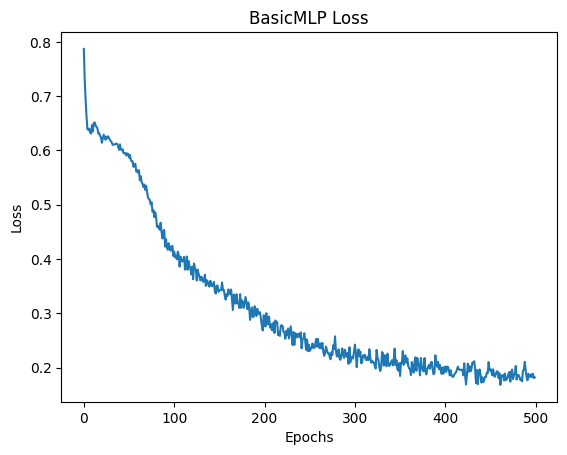

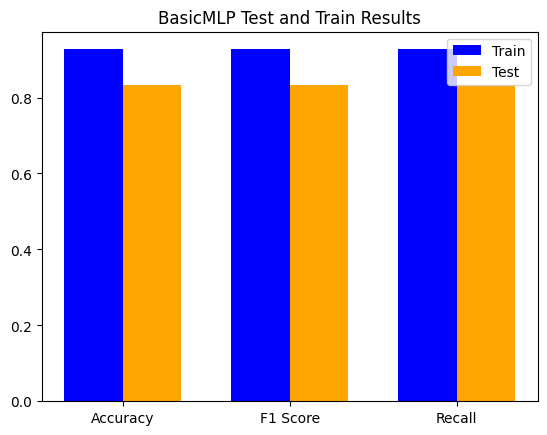

In [ ]:
loss_fn = nn.CrossEntropyLoss()
epochs = 500

# Training w/ default parameters or Optimizer
num_classes = len(y.unique())
model = CombinedNN(X_train.shape[1], 64, num_classes)
optimiser = optim.Adam(model.parameters())
loss_lst = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)

plt.plot(range(epochs), loss_lst[0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('BasicMLP Loss')
plt.show()

model.eval()
# Evaluate on train
train_pred = model(X_train_tensor)
pred = F.softmax(train_pred, dim=1).argmax(dim=1)
train_dict = compute_acc_metrics(y_train_tensor.detach().numpy(), pred)

# Evaluate on test
test_pred = model(X_test_tensor)
pred = F.softmax(test_pred, dim=1).argmax(dim=1)
test_dict = compute_acc_metrics(y_test_tensor.detach().numpy(), pred)

# Get values
keys = ['Accuracy', 'F1 Score', 'Recall']
train_val = list(train_dict.values())
test_val = list(test_dict.values())

# bar positions and width
x = np.arange(len(keys))  # label locations
width = 0.35  # width of the bars

# Plotting the bars
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, train_val, width, label='Train', color='blue')
bars2 = ax.bar(x + width/2, test_val, width, label='Test', color='orange')

# Add labels and title
ax.set_title("BasicMLP Test and Train Results")
ax.set_xticks(x)
ax.set_xticklabels(keys)
ax.legend()

# Show plot
plt.show()

### K-fold

In [ ]:
x, y = x_ohencoded, y

# Initialize lists to store training and test MSE for each fold
train_metrics = []
accuracy_lst, test_acc = [], []

# Create the KFold object
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True)

i = 0 # Tracking k-fold

# Loop over the folds
for train_index, test_index in kf.split(x):
    # Split the data into training and test sets for this fold
    x_fold_train= x.iloc[train_index]
    y_fold_train = y[train_index]
    x_fold_test= x.iloc[test_index]
    y_fold_test = y[test_index]

    # Convert to tensor
    X_train_tensor = torch.tensor(x_fold_train.values).float()
    y_train_tensor = torch.tensor(y_fold_train).long()
    X_test_tensor = torch.tensor(x_fold_test.values).float()
    y_test_tensor = torch.tensor(y_fold_test).long()

    # Train the model on the training set for this fold
    num_classes = len(y.unique())
    model = CombinedNN(x_fold_train.shape[1], 64, num_classes)
    optimiser = optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    epochs = 500
    epoch_lst = range(epochs)

    loss_lst, train_metrics, acc = trainClassification(model, optimiser, loss_fn, epochs, X_train_tensor, y_train_tensor)

    accuracy_lst.append(np.mean(acc))

    model.eval()
    test_pred = model(X_test_tensor)
    pred = F.softmax(test_pred, dim=1).argmax(dim=1)
    test_dict = compute_acc_metrics(y_test_tensor.detach().numpy(), pred)
    test_acc.append(test_dict['Accuracy'])
    i += 1

Epoch 0 - Loss: 0.683336079120636
{'Accuracy': 0.5880503144654088, 'F1 Score': 0.5592744365039501, 'Recall': 0.5880503144654088}
Epoch 100 - Loss: 0.4123188257217407
{'Accuracy': 0.8238993710691824, 'F1 Score': 0.8224695632104322, 'Recall': 0.8238993710691824}
Epoch 200 - Loss: 0.26422977447509766
{'Accuracy': 0.8836477987421384, 'F1 Score': 0.8831911210844408, 'Recall': 0.8836477987421384}
Epoch 300 - Loss: 0.20408327877521515
{'Accuracy': 0.8930817610062893, 'F1 Score': 0.8925158753593818, 'Recall': 0.8930817610062893}
Epoch 400 - Loss: 0.22162176668643951
{'Accuracy': 0.889937106918239, 'F1 Score': 0.8908349662331604, 'Recall': 0.889937106918239}
Epoch 0 - Loss: 0.7319172024726868
{'Accuracy': 0.3710691823899371, 'F1 Score': 0.24362426413287774, 'Recall': 0.3710691823899371}
Epoch 100 - Loss: 0.43118026852607727
{'Accuracy': 0.8144654088050315, 'F1 Score': 0.8129518745313069, 'Recall': 0.8144654088050315}
Epoch 200 - Loss: 0.23114411532878876
{'Accuracy': 0.9056603773584906, 'F1 Sco

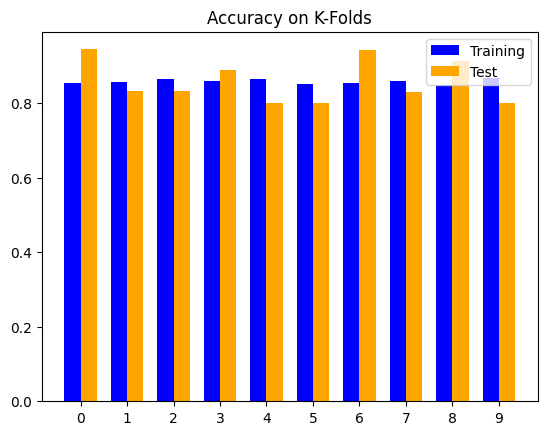

In [ ]:
x = np.arange(10)
width = 0.35  # the width of the bars

# Plotting the bars
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, accuracy_lst, width, label='Training', color='blue')
bars2 = ax.bar(x + width/2, test_acc, width, label='Test', color='orange')

# Add labels, title, and custom x-axis tick labels
ax.set_xticks(x)
ax.set_xticklabels(range(10))
ax.legend()
ax.set_title('Accuracy on K-Folds')

# Show plot
plt.show()